# Module to generate Sewer Topology

"""
@file   md_infrastructure.py
@author  Natalia Duque <natalia.duquevillarreal@eawag.ch>
@section LICENSE

Based in the structure of 
Urban Biophysical Environments and Technologies Simulator (UrbanBEATS) Bach, Peter (2012)

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

__author__ = "Natalia Duque"
__copyright__ = "Copyright 2018."

## Step 0 - Import files

In [1]:
import os
os.getcwd()

'c:\\Users\\duquevna\\Dropbox\\010_PhD\\01_Python\\SND_Manual\\ssnd\\interactive_notebooks'

In [2]:
# region --- PYTHON LIBRARY IMPORTS ---
# ignore developer warnings
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

import sys
sys.path.append('../..')

# imports for the module
import time
from math import *
from pathlib import Path
from random import randint
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.colors as colors
%matplotlib inline
# --- Spatial geometry ---
from shapely.geometry import Point, Polygon, LineString
# --- Graph theory algorithms ---
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
# --- URBANBEATS LIBRARY IMPORTS ---
#from model.modules.md_delinblocks import *
#import model.ublibs.ubdatatypes as ubdata
# --- SSND IMPORTS ---
from ssnd.help_functions.helper_functions import *
from ssnd.help_functions.plot_maps import *
from ssnd.defaults import *

pd.options.mode.chained_assignment = None  # default='warn'


module = "topology"

bool_run_step_by_step = False

verbose = False
notify = True
plot = True
# endregion

In [3]:
# Initialization: Step 0
# Get all the Blocks with specific columns for topology delineation and hydraulic desing 
sewer=1  

year_i = year_i
year_f = year_f
year_step = year_step
existing_treatment_id = existing_treatment_id 

case_study = case_study
name_blocks = name_blocks
name_pipes = name_pipes

connectivity = connectivity

# drop=drop  # Use max drop for D8-Algorithm to delineate collection pipes

# peak_factor= peak_factor # average daily peak factor 
# return_factor= return_factor # return factor 
# L_person_day= L_person_day # water consumption [L/person/day]  

path = DATA_DIR/case_study/"input/shp"  # Folder with output from UrbanBEATS: Urban Abstraction in Blocks
path


WindowsPath('c:/Users/duquevna/Dropbox/010_PhD/01_Python/SND_Manual/Data/data/Uster_200_200L/input/shp')

In [4]:
#region Color Ramps - Topology
cmap_lake = truncate_colormap(cmap=pl.cm.Greys, minval=0.2, maxval=0.2)
cmap_river = truncate_colormap(cmap=pl.cm.Greys, minval=0.2, maxval=0.2)
cmap_earth = truncate_colormap(cmap=pl.cm.gist_earth, minval=0.2)
cmap_feature1 = truncate_colormap(cmap=pl.cm.YlOrRd, minval=0.0, maxval=0.2)
# cmap_grey = truncate_colormap(cmap=pl.cm.Greys, minval=0.2, maxval=0.5)
cmap_grey = truncate_colormap(cmap=pl.cm.Greys, minval=0.4, maxval=1)
# cmap_grey = truncate_colormap(pl.cm.Greys, minval=0.2)
cmap_sink = truncate_colormap(pl.cm.Reds, minval=0.6)

cmap_has_ww= truncate_colormap(cmap=pl.cm.YlOrRd, minval=0.2, maxval=0.5)
cmap_pop = truncate_colormap(cmap=pl.cm.Reds, minval=0.2, maxval=0.7)
cmap_luc = truncate_colormap(cmap=pl.cm.YlOrBr, minval=0.2, maxval=0.7) # [TODO]

cmap_flow = truncate_colormap(cmap=pl.cm.Blues, minval=0.4, maxval=1.0)
cmap_age = truncate_colormap(cmap=pl.cm.magma_r, minval=0.4, maxval=1.0)

#from seaborn
new_cmap =sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
cmap_pop = sns.color_palette("dark:salmon_r", as_cmap=True)
cmap_luc = create_categorical_color_ramp(name="cmap_luc")
cmap_flare = sns.color_palette("flare", as_cmap=True)
cmap_cool_warm = sns.color_palette("coolwarm", as_cmap=True)
cmap_blue_orange = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
cmap_greens_r = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap_rocket = sns.color_palette("rocket", as_cmap=True)
cmap_water =sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

#endregion

Create new columns in the dataframe relevant for the current module

In [5]:
def df_with_new_fields (blocks:pd.DataFrame, 
                        module:str=None,
                        columns:list=None, 
                        verbose:bool=False,
                        notify:bool=True):
    """ Initialize new columns in Dataframe define the module or the list of columns to create 
        :param: module: str "topology",   
    """
    

    if columns is None and module is None: 
        return blocks.copy()

    elif module.lower().__contains__("topo"):
        
        verbose_(f"\n    module: {module}...", verbose)
        
        columns = ["dem_sink",
                "blk_elev",
                "edge",         # binary: 1 if the block is on the edge (boundary) of the case study 
                "carved",       # binary: 1 if the block has been carved
                "has_ww",       # binary: 1 if the block has sewer requirements
                "has_infra",    # binary: 1 if the block already has infrastructure (pipe or wwtp)
                "has_pipe",     # int: "collection": 1, "trunk": 2
                "has_wwtp",     # binary: 1 if the block has a WWTP
                "id_up",        # int: upstream ID
                "id_down",      # int: downstream ID
                "has_outlet",   # binary: 1 if the block has a an outlet (sink) of a sewersubcatchment
                "pipe_loc",     # str: 'external' or 'internal' pipes
                "type_sewer",   # str: "collection", "trunk", pipes or "wwtp_c", "wwtp_d" 
                "basin_id",     # int: sewer basin No.
                "horiz_dist",   # float: length of the sewer link
                "elev_drop",    # float: elevation difference of the sewer pipe
                "terr_slope",   # float: terrain slope
                "near_wwtp",    # int: ID of nearest WWTP
                "near_river",   # int: ID of nearest River         
                "ww_inflow",    # float: Flow coming into the Block (upstrem manhole)
                "peak_flow",    # float: Daily peak flow produced in the Block
                "PE",           # Population Equivalents 
                "desg_flow",    # float: Design flow considering the design factor and the peak flow.
                "up_ids",       # str: list of IDs of upstream blocks
                "down_ids",     # str: list of IDs of downstream blocks
                "built_year"    # int: construction year
                ]
    
    for col in columns:
        blocks[col] = 0.0 

    return blocks.copy()

In [6]:
def import_ub_blocks (path:Path,                     
                    year_i:int, 
                    year_f:int, 
                    year_step:int, 
                    module:str, 
                    connectivity:str, 
                    case_study:str, 
                    name:str, 
                    data_type:str="shp",
                    columns:list=None, 
                    verbose:bool=False,
                    notify:bool=True):
    blocks_dict = dict()
    """ Import Blocks files from UB into a geopandas dataframe for every year. The geometry of each block is required.
    """
    
    # if module.lower().startswith("top"):
    #     # Columns from UrbanBEATS input
    #     columns = ['geometry', 'BlockID', 'CentreX', 'CentreY', 'Neighbours', 'Active', 
    #     'pLU_RES', 'pLU_COM','pLU_ORC', 'pLU_LI', 'pLU_HI', 'pLU_CIV', 'pLU_SVU', 'pLU_RD', 'pLU_TR', 'pLU_PG', 'pLU_REF',
    #     'pLU_UND', 'pLU_NA','pLU_WAT','pLU_FOR','pLU_AGR',
    #     'Population', 'AvgElev', 'MaxElev', 'MinElev','HasRiver','HasLake',
    #     'Total_jobs', 'Blk_WD', 'Blk_WW']

    for year in range(year_i, year_f+1, year_step): 

        filename = f"{case_study}_{name}_({year}).{data_type}"
        if filename[-4:]  == ".shp":
            folder = filename[:-4]

        else:
            folder = ''

        file_path = path / folder / filename
        verbose_(f"Importing input for {year}: {file_path}", verbose=verbose)
        if not file_path.exists():
            verbose_(f"The system cannot find the path specified: \n{file_path}")
        
        blocks = gpd.read_file(file_path)
        
        if columns is None:
            columns = blocks.columns # if not specified import all columns 

        blocks = blocks[columns] # returns geopandas dataframe with the blocks and Data from UrbanBEATS 
        # Projection  EPSG:2056  "CH1903+ / LV95"
        verbose_(f"  Initialize new columns in Dataframe {year}...", verbose=verbose)
        blocks_dict[year] = df_with_new_fields(blocks, module=module, verbose=verbose) 
        
    verbose_(f"\nyears: {blocks_dict.keys()}", verbose)
    blocks_dict[year].columns
    return blocks_dict


In [7]:
# RUN import files from UB
# Get all the Blocks with specific columns for topology delineation and hydraulic desing 
if bool_run_step_by_step:
        
    path = path # Folder with output from UrbanBEATS: Urban Abstraction in Blocks

    verbose_(f"\n  Importing UB Blocks (shape files) into dictionaries from {year_i} to {year_f}  ... ", notify)
    blocks_dict = import_ub_blocks (path, year_i, year_f, year_step, module=module, connectivity=connectivity, case_study=case_study, name=name_blocks, verbose=True, notify=True)

In [8]:
if bool_run_step_by_step:
    for year_ in range(year_i, year_f+1, year_step):
        print(year_)
        print(list(blocks_dict[year_].columns))

In [9]:
if bool_run_step_by_step:
    blocks = blocks_dict[year_]

    # This includes the residential values 
    # WW_ResG, WW_ComG, WW_IndG are in [kL/day]
    total_blk_greywater = (sum(blocks["WW_ResG"]) +  sum(blocks["WW_ComG"]) + sum(blocks["WW_IndG"]))/ 1000.0 * 365.0  # converted to [ML/day]
    total_blk_WWG = sum(blocks["Blk_WWG"]) 


    print(total_blk_greywater)
    print(total_blk_WWG)


    # This includes the residential values 
    # WW_ResB, WW_ComB, WW_IndB are in [kL/day]
    total_blk_blackwater = (sum(blocks["WW_ResB"]) + sum(blocks["WW_ComB"]) + sum(blocks["WW_IndB"]))/ 1000.0 * 365.0 #  converted to [ML/day]
    total_blk_WWB = sum(blocks["Blk_WWB"]) # in [ML/day]
    print(total_blk_blackwater)
    print(total_blk_WWB)


    total_com_ind = total_blk_greywater + total_blk_blackwater
    print(total_com_ind)

    total_blk_WW = sum(blocks["Blk_WW"])
    print(total_blk_WW)

    print(total_com_ind/total_blk_WW)

population growth change

In [10]:
def growth (pv, rate, n):
    return pv*pow((1+rate),float(n))

In [11]:
def population_growth(blocks_dict, year_i=2018, rate=0.7, convert_population=False):
    
    if not convert_population:
        return True

    columns_UB = ['Population', 'Total_jobs', 'Blk_WD', 'Blk_WW']
    year_i = list(blocks_dict.keys())[0]
    print(year_i)

    for yr in blocks_dict.keys():
        blocks = blocks_dict[yr]
        print(rate)
        for c in columns_UB:
            po = blocks.loc[:, c]
            print(sum(blocks.loc[:, c]))
            
            blocks.loc[:, c] = blocks_dict[year_i].loc[:, c]*pow((1+rate/100),(yr-year_i))

            print(sum(blocks.loc[:, c]))
        # blocks_dict[yr] = blocks.copy() 
    return True

In [12]:
# RUN Populationg growth
# pop_growth= 0
# if run_step_by_step and pop_growth:
#     population_growth(blocks_dict, rate=0.7, convert_population=True)

#     population_growth_list = [sum(blocks_dict[yr].loc[:,"Population"]) for yr in blocks_dict.keys()]
#     print(population_growth_list)

In [13]:
if bool_run_step_by_step:
    pd.set_option("display.max_rows", 1056)
    blocks.loc[:, 'pLU']=0.0
    blocks.loc[:, 'pLU'] = blocks.loc[:, 'pLU_RES'] + blocks.loc[:,'pLU_COM'] + blocks.loc[:, 'pLU_ORC'] + blocks.loc[:,'pLU_LI'] + blocks.loc[:,'pLU_HI'] + blocks.loc[:,'pLU_CIV']
    display(blocks.loc[:, ['pLU_RES', 'pLU_COM', 'pLU_ORC', 'pLU_LI', 'pLU_HI', 'pLU_CIV', 'pLU_WAT', 'pLU', 'Active']])

In [14]:
if bool_run_step_by_step:
    bool_ = np.logical_and(blocks['pLU_COM'] > 0.0,blocks['Population'] > 0.0 )
    display(blocks.loc[bool_, ['pLU_RES', 'pLU_COM', 'pLU_ORC', 'pLU_LI', 'pLU_HI', 'pLU_CIV','pLU','Population', 'Total_jobs', 'Blk_WW']])
    len(blocks.loc[blocks['pLU']>0]) - 240

## Run Sewer module

plot population development

In [15]:
if bool_run_step_by_step:
    year=2018
    blocks = blocks_dict[year]

In [16]:
#  plot population

if bool_run_step_by_step:
    
    import plotly.express as px

    df = blocks.copy()
    pop = df['Population']
    fig = px.bar(df, x='BlockID', y=pop, labels={'y':'gdp'},
                hover_data=['Population'],
                title='Population per Block')
    fig.show()

In [17]:
#  RUN total population count
if bool_run_step_by_step:
    for yr in range(year_i, year_f+1, year_step):
        blocks  = blocks_dict[yr]
        tot_pop= sum(blocks["Population"])
        print(f"year: {yr} Population count: {tot_pop}")

In [18]:
#  Plot population growth figure
if bool_run_step_by_step:

    years = []
    l_population = []
    for yr, blocks in blocks_dict.items(): 
        tot_pop = sum(blocks["Population"])
        verbose_(f"{yr}, {tot_pop}", verbose)
        years.append(int(yr))
        l_population.append(sum(blocks["Population"])) 

    plt.bar(x=years, height=l_population, color="gray", edgecolor = "gray", alpha=0.5, tick_label=years)
    plt.ylabel("Total population [inhabitants]")
    plt.xlabel("Year")
    plt.show()

In [19]:
if bool_run_step_by_step:
    m3_person_sec = 1.2*(L_person_day/(1000*24*60*60))
    m3_person_sec

In [20]:
if bool_run_step_by_step:
    t_pop = sum(blocks_dict[2018].Population)
    print(t_pop)

    print(t_pop*m3_person_sec)

In [21]:
#  print all columns in the dataframe
if bool_run_step_by_step: print(*blocks.columns, sep='    ')

In [22]:
# Plot population development
if bool_run_step_by_step:
    plot_development(blocks_dict, feature_blks = "Population", units_blks_feature = "[Inhabitants]", cmap_blks=cmap_pop,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)

## Step 1 - Smooth the DEM using the carving method

1.1 Copy DEM 
to avoid damaging original DEM

In [23]:
def copy_dem(blocks:pd.DataFrame, verbose:bool=False, notify:bool=True):
    """ Creates a copy of the average elevation of each block into a new attribute. The copy will be used when the
        DEM information needs to be modified.
    """
    blocks.loc[:, "blk_elev"] = blocks.loc[:, "AvgElev"]

    return blocks["blk_elev"]


In [24]:
#  RUN copy DEM
if bool_run_step_by_step:
    for year_ in blocks_dict.keys():
        print(year_)
        blocks =blocks_dict[year_]
        copy_dem(blocks)
        display(blocks.loc[:, ("BlockID", "AvgElev", "blk_elev")].head(10))

Get Neighbours

In [25]:
def identify_neighbours(blocks:gpd.GeoDataFrame, verbose:bool=False, notify:bool=True):

    for idx, block in blocks.iterrows():
        block_id = blocks.loc[idx, "BlockID"]       

        # filter neighbours and get their ids
        neighbours = np.array(blocks.loc[blocks.geometry.touches(block['geometry']), "BlockID"])  # identify other features touching the current feature
        overlaps = np.array(blocks.loc[blocks.geometry.overlaps(block['geometry']), "BlockID"])  # identify other features overlaping the current feature
        ids_neighbours = list(np.union1d(neighbours, overlaps))  # minimum between neighbours elevations
        # verbose_(ids_neighbours)

        if len(ids_neighbours)==0:
            verbose_(f" Warning!! {block_id} does not have neighbours", verbose)
        
        blocks.loc[idx, "Neighbours"] = str(ids_neighbours)
    
    return True


In [26]:
#  RUN get sinks
if bool_run_step_by_step:
    for year_ in blocks_dict.keys():
        print(year_)
        blocks = blocks_dict[year_]
        identify_neighbours(blocks, verbose=True, notify=True)
        display(blocks.loc[:,["BlockID", "Neighbours"]])

1.2 Get sinks or 'pits' in DEM 

In [27]:
def get_sinks_df(blocks:gpd.GeoDataFrame, verbose:bool=False, notify:bool=True):
    """ Identify all terrain depressions in the original Digital Elevation Model.

    :param blocks
    :param verbose
    :return: sinks: dataframe of sinks in the original DEM
    """
   
    count=0
    
    # print(blocks.columns.values)
  
    for idx, block in blocks.iterrows():
        block_id = blocks.loc[idx, "BlockID"]       
    
        z = blocks.loc[idx, "blk_elev"]

        # filter neighbours and get their elevation
        neighbours = np.array(blocks.loc[blocks.geometry.touches(block['geometry']), "blk_elev"])  # identify other features touching the current feature
        overlaps = np.array(blocks.loc[blocks.geometry.overlaps(block['geometry']), "blk_elev"])  # identify other features overlaping the current feature
        z_neighbours = min(np.union1d(neighbours, overlaps))  # minimum between neighbours elevations
        
                
        # if z <= z_neighbors and blocks.loc[idx, "HasLake"] == 0:
        if z <= z_neighbours and blocks.loc[idx, "HasLake"] == 0:

            blocks.loc[idx, "dem_sink"] = 1 
            count += 1
        else:
            
            blocks.loc[idx, "dem_sink"] = 0 
            
    # find blocks at the edge or boundary of the case study
    blocks.loc[:, "edge"] = 0
    for row, block in blocks.iterrows():
        
        # neighbours = np.array(blocks.loc[blocks.geometry.touches(block['geometry']), "blk_elev"])  # identify other features touching the current feature
        # overlaps = np.array(blocks.loc[blocks.geometry.overlaps(block['geometry']), "blk_elev"])  # identify other features overlaping the current feature
        # ids_neighbours = list(np.union1d(neighbours, overlaps))  # minimum between neighbours elevations

        ids_neighbours =list(eval(block["Neighbours"]))  # list of all the neighbours 
        
        if len(ids_neighbours)<8:
            blocks.loc[row, "edge"] = 1

    verbose_(f"There are {count} sinks", verbose)

    sinks_df = blocks[np.array(blocks["dem_sink"]> 0)]
    return sinks_df

In [28]:
#  RUN get sinks
if bool_run_step_by_step:
    for year_ in blocks_dict.keys():
        print(year_)
        blocks = blocks_dict[year_]
        sinks_df = get_sinks_df(blocks,verbose=True, notify=True)
        display(sinks_df.loc[:,["BlockID", "dem_sink", "blk_elev"]])

In [29]:
# #  Plot Topography and Population for the current year
# if run_step_by_step:

#     blocks=blocks_dict[year]
#     c1 = truncate_colormap(pl.cm.gist_earth, minval=0.2)
#     plot_blocks_and_pipes_features(blocks, 
#                         columns=["blk_elev"], 
#                         cmaps=[c1], 
#                         title="Topography",
#                         module=module, connectivity=connectivity, case_study=case_study, year=year, 
#                         plot=True, verbose=False)


#     c2 = truncate_colormap(pl.cm.OrRd, minval=0.2, maxval=.8)                    
#     plot_blocks_and_pipes_features(blocks, 
#                         columns=["Population"], 
#                         cmaps=[cmap_pop], 
#                         title="Population",
#                         label="BlockID",
#                         module=module, connectivity=connectivity, case_study=case_study, year=year, 
#                         plot=True, verbose=False)

In [30]:
#  Plot sinks and water bodies
if bool_run_step_by_step:
    plot_blocks_and_pipes_features(blocks, 
                        columns=[ "edge", "HasLake", "HasRiver", "dem_sink"], 
                        label="BlockID",
                        cmaps=[cmap_grey, cmap_lake, cmap_river, cmap_sink], 
                        title="Sinks", 
                        module=module, connectivity=connectivity, case_study=case_study, year=year, 
                        plot=True, verbose=False)

1.3 Get neighbours data

In [31]:
def get_neighbours_data (blocks:pd.DataFrame, 
                            block_id:int, 
                            neighbours_list:list=None, 
                            output_columns:list= None, 
                            verbose:bool=False, 
                            notify:bool=True):
    """ Get neighbours data
    :param blocks           : DataFrame 
    :param block_id         : int 
    :param column           : list of columns to be retrieve from the original blocks dataframe
    :return  dataframe with specified columns
    """
    
    neighbours_data = []  # list to save data about the neighbours 
 
    if output_columns is None:
        output_columns = blocks.columns

    if neighbours_list is None:  
        block = blocks.loc[blocks["BlockID"] == block_id]
        # neighbours = np.array(blocks.loc[blocks.geometry.touches(block['geometry']), "BlockID"])  # identify other features touching the current feature
        # overlaps = np.array(blocks.loc[blocks.geometry.overlaps(block['geometry']), "BlockID"])  # identify other features overlaping the current feature
        # neighbours_list = list(np.union1d(neighbours, overlaps))  # list of all the neighbours 
        
        neighbours_list =list(eval(block["Neighbours"].values[0]))  # list of all the neighbours 
        
    
    if not neighbours_list:
        return pd.DataFrame(columns=output_columns)

    for nb in neighbours_list:

        nb_block = blocks[blocks["BlockID"]==nb]   # neighbouring block        
        neighbours_data.append(nb_block[output_columns])  # append neighbour row (pd.Series) to a list

    df_neighbours_data = pd.concat(neighbours_data)  # return a dataframe
    verbose_(f"\n\nNeighbours Data \n{type(df_neighbours_data)} \n{df_neighbours_data}", verbose=verbose)   

    return df_neighbours_data
   

In [32]:
# RUN get_neighbours_data
if bool_run_step_by_step:
    for year_ in blocks_dict.keys():
        blocks = blocks_dict[year_]
        print(year_)
        neighbours_data_df = get_neighbours_data(blocks, 
                                block_id=199, 
                                output_columns=["BlockID", "blk_elev"],
                                verbose=False, 
                                notify=True)
        display(neighbours_data_df)

Plot sinks with labels

In [33]:
# RUN plot sinks
if bool_run_step_by_step:
    blocks=blocks_dict[year]
    plot_with_labels(blocks, field_a="dem_sink", field_b="carved",  label="blk_elev")

1.4 Carving algorithm

In [34]:
def carving_algorithm(blocks:pd.DataFrame, verbose:bool=False, notify:bool=True):
    """ The Priority First Search (PFS) algorithm (Sedgewick, 1988) creates an adjusted DEM by removing
        terrain depressions. Starting from the sinks (depressions) the algorithm combines digging and
        filling approaches to reach a cell with lower elevation than the sink.

    :param sinks_list: ID of a blocks with a sink (terrain depression)
    :param verbose
    :return: True
    """
    
    
    sink_blocks = blocks[blocks["dem_sink"] > 0]


    for row, sink in sink_blocks.iterrows():
        
        sink_id = sink_blocks.loc[row,"BlockID"]
        verbose_(f" carving sink block id : {sink_id}", verbose=verbose)

        # filter neighbours and get their elevation
        # neighbours = np.array(blocks.loc[blocks.geometry.touches(sink['geometry']), "BlockID"])  # identify other features from blocks touching the current feature
        # overlaps = np.array(blocks.loc[blocks.geometry.overlaps(sink['geometry']), "BlockID"])  # identify other features from blocks overlaping the current feature
        # sink_neighbours = list(np.union1d(neighbours, overlaps))  #  neighbours 
        sink_neighbours =list(eval(sink_blocks.loc[row, "Neighbours"]))  # list of all the neighbours 
        

        verbose_(f"\n\nsink_id {sink_id}", verbose)
        verbose_(f"sink_neighbours {sink_neighbours} {type(sink_neighbours)}", verbose)
        
        lower_found = False     # breaking criterium

        # find neighbours elevations
        verbose_(f"Getting neighbours data for {sink_id}...", verbose=verbose)
        neighbours_data = get_neighbours_data(blocks=blocks, block_id=sink_id, neighbours_list=sink_neighbours, output_columns=["BlockID", "blk_elev"], verbose=verbose, notify=verbose)
        
        # creat empty lists for carving algorithm 
        # pq : priority_queue blocks to be visited
        pq_id = np.array(neighbours_data["BlockID"])
        pq_elev_diff = np.array(neighbours_data["blk_elev"] - sink["blk_elev"])
        pq_up_block = np.array([sink["BlockID"]]* len(neighbours_data))
        verbose_("PRIORITY QUEUE", verbose)
        verbose_(f" PQ :: {pq_id, pq_elev_diff, pq_up_block}", verbose)
        

        # pt : priority_tree blocks with potential to be carved
        pt_id = np.array(sink["BlockID"])   # initialize with the information of the sink itself 
        pt_elev_diff = np.array(0)          # initialize in zero elev_diff
        pt_up_block = np.array(-1)          # set upstream to -1 as a breaking value
        
        sink_id = sink["BlockID"]
        

        # Check if there is already a block that is lower due to a previous carving 
        if any(pq_elev_diff < 0):
            continue

        while not lower_found:
            # Find the neighbour in the priority queue with smallest elevations difference "pq_elev_diff"
            if any(pq_elev_diff < 0):
                lower_found = True
               
                lower_blocks = pq_elev_diff < 0   # boolean np.array to find negative values
                            
                lower_delta_elev = max(pq_elev_diff[lower_blocks])
                idx_closest_lower = np.where(pq_elev_diff == lower_delta_elev)
               

                # get the information of the block in the priority_queue list with the minimum elevation difference and save it in the priority_tree list
                # ::: np.append(np.array, element)
                pt_id = np.append(pt_id, pq_id[idx_closest_lower])         
                pt_elev_diff = np.append(pt_elev_diff, pq_elev_diff[idx_closest_lower])
                pt_up_block = np.append(pt_up_block, pq_up_block[idx_closest_lower])

                verbose_("PRIORITY TREE", verbose)
                verbose_(f" PT :: {pt_id, pt_elev_diff, pt_up_block}", verbose) 


                # delete the block that has been evaluated from the priority_queue list  
                # ::: np.delete(np.array, index_element)
                pq_id = np.delete(pq_id, idx_closest_lower)   
                pq_elev_diff = np.delete(pq_elev_diff, idx_closest_lower)  
                pq_up_block = np.delete(pq_up_block, idx_closest_lower)
                
                verbose_("PRIORITY QUEUE", verbose)
                verbose_(f" PQ :: {pq_id, pq_elev_diff, pq_up_block}", verbose)

                # build the path through the upstream block until the sink 
                path_ids = np.array([pt_id[-1]])

                iter= 0
                while -1 not in path_ids: 
                    if iter == 5:
                        break
                    
                    # ids in the path
                    idx_up_block = np.where(pt_id == path_ids[-1])
                    id_up_block = pt_up_block[idx_up_block]
                    path_ids = np.append(path_ids, id_up_block)
                    
                    iter += 1
                verbose_(f"carving path :: {path_ids}", verbose)

                ids_blocks_to_carve = np.flip(path_ids[1:-2])
                verbose_(f"blocks_to_carve :: {ids_blocks_to_carve}", verbose)

                # set modified elevation for carved blocks 
                for i in range(len(ids_blocks_to_carve)):
                    id_to_carve = ids_blocks_to_carve[i]
                    carving_blk = blocks[blocks["BlockID"] == id_to_carve]

                    idx_carving = np.where(pt_id == id_to_carve)
                    elev_to_carve = pt_elev_diff[idx_carving]                    

                    # update the elevation of the carved block in the main dataframe
                    blocks.loc[carving_blk.index, "blk_elev"] = float(carving_blk["blk_elev"]-elev_to_carve-0.001*(i+1))
                    blocks.loc[carving_blk.index, "carved"] = i+1

            else:
                # Searching the neighbours to find one that has a lower elevation
                # The search is guided by the neighbouring blocks with the minimum elevation difference (pq_elev_diff), so that the least excavation is required

                # get the index of the block in the pq_list with the minimum elevation difference 
                idx_min = np.argmin(pq_elev_diff) 
                id_min_elev = pq_id[idx_min]
                
                # get the information of the block in the priority_queue list with the minimum elevation difference and save it in the priority_tree list
                # ::: np.append(np.array, element)
                pt_id = np.append(pt_id, id_min_elev)         
                pt_elev_diff = np.append(pt_elev_diff, pq_elev_diff[idx_min])
                pt_up_block = np.append(pt_up_block, pq_up_block[idx_min])
                
                verbose_("PRIORITY TREE", verbose)
                verbose_(f" PT :: {pt_id, pt_elev_diff, pt_up_block}", verbose) 
                
                # delete the block that has been evaluated from the priority_queue list  
                # ::: np.delete(np.array, index_element)
                pq_id = np.delete(pq_id, idx_min)   
                pq_elev_diff = np.delete(pq_elev_diff, idx_min)  
                pq_up_block = np.delete(pq_up_block, idx_min)
                
                # get the list of neighbours of the block under evaluation to continue the search
                pq_block= blocks[blocks["BlockID"] == int(id_min_elev)]
                pq_block_id = pq_block["BlockID"].values[0]
                
                
                # neighbours = np.array(blocks.loc[blocks.geometry.touches(pq_block['geometry']), "BlockID"])  # identify other features from blocks touching the current feature
                # overlaps = np.array(blocks.loc[blocks.geometry.overlaps(pq_block['geometry']), "BlockID"])  # identify other features from blocks overlaping the current feature
                # pq_block_neighbours = list(np.union1d(neighbours, overlaps))  #  neighbours 
                pq_block_neighbours =list(eval(pq_block["Neighbours"].values[0]))  # list of all the neighbours 
                verbose_(f"pq_block {pq_block_id} : neigbours {pq_block_neighbours}", verbose)

                # get information about new neighbours
                # ::: np.setdiff1d(arr1, arr2) Find the set of different values between two arrays. Return the unique values in arr1 that are not in arr2.
                new_nb_ids = np.setdiff1d(pq_block_neighbours, pt_id, assume_unique=True)   # ignore blocks that have been already visited (i.e. in the priority tree list)
                new_nb_ids = list(np.setdiff1d(new_nb_ids, pq_id, assume_unique=True))      # ignore duplicate blocks already in the priority queue list 
                verbose_(f"new_neighbours {new_nb_ids}", verbose)                                       

                verbose_(f"Getting neighbours data for {pq_block_id}...", verbose)
                neighbours_data = get_neighbours_data(blocks=blocks, block_id=pq_block_id, neighbours_list=new_nb_ids, output_columns=["BlockID", "blk_elev"], verbose=verbose, notify=verbose)
            
                new_nb_delta_elev = neighbours_data["blk_elev"] - sink["blk_elev"]  # calculate the elevation difference among neighbours
                predecessor_block = id_min_elev  # save predecessor block from where the minimum elevation difference is comming from

                # add information of the new neighbours into the priority_queue list to be visited
                # ::: np.append(np.array, element)
                pq_id = np.append(pq_id, new_nb_ids)         
                pq_elev_diff = np.append(pq_elev_diff, new_nb_delta_elev)
                pq_up_block = np.append(pq_up_block, [predecessor_block]*len(new_nb_ids))
                
                verbose_("PRIORITY QUEUE UPDATED", verbose)
                verbose_(f" PQ :: {pq_id, pq_elev_diff, pq_up_block}", verbose)
    return True

In [35]:
# RUN carving_algorithm
if bool_run_step_by_step:
    carving_algorithm(blocks, verbose=True)

In [36]:
# RUN plot sinks
if bool_run_step_by_step:
    blocks=blocks_dict[year]
    plot_with_labels(blocks, field_a="dem_sink", field_b="carved",  label="blk_elev")

In [37]:
def update_topography_over_time(blocks_dict:dict, year_i:int, year_f:int, year_step:int, verbose=verbose, notify:bool=True):

    base_blocks = blocks_dict[year_i]

    years_ordered = np.sort(list(blocks_dict.keys()))
    print(years_ordered)

    for year in years_ordered:
        blocks = blocks_dict[year]
        blocks.loc[:,"blk_elev"] = base_blocks.loc[:,"blk_elev"]
        blocks.loc[:,"carved"] = base_blocks.loc[:,"carved"]
        blocks_dict[year] = blocks.copy()

    return True

In [38]:
# RUN update_topography_over_time
if bool_run_step_by_step:
    update_topography_over_time(blocks_dict, year_i=2018, year_f=2038, year_step=5, verbose=False)

In [39]:
#  plot_with_labels
if bool_run_step_by_step:
    for year_ in blocks_dict.keys():
        print(year_)
        blocks = blocks_dict[year_]
    plot_with_labels (blocks, field_a="dem_sink", field_b="carved" ,label="BlockID")

1.5 Check that all sinks where removed

In [40]:
# RUN  get_sinks_df to check that all sinks in the DEM where corrected
if bool_run_step_by_step:
    for year_ in blocks_dict.keys():
        blocks =blocks_dict[year_] 
        print(year_)
        sinks = get_sinks_df(blocks)

        # plot_blocks_and_pipes_features(blocks, columns=["dem_sink"], 
        #                                 module=module, connectivity=connectivity, case_study=case_study, year=year, 
        #                                 plot=True, verbose=False)

        if len(sinks)>0:
            display(blocks[["dem_sink", "AvgElev", "blk_elev", "HasRiver", "edge"]][blocks["dem_sink"]> 0])
        else:
            verbose_("  There are no terrein depressions ",verbose)

# START ITERATION FROM HERE 

## Step 2 - Get blocks with wastewater management requirements

In [41]:
#  print some blocks population and jobs
if bool_run_step_by_step:
    for year_ in blocks_dict.keys():
        blocks =blocks_dict[year_] 
        print(year_)
        display(blocks.loc[:,( "Population", "Total_jobs", "has_infra")][550:560])

2.1 Get SWW Blocks

In [42]:
def get_sww_blocks(blocks:pd.DataFrame, output_columns:list, verbose:bool=False, notify:bool=True):
    """ Determine suitable blocks to place sewer networks.
        No sewers are required when Population = 0 and there is no industry (total employees = 0)

        :param: blocks dataframe
        :param: output_Columns as a list[]  default: dataframe.columns
        :param: verbose boolean for the printing statements -> default: False
        :return: sww_blocks List of blocks require wastewater management
    """
    
    # Select Blocks with population or Employment > 1
    if "Active" in blocks.columns:
        active_blocks = blocks["Active"] > 0  # Check for block status active means that the block is inside of the case study area and has some kind of activity (e.g. land use, population) assignment
    
    bool_pop = blocks['Population'] > 1
    bool_employment = blocks['Total_jobs'] > 1
    bool_sww = np.logical_and(np.logical_or(bool_pop, bool_employment), active_blocks)
    
    # update main dataframe
    blocks.loc[bool_sww, "has_ww"] = int(1)  # the block has wastewater management
    
    # Extract sww_blocks with desired columns
    sww_blocks = blocks.loc[bool_sww, output_columns]
    verbose_(f"No. of blocks that should have a sewer connection: {len(sww_blocks)}", verbose=verbose)
    
    return sww_blocks

In [43]:
# RUN get_sww_blocks
if bool_run_step_by_step:
    year=2018
    blocks =blocks_dict[year] 
    sww_blocks = get_sww_blocks(blocks, output_columns=["has_ww"], verbose=False)
    print(f" {len(sww_blocks)} in {year}")

In [44]:
#  print blocks with WW - wastewater management
if bool_run_step_by_step:
    len_sww_blocks = sum(blocks["has_ww"]>0)
    print(f"year: {year} sww_blocks: {len_sww_blocks}")

## Step 3 - Get existing infrastructure

3.1. Pass topology from previous year (if any) 

In [45]:
def get_previous_topology(blocks_dict:dict, year_a:int, year_b:int, verbose:bool=False, notify:bool=True):
    """Pass topology from previous to current year """

    

    ## THE NEW COLUMNS DON'T EXIST IN THE DICTIONARY BLOCKS_DICT
    blocks_df_a = blocks_dict[year_a]
    blocks_df_b = blocks_dict[year_b]

    indexes_a = blocks_df_a[blocks_df_a["has_infra"]> 0].index      # Blocks from the previous year that already have infrastructure
    indexes_b = blocks_df_b[blocks_df_b["has_ww"]>0].index          # Blocks from the current year that need sewer infrastructure

    bool_b_in_a = np.in1d(indexes_b, indexes_a)  # check which blocks form B that require SWW are already in A
    verbose_(f"{sum(bool_b_in_a==False)} new blocks out of {len(indexes_b)} that should have SWW", verbose) 

    indexex_to_copy = indexes_a # These index list gives the information of ALL the previous network
    verbose_(f"No. of blocks with infrastructure to copy from {year_a} to {year_b}: {len(indexex_to_copy)} \n indexes: \n {indexex_to_copy}", verbose)

    indexes_new = indexes_b[bool_b_in_a==False] # These will be new blocks to add to the topology
    verbose_(f"No. of new blocks to design: {len(indexes_new)} \n indexes: \n {indexes_new}", verbose)

    blocks_df_b.iloc[indexex_to_copy] = blocks_df_a.iloc[indexex_to_copy]
    return indexes_new

In [46]:
# get_previous_topology
if bool_run_step_by_step: 
    display(len(blocks_dict[year].loc[blocks_dict[year]['has_ww']>0]))
    get_previous_topology(blocks_dict, year_a=2018, year_b=year, verbose=True, notify=True)

In [47]:
#  print blocks in year_b with has_infra
if bool_run_step_by_step:
    year_b = year
    blocks_b = blocks_dict[year_b]
    pd.set_option("display.max_rows", blocks.shape[0])  # None or 1000
    display(blocks_b.loc[blocks_b["has_infra"]>0 , ["BlockID", "has_ww", "has_infra" ]])
    pd.reset_option("display.max_rows")

In [48]:
#  Plot SWW Blocks and water bodies
if bool_run_step_by_step:
    plot_blocks_and_pipes_features(blocks, columns=["HasLake", "HasRiver", "has_ww"], label="BlockID", cmaps=[cmap_lake, cmap_river, cmap_has_ww],
                                    module=module, connectivity=connectivity, case_study=case_study, year=year, 
                                    plot=True, verbose=False)

In [49]:
#  Check warning: Plot multiple plots needs input about the list of colors 
if bool_run_step_by_step:
    plot_blocks_and_pipes_features(blocks, columns=["HasLake","has_ww", "HasRiver"], cmaps=[cmap_lake, cmap_has_ww],
                                    module=module, connectivity=connectivity, case_study=case_study, year=year, 
                                    plot=True, verbose=False)

### 3.2 Detect Treatmen plants with coordinates

In [50]:
def detect_treatment(blocks, treatments, verbose=verbose):
    """Identifies if there is a treatment facility inside the block

    :param blocks: current ID of the block in evaluation
    :param treatments: treatment facilities block ID
    :param verbose
    :return: list of blocks with WWTP.
    """

    treat_facilities = []
    for j in range(len(treatments)):
        
        treat_point = Point(treatments[j])     
        
        for i, block in blocks.iterrows():

            if not treat_point.intersects(blocks.loc[i, "geometry"]):
                continue

            blocks.loc[i, "has_wwtp"] = 1   # [TODO] should this be cathegorical?  1 for Lagrge Scale WWTP
            blocks.loc[i, "type_sewer"] = "wwtp_c"   # [TODO] should this be cathegorical?  1 for Lagrge Scale WWTP
            blocks.loc[i, "has_ww"] = 1     # if there is a WWTP the block should also have WW management
            blocks.loc[i, "has_infra"] = 1     # if there is a WWTP the block should also have WW infrastructure
            blocks.loc[i, "has_outlet"] = 1     # if there is a WWTP the block should also be an outlet for the centralised network
            treat_facilities.append(block["BlockID"])

    if len(treat_facilities) == 0:
        verbose_("No treatment facilities detected", verbose = True)

    verbose_(f"Treatment facilities detected {treat_facilities}", verbose=verbose)
    return treat_facilities

In [51]:
# RUN detect_treatment
if bool_run_step_by_step:
    treat_id = 671
    
    blocks = blocks_dict[year]
    # treatments = [(2694696, 1245043)]  # coordinates for block (672) ARA_Uster(200)
    centroid1 = blocks[blocks["BlockID"]==treat_id].centroid
    # centroid2 = blocks[blocks["BlockID"]==672].centroid
    treatments = [(int(centroid1.x), int(centroid1.y))]
    # print(centroid)

    treat_facilities = detect_treatment(blocks, treatments)
    print(year_, treat_facilities)
    display( blocks.loc[blocks["BlockID"]==treat_id, ("has_ww", "has_wwtp", "has_infra", "type_sewer")])


In [52]:
#  plot has_wwtp
if bool_run_step_by_step:
    plot_blocks_and_pipes_features(blocks, columns=["has_wwtp"], cmaps=[pl.cm.RdPu_r],
                                    module=module, connectivity=connectivity, case_study=case_study, year=year, 
                                    plot=True, verbose=False)

In [53]:
def identify_closest_treatment_facility(blocks, treatments, verbose=verbose):
    """Identifies the closest treatment facility from the current block

    :param sww_blocks: list of blocks with SWW
    :param treatments: list of block IDs with treatment facilities
    :return: block with closest treatment.
    """

    if treatments is None:
        verbose_("No treatment facilities detected", verbose=verbose)
        pass
    
    sww_blocks = blocks[blocks["has_ww"]>0]
    for row, current_block in sww_blocks.iterrows():
        distance = 999999999
        blk_id = sww_blocks.loc[row, "BlockID"]

        x_b = sww_blocks.loc[row, "CentreX"]
        y_b = sww_blocks.loc[row, "CentreY"]
        # z_b = current_block.get_attribute("AvgElev")
        # b_point = (x_b, y_b, z_b)

        for j in range(len(treatments)):

            treat_block = blocks.loc[np.array(blocks["BlockID"] == treatments[j])].index

            x_treat = blocks.loc[treat_block, "CentreX"]
            y_treat = blocks.loc[treat_block, "CentreY"]
            # z_treat = treat_block.get_attribute("AvgElev")
            # treat_point = (x_treat, y_treat, z_treat)

            # Calculate distance to the treatment block
            dx = x_b - x_treat
            dy = y_b - y_treat
            # dz = z_b-z_treat

            dist = float(np.sqrt((dx * dx) + (dy * dy)))
            # slope = (dz) / dist

            if dist >= distance:
                continue

            distance = dist
            closest_treat_id = treatments[j]

            # update main datraframe
            blocks.loc[row, "near_wwtp"] = closest_treat_id

    return True

In [54]:
# RUN identify_closest_treatment_facility
if bool_run_step_by_step:
    blocks = blocks_dict[year]
    print(year)
    identify_closest_treatment_facility(blocks, treatments=treat_facilities, verbose=verbose)
    display(blocks.loc[blocks["has_ww"]>0, ["near_wwtp", "blk_elev"]])

Plots SWW, topography, population

In [55]:
if bool_run_step_by_step:

    plot_blocks_and_pipes_features(blocks=blocks, pipes=None,
                                   columns=["near_wwtp"], label="near_wwtp", cmaps=[pl.cm.YlOrRd],
                                   columns_p=[], labels_p=[], cmap_p=[pl.cm.Greys_r], title="Nearest wastewater treatment plant",
                                   module=module, connectivity=connectivity, case_study=case_study, year=year, 
                                   plot=True, verbose=False)

## Step 4 - Delineate the sewer network for the blocks with population or employment greater than 1 person.

### 4.1 Delineate SWW flow paths

#### Get neighbourbours that require wastewater management

In [56]:
def get_sww_neighbours(blocks:pd.DataFrame, 
                       block_id:int, 
                       output_columns:list=["BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra"],
                       lower_neighbours:bool=True,      # Retrieve slection only from lower neighbours
                       sww_guide_built:bool=True,       # Guide with built infrastructure
                       sww_guide_natural:bool=True,     # Guide with built natural
                       verbose:bool=False, 
                       notify:bool=True):
    """Get SWW Neighbours or extended neighbours (lower_neighbours=True, sww_guide_built=True, sww_guide_natural=True)
    Get the information of adjacent blocks accounting for drainage infrastructure or natural features. 
    Consider extended neighbourhood when no adjacent neighbours fullfill the criteria.

    :param blocks : DataFrame() of blocks in the case study
    :param block_id : as an int()
    :param output_columns : list of columns to retrieve from original dataframe (default: ["BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra"])
    :param lower_neighbours : boolean to retrieve only lower neighbours (default: True)
    :param sww_guide_built=1 : boolean to guide with built infrastructure (default: True)
    :param sww_guide_natural=1: boolean to guide with built natural (default: True)
    :param verbose: boolean for printing statement (default: True)
    :return: dataframe of all suitable neighbours as dataframe
    
    """    

    # Current block info   
    block = blocks.loc[blocks["BlockID"] == block_id]
    current_elev = float(block["blk_elev"])


    # Get all neighbours data as a dataframe 
    verbose_(f"Getting neighbours data for {block_id}...", verbose)
    neighbours_data = get_neighbours_data(blocks=blocks, block_id=block_id, output_columns=output_columns, verbose=verbose, notify= notify)
    
    # Filter blocks with SWW/WWTP and lower elevations
    bool_wwtp = np.array(neighbours_data["has_wwtp"]>0)
    bool_ww = np.array(neighbours_data["has_ww"]>0)
    bool_sww = np.logical_or(bool_wwtp, bool_ww)
    
    # # Get rid of MultiIndex in the columns
    # if type(neighbours_data.columns) is pd.MultiIndex:
    #     neighbours_data.columns = neighbours_data.columns.get_level_values(level=0)
    
    # If no neighbour has sewer coverage, search in the extended neighbourhood (one neighbourhood futher out)
    if not np.any(bool_sww):
        for idx, nb in neighbours_data.iterrows():
            
            nb_ID = int(nb["BlockID"])
            verbose_(f"\nEXTENDED NEIGHBOURHOOD of {nb_ID}", verbose)
            
            # get the list of extended neighbours 
            verbose_(f"Getting neighbours data for {block_id}...", verbose)
            extended_neighbours_data = get_neighbours_data(blocks=blocks, block_id=nb_ID, output_columns=output_columns, verbose=verbose, notify=notify)
            neighbours_data = pd.concat(objs=[extended_neighbours_data, neighbours_data], ignore_index=False)
            neighbours_data.sort_index(inplace=True)
            neighbours_data.drop_duplicates(inplace=True)

            # Get rid of MultiIndex in the columns
            if type(neighbours_data.columns) is pd.MultiIndex:
                neighbours_data.columns = neighbours_data.columns.get_level_values(level=0)
        
        # Select only blocks that need wastewater management or have WWTP                
        bool_wwtp = np.array(neighbours_data["has_wwtp"]>0)
        bool_ww = np.array(neighbours_data["has_ww"]>0)
        bool_sww = np.logical_or(bool_wwtp, bool_ww)
        verbose_(f"\n{sum(bool_sww)} extended neighbours with SWW", verbose)

    if np.any(bool_sww):
        neighbours_data = neighbours_data.loc[bool_sww]
        verbose_(f"{len(neighbours_data)} SWW Blocks", verbose)

        if lower_neighbours:
            bool_lower = np.array(neighbours_data["blk_elev"]< current_elev)
            neighbours_data = neighbours_data[bool_lower]
            verbose_(f"{len(neighbours_data)} lower neighbours {neighbours_data}", verbose)


    # Prioritize blocks with existing infrastructure
    if sww_guide_built:
        bool_wwtp = np.array(neighbours_data["has_wwtp"]>0)       
        bool_infra = np.array(neighbours_data["has_infra"]>0) 
        existing_infra_blocks= np.logical_or(bool_wwtp, bool_infra)
        verbose_(f"{sum(existing_infra_blocks)} Blocks with infrastructure", verbose)
    
    # Prioritize blocks with natural water bodies
    if sww_guide_natural:
        river_blocks = np.array(neighbours_data["HasRiver"]>0)
        lake_blocks = np.array(neighbours_data["HasLake"]>0)
        natural_blocks = np.logical_or(river_blocks, lake_blocks)
        verbose_(f"{sum(natural_blocks)} Blocks with natural water bodies", verbose)
        
    # Merge blocks with infrastructure and with natural water bodies    
    selection = np.logical_or(existing_infra_blocks, natural_blocks)
    if np.any(selection):
        neighbours_data = neighbours_data.loc[selection,:]

    # # Get rid of MultiIndex in the columns
    # if type(neighbours_data.columns) is pd.MultiIndex:
    #     neighbours_data.columns = neighbours_data.columns.get_level_values(level=0)
        
    return neighbours_data


In [57]:
# RUN get_neighbours_data vs. #  get_sww_neighbours_data
if bool_run_step_by_step:    
    block = blocks.loc[blocks["BlockID"]==199, ("BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra")]
    block_id = int(block["BlockID"])
    output_columns = ["BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra"]
    print("current block")
    display(block)
    
    verbose_(f"Getting neighbours data for {block_id}...", verbose)
    neighbours_data = get_neighbours_data(blocks=blocks, 
                                            block_id=block_id,
                                            output_columns=output_columns, 
                                            verbose=False, 
                                            notify=True)
    display(neighbours_data)

    print("get_sww_neighbours")
    neihbours_sww = get_sww_neighbours( blocks, block_id=block_id, 
                                        output_columns=["BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra"],
                                        lower_neighbours=True,
                                        sww_guide_built=1, 
                                        sww_guide_natural=1, 
                                        verbose=False,
                                        notify=True)
    display(neihbours_sww)

#### D8 - algorithm 

In [58]:
def d8_drop(current_block=pd.DataFrame, 
            neighbours_data=pd.DataFrame, 
            drop = "maximum", 
            max_exc_depth:float=5.,
            verbose:bool=False, 
            notify:bool=True):
    """Uses the standard D8-Algorithm to find the id_down, downstream neighbouring block (Max drop). Return the BlockID
    and the delta-Z value of the drop. Elevation difference is calculated as dz = [Z-NHD_Z ] and is
    negative if the neighbouring Block has a lower elevation than the central Block.

    :param current_block: Current Block
    :param nhd: dataframe with the Block ID and elevation of all the neighbours
    :param verbose
    :return: down_id: block ID that water drains to.
    """
    current_id = current_block["BlockID"].values[0]
    
    verbose_(f"  Get downstream block for {current_id}...", verbose)
    
    # if type(current_block) is not pd.DataFrame():
    #     current_block = current_block.to_frame()
    
    
    #region Block with WWTP
    bool_wwtp = int(current_block["has_wwtp"])

    if type(bool_wwtp) is pd.Series:
        bool_wwtp = bool_wwtp.values[0]
        
    # Blocks with wwtp drain to themselves
    if bool_wwtp:
        verbose_(" WWTP found", verbose)
        return current_block
    #endregion
   
    z = float(current_block["blk_elev"])
    verbose_(f"\ncurrent block: {current_id} with elevation {z} m.a.s.l", verbose)
    
    # calculate elevation differences among the neighbouring blocks
    elev_delta = z - np.array(neighbours_data["blk_elev"]) 
    neighbours_data.loc[:, "elev_delta"] = elev_delta
    verbose_(f"Neighbouring blocks elevation deltas \n{elev_delta}\n", verbose)

    # if the block has the lowest elevation among its neighbours then is a local sink ('pit')
    bool_lower = np.array(neighbours_data["elev_delta"] > 0 )
    lower_elevations = neighbours_data.loc[bool_lower, :]
    verbose_(f" [{lower_elevations}] lower elevations", verbose)
    
    # Only one lower neighbour
    if len(lower_elevations)==1:
        
        down_block = lower_elevations
        verbose_(f"down_block A {down_block}", verbose)
        
        # Get rid of MultiIndex in the columns
        if type(down_block.columns) is pd.MultiIndex:
            print(f"STOP A ---- {type(down_block)}  should be a dataframe")
            down_block.columns = down_block.columns.get_level_values(level=0)

        down_id = down_block["BlockID"].astype(int)
    
    # Multiple lower neighbours 
    elif len(lower_elevations) > 1:
        
        if drop.lower().startswith("max"):
            elev = float(max(lower_elevations["elev_delta"].values))
        elif drop.lower().startswith("min"):
            elev = float(min(lower_elevations["elev_delta"].values))
        
        bool_selected_elev = np.array(lower_elevations["elev_delta"] == elev)
        down_block = lower_elevations.loc[bool_selected_elev]
        verbose_(f"down_block B {down_block}", verbose)
        
        if type(down_block.columns) is pd.MultiIndex:
            print(f"STOP B ---- {type(down_block)}  should be a dataframe")
            down_block.columns = down_block.columns.get_level_values(level=0)

        down_id = down_block["BlockID"].astype(int)
   
    # No lower neighbours     
    else:
        # if some neighbour has slightly higher terrain elevation, but lower than the maximum excavation depth (5m)
        
        bool_higher = np.array(neighbours_data["elev_delta"] < max_exc_depth )
        higher_elevations = neighbours_data.loc[bool_higher, :]
        verbose_(f" [{higher_elevations}] higher elevations below max. excavation depth", verbose)

        if len(higher_elevations) >= 1:
            # if the block has the lowest elevation among its neighbours then is a local sink ('pit')
            elev = float(min(higher_elevations["elev_delta"].values))
            
            bool_selected_elev = np.array(higher_elevations["elev_delta"] == elev)
            down_block = higher_elevations.loc[bool_selected_elev]
            verbose_(f"down_block C.1 {down_block}", verbose)

        else:
            down_id = current_id
            down_block = current_block
            verbose_(f"down_block C {down_block}", verbose)

        # Get rid of MultiIndex in the columns    
        if type(down_block.columns) is pd.MultiIndex:
            print(f"STOP C ---- {type(down_block)}  should be a dataframe")
            down_block.columns = down_block.columns.get_level_values(level=0)
    

    verbose_(f"\ndown_id --------> {down_id}", verbose)
       
    return down_block

In [59]:
# RUN d8_drop with get_sww_neighbours
if bool_run_step_by_step:

    block_id = 159
    
    blocks = blocks_dict[year]
    block = blocks.loc[blocks["BlockID"]==block_id, ("BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra")]
    print("Current block")
    display(block)

    neihbours_sww = get_sww_neighbours( blocks, block_id=block_id, 
                                                output_columns=["BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra"],
                                                lower_neighbours=True,
                                                sww_guide_built=True, 
                                                sww_guide_natural=True, 
                                                verbose=True)


    down_block = d8_drop(current_block=block, neighbours_data=neihbours_sww, drop = "max", verbose=False)
    print("\nDown block")
    display(down_block)

#### Delineate Centralized SWW Network

In [60]:
def calculate_distance_from_points(point_up, point_down):
    """Calculate length"""
    x_diff = float(point_up.x) - float(point_down.x)
    y_diff = float(point_up.y) - float(point_down.y)
    length = sqrt(x_diff**2 + y_diff**2)

    return length

In [61]:
def calculate_slope(elev_up, elev_down, length):
    """calculate slope"""

    if float(length) == 0.0:
        length = 1.0  # to avoid division by 0
    slope = (float(elev_up) - float(elev_down))/length
    return slope

In [62]:
#  RUN calculate_distance and calculate_slope
if bool_run_step_by_step:
    a = Point([100, 0])
    b = Point([200, 0])

    length = calculate_distance_from_points(a, b)

    elev_up = 100
    elev_down = 90


    calculate_slope(elev_up, elev_down,  length)

In [63]:
# print blocks to design

if bool_run_step_by_step: 
    bool_has_ww = blocks["has_ww"]> 0
    bool_without_Infra = blocks["has_infra"] == 0
    bool_to_design = np.logical_and(bool_has_ww, bool_without_Infra)

    display(blocks.loc[bool_to_design,["BlockID","has_infra", "has_pipe", "has_wwtp", "has_outlet", "id_up", "id_down"]])
    display(blocks.loc[blocks["has_infra"] == 1,["BlockID","has_infra", "has_pipe", "has_wwtp", "has_outlet", "id_up", "id_down"]])

In [64]:
def delineate_centralised_sww (blocks:pd.DataFrame,
                                year:int, 
                                lower_neighbours:bool=True,
                                sww_guide_built:bool=True, 
                                sww_guide_natural:bool=True,
                                drop:str="max",
                                verbose:bool=False, 
                                notify:bool=True):

    
    
    # select the blocks with sww from the main dataframe
    bool_has_ww = blocks["has_ww"] > 0
    bool_without_infra = blocks["has_infra"] == 0
    
    bool_to_design = np.logical_and(bool_has_ww, bool_without_infra)

    
    verbose_(f" No. of blocks with infrastructure before delineation in {year}:  {len(blocks) - sum(bool_without_infra)}", verbose) 
    verbose_(f" No. of blocks that require WW management in {year}: {sum(bool_has_ww)}", verbose) 
    
    bool_has_wwtp = blocks["has_wwtp"] > 0
    bool_to_design = np.logical_or(bool_has_wwtp, bool_to_design)

    # blocks that need infrastructure
    non_designed_blocks = blocks.loc[bool_to_design, ("BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra")]
    # sww_blocks = get_sww_blocks(blocks, verbose)   # returns dataframe with blocks that require wastewater infrastructure
    verbose_(f" No. of blocks to design in {year}: {sum(bool_to_design)}", verbose)
        
    for idx, block in non_designed_blocks.iterrows():
        # the block is of type Series to get it as DataFrame a use dataframe.loc[["column"]] 
        block = non_designed_blocks.loc[[idx]]

        # 1. Skip the block that already has an existing pipeline or WWTP
    
        block_id = block["BlockID"].values[0]         # get the value   
        has_infra = block["has_infra"].values[0]
        has_wwtp = block["has_wwtp"].values[0]
        # has_outlet = block["has_outlet"].values[0]

        if has_infra and not has_wwtp:      
            verbose_(" !!! SHOULD NOT ENTER HERE !!!")
            continue
        
        
        block_elev = float(block["blk_elev"])
    
        neihbours_sww = get_sww_neighbours( blocks, block_id=block_id, 
                                                output_columns=["BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra"],
                                                lower_neighbours=lower_neighbours,
                                                sww_guide_built=sww_guide_built, 
                                                sww_guide_natural=sww_guide_natural, 
                                                verbose=verbose, 
                                                notify=notify)
        verbose_(f" \n{len(neihbours_sww)} neihbours_sww : {type(neihbours_sww)} \n{neihbours_sww}   ", verbose)

        
        down_block = d8_drop(current_block=block, 
                                neighbours_data=neihbours_sww, 
                                drop = drop, 
                                verbose=verbose, 
                                notify=notify) 
                  
        down_id=down_block["BlockID"].values[0]
        verbose_(f" {block_id} ---> down id {down_id}", verbose=verbose)
        
        
        if down_id == block_id:
            verbose_("  outlet", verbose=verbose)
            # Update the main dataframe
            blocks.loc[idx, "has_outlet"] = int(1)          # is an outlet block 
            blocks.loc[idx, "id_up"] = int(block_id)
            blocks.loc[idx, "id_down"] = int(down_id)
        else:
            # Update the main dataframe
            blocks.loc[idx, "has_infra"] = int(1)           # block gets a PIPE (has_infra == 1)
            blocks.loc[idx, "has_pipe"] = int(1) 
            blocks.loc[idx, "built_year"] = int(year)
            
            blocks.loc[idx, "id_up"] = int(block_id)
            blocks.loc[idx, "id_down"] = int(down_id)
            blocks.loc[idx, "type_sewer"] = "collection"

        if block_id == down_id: 
            blocks.loc[idx, "has_outlet"] = 1

        point_A = blocks[blocks["BlockID"]==block_id].centroid
        point_B = blocks[blocks["BlockID"]==down_id].centroid
        length = calculate_distance_from_points(point_A, point_B)
        blocks.loc[idx, "horiz_dist"] = length
        
        elev_up = blocks.loc[idx, "blk_elev"]
        elev_down = blocks.loc[down_block.index[0], "blk_elev"]
        
        blocks.loc[idx, "elev_drop"] = elev_up - elev_down
        slope=calculate_slope(elev_up, elev_down, length)
        blocks.loc[idx, "terr_slope"] = slope
    
    bool_with_infra = blocks["has_infra"]> 0
    verbose_(f" No. of blocks with infrastructre : {sum(bool_with_infra)}", verbose) 


    return True

In [65]:
# delineate_centralised_sww
if bool_run_step_by_step: 
    delineate_centralised_sww(blocks=blocks, year=year, lower_neighbours=True,
                                sww_guide_built=True, 
                                sww_guide_natural=True,
                                drop = "max",
                                verbose=True, 
                                notify =False)
    
    bool_with_infra = blocks["has_infra"]> 0
    print(sum(bool_with_infra))


In [66]:
if bool_run_step_by_step :
    display(blocks.loc[blocks["has_outlet"]==1, ("BlockID", "has_outlet", "has_infra", "has_pipe", "has_wwtp", "id_down", "type_sewer", "up_ids", "down_ids")])

#### Delineate Decentralised SWW

In [67]:
def assign_decentralised_wwtp (blocks:pd.DataFrame,
                                year:int,
                                verbose=False, 
                                notify:bool=True):

    verbose_("Assigning small scale WWTP ...", notify)
    
    # select the blocks with sww from the main dataframe
    bool_has_ww = blocks["has_ww"] > 0
    bool_without_infra = blocks["has_infra"] == 0
    bool_todesign = np.logical_and(bool_has_ww, bool_without_infra)
    
    verbose_(f" No. of blocks with Infrastructure before delineation in {year}:  {len(blocks)-sum(bool_without_infra)}", verbose) 
    verbose_(f" No. of blocks that require SWW in {year}:  {sum(bool_has_ww)}", verbose) 
    
    
    # blocks that need infrastructure
    non_designed_blocks = blocks.loc[bool_todesign, ("BlockID", "CentreX", "CentreY", "blk_elev", "Neighbours", "has_wwtp", "has_ww", "HasRiver", "HasLake", "has_infra")]
    # sww_blocks = get_sww_blocks(blocks, verbose)   # returns dataframe with blocks that require wastewater infrastructure
    verbose_(f" No. of Blocks to design in {year}: {sum(bool_todesign)}", verbose)
        

    for idx, block in non_designed_blocks.iterrows():
        # block is a pd.series to get it as pd.DataFrame a use dataframe.loc[["column"]] 
        block = non_designed_blocks.loc[[idx]]

        # 1. Skip the block that already has an existing pipeline or WWTP
    
        block_id = block["BlockID"].values[0]         # get the value   
        has_infra = block["has_infra"].values[0]
        has_wwtp = block["has_wwtp"].values[0]

        if has_infra:      
            verbose_("    !! ERROR: The block already has infrastructure")
            continue
        
        
        # Update the main dataframe
        blocks.loc[idx, "has_infra"] = int(2)           # block gets a WWTP (has_infra = 1)
        blocks.loc[idx, "has_wwtp"] = int(2)            # small scale WWTP  (has_wwtp = 2)
        blocks.loc[idx, "has_pipe"] = int(0)            # If there was a pipe, remove it  (has_pipe = 0)
        blocks.loc[idx, "built_year"] = int(year)

        blocks.loc[idx, "id_up"] = int(block_id)
        blocks.loc[idx, "id_down"] = int(block_id)
        blocks.loc[idx, "type_sewer"] = "wwtp_d"   # Type of infrastructure decentralised wat^stewater treatment plant

        
        blocks.loc[idx, "has_outlet"] = 1 
    
    bool_with_Infra = blocks["has_infra"]> 0
    verbose_(f"No. of blocks with infrastructre : {sum(bool_with_Infra)}", verbose) 
    bool_small_wwtp = blocks["has_wwtp"]==2
    verbose_(f"No. of blocks local treatment : {sum(bool_small_wwtp)}", verbose) 


    return True

In [68]:
# delineate_centralised_sww
if bool_run_step_by_step and connectivity.lower().startswith("de"): 
    print(year)
    assign_decentralised_wwtp(blocks=blocks, year=year, verbose=False)
   
    display(blocks.loc[blocks["has_wwtp"]>=1, ("BlockID", "has_outlet", "id_down")])

### 4.2 Sewer Basins

#### Hash table

In [69]:
def get_ids_hashtable(blocks:pd.DataFrame, verbose:bool=False, notify:bool=True):
    """Hash-Table for each upstream to the corresponding downstream ID
    Creates a hash table of BlockIDs for quick lookup, this allows the basin delineation algorithm to rapidly
    delineate the sub-catchment

    :param blocks: dataframe of blocks
    :param verbose boolean for printing statement
    :return: a 2D list [ [upstreamIDs], [downstreamIDs] ]
    """
    
    sww_blocks = blocks[blocks["has_ww"]> 0]

    hash_table = [[], []]  # COL#1: BlockID (upstream), COL#2: BlockID (downstream)
    for idx, blocks in sww_blocks.iterrows():
        hash_table[0].append(int(sww_blocks.loc[idx, "BlockID"]))
        hash_table[1].append(int(sww_blocks.loc[idx, "id_down"]))  # down ID 

    verbose_(f"\n Hash table size up: {len(hash_table[0])}, down: {len(hash_table[1])}", verbose)
    verbose_(f"\n  UP IDS \n  {hash_table[0]}", verbose=verbose)
    verbose_(f"\n  DOWN IDS \n  {hash_table[1]}", verbose=verbose)
    return hash_table

In [70]:
if bool_run_step_by_step: display(blocks.loc[blocks["has_wwtp"]==1,  ["BlockID","has_ww", "has_infra", "has_wwtp", "id_up", "id_down", "up_ids"]])

In [71]:
# RUN get_ids_hashtable
if bool_run_step_by_step:

    hash_table = get_ids_hashtable(blocks, verbose=False)
    print(len(hash_table[0][435:]))
    print(len(hash_table[1][435:]))


    # print(len(np.unique(hash_table[0])))

#### Upstream and Downstream IDs for each block

In [72]:
def up_down_ids(blocks, hash_table:list, treat_facilities:list, verbose:bool=False, notify:bool=True):
    """
    :param sww_blocks
    :param hash_table: double list [[upstream], [downstream]] ids
    :param verbose:
    :return:
    """
    

    sww_blocks = blocks[blocks["has_ww"]>0]
    downstream_ids = dict()
    upstream_ids = dict()
    sww_blocks["up_ids"] = ""
    sww_blocks["down_ids"] = ""
    
    # outlets_to_check = []
    # Loop across all Block
    for i, current_block in sww_blocks.iterrows():
         
        current_id = blocks.loc[i, "BlockID"]
        if current_id not in hash_table[1] and current_id not in hash_table[0]:
            verbose_(f"  Error: id {current_id} is not in the hash table")
            pass
        
        # Find the corresponding down_id
        down_id = hash_table[1][hash_table[0].index(current_id)]  


        # Save current id in the upstream_ids and downstream_ids dictionaries
        upstream_ids[current_id] = []         
        downstream_ids[current_id] = [down_id]

        if current_id not in hash_table[1]:
            verbose_(f"   {current_id} is an external node. Does not have up_ids.", verbose)
            blocks.loc[i, "up_ids"] = str(upstream_ids[current_id])  # external nodes do not have upstream IDs (empty list)
        
            if current_id in treat_facilities:
                verbose_("!! Found WWTP !!", verbose)

            # Check if the Block is a single-basin Block
            if down_id == current_id:  # if it drains to itself is a sink
                verbose_("  pipe {} {} is a single basin pipe".format(current_id, down_id), verbose)
                blocks.loc[i,"has_outlet"] = 1
                blocks.loc[i, "down_ids"] = str(downstream_ids[current_id])
                
        else:
            # Search the current Block for its downstream IDs
            verbose_(f"  {current_id} is an internal node", verbose)

            verbose_(f"... seraching OUTLET at {current_id} ", verbose)
            if down_id == current_id:  # if it drains to itself, the block is an outlet
                verbose_(f"  {current_id} is an OUTLET", verbose)
                blocks.loc[i,"has_outlet"] = 1

            elif blocks.loc[i, "type_sewer"] =="wwtp_c": # if it drains to a trunk line the block is still an outlet from the subcatchment
                verbose_(f"  OUTLET of trunk line", verbose=verbose)
                blocks.loc[i,"has_outlet"] = 1 
            # else:
            #     blocks.loc[i,"has_outlet"] = 0


            # Search the current Block for its upstream IDs
            verbose_(f"... seraching UP from {current_id}", verbose)

            upstream_ids[current_id].append(current_id)
            for u_id in upstream_ids[current_id]:  # Begin scanning! Note that upstream_ids will grow in length!
                for j in range(len(hash_table[1])):
                    if u_id == hash_table[1][j]:
                        up = hash_table[0][j]
                        if up not in upstream_ids[current_id]:  # Only want unique upstream_ids!
                            upstream_ids[current_id].append(hash_table[0][j])  # Append more IDs to the hash_table
                        else:
                            verbose_("  up id {} is already in the list".format(hash_table[0][j]), verbose)

            # Once scan is complete, remove the current Block's ID from the list as it is NOT upstream of itself.
            upstream_ids[current_id].remove(current_id)
            verbose_(" END search UP: {}".format(upstream_ids[current_id]), verbose)
            blocks.loc[i, "up_ids"] = str(upstream_ids[current_id])

        verbose_(f"...  searchin DOWN form {current_id}", verbose)
        while down_id != current_id:
            next = down_id
            down_id = hash_table[1][hash_table[0].index(next)]
            if down_id not in downstream_ids[current_id]:
                downstream_ids[current_id].append(down_id)
            else:
                verbose_("  down id {} is already in the list {}".format(down_id, downstream_ids[current_id]), verbose)
                break
        blocks.loc[i, "down_ids"] = str(downstream_ids[current_id])
        verbose_(" END search DOWN: {}".format(downstream_ids[current_id]), verbose)

    return upstream_ids, downstream_ids

In [73]:
# RUN up_down_ids
if bool_run_step_by_step:
    upstream_ids, downstream_ids = up_down_ids(blocks, hash_table=hash_table, treat_facilities=treat_facilities, verbose=True, notify=notify)

In [74]:
# RUN blocks.loc[blocks["has_outlet"]>=1]
if bool_run_step_by_step:
    selected_rows = blocks.loc[blocks["has_outlet"]>=1]
    display(selected_rows.loc[:,["BlockID", "has_infra", "has_pipe", "has_wwtp", "has_outlet", "type_sewer", "up_ids", "down_ids"]])

In [75]:
# ## DEBUGGING CONVERT STR OF A LIST TO A LIST 
# selected_rows = blocks.loc[blocks["has_ww"]> 0]
# print(type(selected_rows))
# print("\n")
# row = selected_rows.iloc[87]
# value = row["down_ids"]
# print(type(value))
# print(value)
# # [int(val) for val in value.iloc[0].split(",")]
# val = list(eval(value))
# # val

#### Delineate sewer basins

In [76]:
def delineate_sewer_subcatchments(blocks:gpd.GeoDataFrame, upstream_ids:list=None, downstream_ids:list=None, verbose:bool=False, notify:bool=True):
    """Delineates sub-basins across the entire blocks map specified by the collection of blocks in 'swwlinks'.
    Returns the number of sub-basins in the map, but also writes SwwBasinID information to each Block. Delineation is
    carried out by creating a hash table of BlockID and downstream ID.

    Each block is scanned and all its upstream and downstream Block IDs identified, each is also assigned a
    SwwBasinID.

    :return: number of total basins. Also writes the "basin_id" attribute to each Block.
    """

    verbose_("Delineates sub-basins across the entire blocks map...", notify)

    # Set Basin ID to zero, it will start counting up as soon as basins are found
    basin_id = 0

    sww_blocks = blocks[blocks["has_ww"]>=1]

    # Loop across all Blocks
    for i, current_block in sww_blocks.iterrows():
        # current_block = sww_blocks.iloc[i]

        # Check if the Block is a single-basin Block
        current_id = sww_blocks.loc[i, "BlockID"]

        upstream_ids= list(eval(sww_blocks.loc[i, "up_ids"])) 
        # print(upstream_ids)
        downstream_ids= list(eval(sww_blocks.loc[i,"down_ids"]))
        # print(downstream_ids)

        # Single block basin
        if len(upstream_ids) == 0 and len(downstream_ids) == 0:
            verbose_(f"  Found a single sewer basin at SwwID {current_id}", verbose)
            basin_id += 1  # Then we have found a single-block Basin
            blocks.loc[i, "basin_id"] = basin_id

        # Now assign Basin IDs, do this if the current Block has downstream ID -1,
        if downstream_ids[0] == current_id:  # If the block is an outlet  #TODO check this change for the position 0 in the list
            verbose_(f"  Found a basin outlet at SwwID {current_id}", verbose)
            basin_id += 1
            blocks.loc[i, "basin_id"] = basin_id    # Set the current Basin ID
            blocks.loc[i, "has_outlet"] = 1          # Outlet = TRUE at current Block

            # assign the same basin to all the upstreams blocks from that outlet 
            for j in upstream_ids:

                up_block = blocks[blocks["BlockID"]==j]
                blocks.loc[up_block.index, "basin_id"] = basin_id  # Assign basin ID to all upstream blocks
                # blocks.loc[up_block.index, "has_outlet"] = 0  # Upstream blocks are NOT outlets!

    verbose_(f"  Total Basins in the Case Study: {basin_id}", verbose)
    return basin_id  # The final count indicates how many basins were found

In [77]:
# RUN delineate_sewer_basins
if bool_run_step_by_step: delineate_sewer_subcatchments(blocks, verbose=False)

In [78]:
# RUN blocks[blocks["has_outlet"]> 0]
if bool_run_step_by_step: 
    display(blocks.loc[blocks["has_outlet"]> 0, ("BlockID", "has_outlet", "has_infra", "has_pipe", "basin_id")])

    plot_blocks_and_pipes_features(blocks, columns=["basin_id"], label="basin_id", module=module, connectivity=connectivity, case_study=case_study, year=year, 
                            plot=True, verbose=False)

###  4.3 Delineate trunk lines

#### 4.3.1 Minimum Spanning Tree

In [79]:
def connection_matrix(blocks:gpd.GeoDataFrame, outlets:list, verbose:bool=False, notify:bool=True):
    """ Generate a matrix representing the possible connections between the vertices
        Connection Matrix among the outlets using scipy.sparse.csgraph

    :param blocks: dataframe with all the blocks in the case study.
    :param verbose
    :return:
    """  
    
    verbose_("Getting connection Matrix among the outlets...", notify) 
    
    size = len(outlets)
    matrix = csr_matrix((size, size), dtype=np.float32).toarray()
    matrix_ids = csr_matrix((size, size), dtype=np.float32).toarray()

    for idx_sink_1 in range(len(outlets)):

        count_down = 0

        v1 = outlets[idx_sink_1]
        
        block_1 = blocks.loc[blocks["BlockID"]==v1]
        pt1 = block_1.centroid
        elev_up = block_1["blk_elev"].values[0]
        has_pipe_1 = block_1["has_pipe"].values[0]
        
        has_infra = block_1["has_infra"].values[0]

        # Connect all sinks
        for idx_sink_2 in range(idx_sink_1+1, len(outlets)):
        # for idx_sink_2 in range(len(outlets)):
            v2 = outlets[idx_sink_2]
            
            block_2 = blocks.loc[blocks["BlockID"]==v2]
            pt2 = block_2.centroid
            elev_down = block_2["blk_elev"].values[0]
            has_pipe_2 = block_2["has_pipe"].values[0]


            length = calculate_distance_from_points(pt1, pt2)

            if has_pipe_1 and v2 == block_1["id_down"].values[0]:  # [TODO] changed to has infra instead of has pipe
            
                            
                verbose_(f'   {v1} -> {v2} trunk already exists, make the weigth low for the minimization problem', verbose)
                edge_weigth = 0.0000001

            elif has_pipe_2 and v1 == block_2["id_down"].values[0]:
                
                verbose_(f'   {v2} -> {v1} trunk already exists, make the weigth low for the minimization problem', verbose)
                edge_weigth = 0.0000001

               
            else:
                edge_weigth = length
                matrix_ids[idx_sink_1][idx_sink_2] = v2
            
            
            matrix[idx_sink_1][idx_sink_2] = edge_weigth
           
    
    return matrix


In [80]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [81]:
# RUN connection_matrix
if bool_run_step_by_step:
    outlets = list(blocks.loc[blocks["has_outlet"]> 0, "BlockID"].values)
    print(f"outlets {outlets}\n")
    # outlets=[671, 199, 269, 434, 438, 441, 471, 550, 881, 930, 975, 1260, 1410, 1453]
    matrix = connection_matrix(blocks, outlets=outlets, verbose=True, notify=True)
    matprint(matrix)

In [82]:
def minimum_spanning_tree_sww(matrix, wwtp:int=None, outlets:list=[], verbose:bool=False, notify:bool=True):
    """ Minimum Spanning Tree for a connection matrix between the IDs in a list

    :param matrix: Connection matrix with the weight of each edge (i, j)
    :param blocks: dataframe with all blocks in the case study
    :param verbose
    :return: Total weight of the tree
    """
    verbose_("  Minimum Spanning Tree ...", notify)
    # outlets = list(blocks.loc[blocks["has_outlet"]> 0, "BlockID"].values)
    # wwtps = list(blocks.loc[blocks["has_wwtp"]> 0, "BlockID"].values)
    if type(outlets) is not list:
        outlets=list(outlets)
        
    mst = minimum_spanning_tree(matrix)

    indices_i = mst.nonzero()[0].tolist()  # list of upstream indices of pipes in the mst
    indices_j = mst.nonzero()[1].tolist()  # list of downstream indices of pipes in the mst
    
    if wwtp is None:
        out_ind = outlets.index(randint(0, len(outlets)))  # take a random vertex as starting node
        verbose_(f" starting vertex {out_ind}", verbose)
    else:
        verbose_(f" outlet: {wwtp} (idx:{outlets.index(wwtp)}), basins: {len(outlets)}", verbose)

        out_ind = outlets.index(wwtp)

    # Redirect edges towards the outfall. connect the network from the outfall to every other node.
    to_check = [out_ind]

    tails = []
    heads = []
    value = []

    while to_check:

        # start by defining the tail as the index of the next manhole to be checked, starting at the outfall.
        tail = to_check[0]

        if not indices_i or not indices_j:
            to_check = []
            continue

        if tail is not indices_i[0]:
            while tail in indices_j:
                tails.append(tail)
                index = indices_j.index(tail)

                head = indices_i[index]
                to_check.append(head)
                heads.append(head)
                value.append(mst[head, tail])

                indices_i.pop(index)
                indices_j.pop(index)

        while tail in indices_i:
            tails.append(tail)
            index = indices_i.index(tail)

            head = indices_j[index]
            to_check.append(head)
            heads.append(head)
            value.append(mst[tail, head])

            indices_i.pop(index)
            indices_j.pop(index)

        # out_id = tail
        to_check.pop(0)

    up_ids = [outlets[idx] for idx in heads]
    down_ids = [outlets[idx] for idx in tails]
    

    return mst.sum(), up_ids, down_ids

In [83]:
# def minimum_spanning_tree_sww(matrix, wwtp:int=None, outlets:list=[], verbose:bool=False, notify:bool=True):
#     """ Minimum Spanning Tree for a connection matrix between the IDs in a list

#     :param matrix: Connection matrix with the weight of each edge (i, j)
#     :param blocks: dataframe with all blocks in the case study
#     :param verbose
#     :return: Total weight of the tree
#     """
#     verbose_("  Minimum Spanning Tree ...", notify)
#     # outlets = list(blocks.loc[blocks["has_outlet"]> 0, "BlockID"].values)
#     # wwtps = list(blocks.loc[blocks["has_wwtp"]> 0, "BlockID"].values)
#     if type(outlets) is not list:
#         outlets=list(outlets)
        
#     mst = minimum_spanning_tree(matrix)

#     indices_i = mst.nonzero()[0].tolist()  # list of upstream indices of pipes in the mst
#     indices_j = mst.nonzero()[1].tolist()  # list of downstream indices of pipes in the mst
    
#     if wwtp is None:
#         out_ind = outlets.index(randint(0, len(outlets)))  # take a random vertex as starting node
#         verbose_(f" starting vertex {out_ind}", verbose)
#     else:
#         verbose_(f" outlet: {wwtp} (idx:{outlets.index(wwtp)}), basins: {len(outlets)}", verbose)

#         out_ind = outlets.index(wwtp)

#     # Redirect edges towards the outfall. connect the network from the outfall to every other node.
#     to_check = [out_ind]

#     tails = []
#     heads = []
#     value = []

#     while to_check:

#         # start by defining the tail as the index of the next manhole to be checked, starting at the outfall.
#         tail = to_check[0]

#         if not indices_i or not indices_j:
#             to_check = []
#             continue

#         if tail is not indices_i[0]:
#             while tail in indices_j:
#                 tails.append(tail)
#                 index = indices_j.index(tail)

#                 head = indices_i[index]
#                 to_check.append(head)
#                 heads.append(head)
#                 value.append(mst[head, tail])

#                 indices_i.pop(index)
#                 indices_j.pop(index)

#         while tail in indices_i:
#             tails.append(tail)
#             index = indices_i.index(tail)

#             head = indices_j[index]
#             to_check.append(head)
#             heads.append(head)
#             value.append(mst[tail, head])

#             indices_i.pop(index)
#             indices_j.pop(index)

#         # out_id = tail
#         to_check.pop(0)
    
#     head_ids = [outlets[idx] for idx in heads]
#     tail_ids = [outlets[idx] for idx in tails]

#     return mst.sum(), head_ids, tail_ids

In [84]:
if bool_run_step_by_step:
    matprint(matrix)

In [85]:
# RUN Minimum Spanning Tree
if bool_run_step_by_step:
    wwtp_id=existing_treatment_id
    mst_sum, head_ids, tail_ids = minimum_spanning_tree_sww(matrix, wwtp_id, outlets=outlets, verbose=False)
    print(f"    mst_sum {mst_sum}")
    print(f"    heads -> up ids indices from list of outlets \n     {head_ids}")
    print(f"    tails -> downp ids indices from list of outlets \n     {tail_ids}")

In [86]:
def create_graph(head_ids:list, tail_ids:list):

    G = nx.DiGraph()  # creat empty Graph

    for i, head in enumerate(head_ids):
        tail = tail_ids[i]
        G.add_edge(head, tail)      # add the egde to the path
    return G


In [87]:
def get_blocks_coordinates(outlets_ids:list):
    pos=dict()
    for id in outlets_ids:
        centroid = blocks[blocks["BlockID"]==id].centroid
        # print(centroid.x, centroid.y)
        pos[id] = (float(centroid.x), float(centroid.y))
    return pos

In [88]:
# create graph
if bool_run_step_by_step:
    G = create_graph(head_ids, tail_ids)
    pos = get_blocks_coordinates(outlets)
    print(G.edges)
    nx.draw_networkx(G, pos=pos, arrows=True, with_labels=True, arrowsize=55)

In [89]:
#function to find all paths from sources to target (outfall)
def find_simple_path(G_ac, source, target):
    #find all paths from source to target
    paths = nx.all_simple_paths(G_ac, source = source, target = target)
    #move to find the next path
    final_path = next(paths)
    return final_path

In [90]:
#METHOD 2 TO CREATE CORRECTED GRAPH
def redirect_graph(G, sources, target):

    #Create empty directed graph object
    G_dir= nx.DiGraph()

    #start from each source node
    for source in sources: 
        #find the undirected path from source to outfall
        path = find_simple_path(G,source, target)
        #for each node in the path (except the last node) add edges from the upstream [n] to the downstream [n+1] nodes in the path 
        for n in range(len(path)):
            if n < (len(path)-1):
                G_dir.add_edge(path[n], path[n+1])
    return G_dir

In [91]:
# Redirect graph
if bool_run_step_by_step:
        
    G = redirect_graph(G, sources= head_ids, target= existing_treatment_id)
    print(G.edges)
    nx.draw_networkx(G, pos=pos, arrows=True, with_labels=True, arrowsize=15)

In [92]:
def create_trunk_pipe (G:nx.Graph, blocks, year:int, verbose:bool=False):

    edges = list(G.edges())
    
    for edge in edges:
        up_id  = edge[0]
        down_id = edge[1]

        # draw each link of the Minimum spanning tree
        block = blocks[blocks["BlockID"]==up_id]
        b = block.index

        if int(blocks.loc[b, "has_infra"].values[0]) >=1:
            continue
        
        blocks.loc[b, "type_sewer"] = "trunk"
        
        blocks.loc[b, "has_infra"] = int(1)                 # infrastructure is a PIPE (has_infra = 1)
        blocks.loc[b, "has_pipe"] = int(2)                  # type of PIPE is trunk main (has_pipe = 2)
        blocks.loc[b, "has_wwtp"] = int(0)                # if there was a wwtp, remove it  (has_wwtp = 0)
        blocks.loc[b, "built_year"] = int(year)            


        # Update Down ID
        blocks.loc[b, "id_down"] = down_id  # Overwrite down_ID to new SwwID_down
        basin_head = blocks.loc[b,"basin_id"]

        
        block2 = blocks[blocks["BlockID"]==down_id]
        b2 = block2.index
        basin_tail = blocks.loc[b2, "basin_id"]
        blocks.loc[b, "basin_id"] = int(basin_tail)
        

        # Update length, terrain slope and Zdrop
        point_A = blocks[blocks["BlockID"]==up_id].centroid
        point_B = blocks[blocks["BlockID"]==down_id].centroid
        length = calculate_distance_from_points(point_A, point_B)
        blocks.loc[b, "horiz_dist"] = length
        
        elev_up = blocks.loc[b, "blk_elev"].values[0]
        elev_down = blocks.loc[b2, "blk_elev"].values[0]
                
        blocks.loc[b, "elev_drop"] = elev_up - elev_down
        slope=calculate_slope(elev_up, elev_down, length)
        blocks.loc[b, "terr_slope"] = slope

    return True

In [93]:
if bool_run_step_by_step:
    create_trunk_pipe(G, blocks, year, verbose)

In [94]:
# def create_trunk_pipe (blocks, up_ids, down_ids, year:int, verbose:bool=False):

        
#     for idx, id1 in enumerate(up_ids):
#         # Upstream indices of the pipes
#         id_up = up_ids[idx]  # sink id that corresponds to the head
        
#         # draw each link of the Minimum spanning tree
#         block = blocks[blocks["BlockID"]==id_up]
#         b = block.index

#         if int(blocks.loc[b, "has_infra"].values[0]) >=1:
#             continue

#         # Downstream indices of the pipes 
#         id_down = down_ids[idx]  # sink id that corresponds to the tail


#         blocks.loc[b, "type_sewer"] = "trunk"
        
#         blocks.loc[b, "has_infra"] = int(1)                 # infrastructure is a PIPE (has_infra = 1)
#         blocks.loc[b, "has_pipe"] = int(2)                  # type of PIPE is trunk main (has_pipe = 2)
#         blocks.loc[b, "has_wwtp"] = int(0)                # if there was a wwtp, remove it  (has_wwtp = 0)
#         blocks.loc[b, "built_year"] = int(year)            



#         # Update Down ID
#         blocks.loc[b, "id_down"] = id_down  # Overwrite down_ID to new SwwID_down
#         basin_head = blocks.loc[b,"basin_id"]

        
#         block2 = blocks[blocks["BlockID"]==id_down]
#         b2 = block2.index
#         basin_tail = blocks.loc[b2, "basin_id"]
        

#         # Update length, terrain slope and Zdrop
#         point_A = blocks[blocks["BlockID"]==id_up].centroid
#         point_B = blocks[blocks["BlockID"]==id_down].centroid
#         length = calculate_distance_from_points(point_A, point_B)
#         blocks.loc[b, "horiz_dist"] = length
        
#         elev_up = blocks.loc[b, "blk_elev"].values[0]
#         elev_down = blocks.loc[b2, "blk_elev"].values[0]
                
#         blocks.loc[b, "elev_drop"] = elev_up - elev_down
#         slope=calculate_slope(elev_up, elev_down, length)
#         blocks.loc[b, "terr_slope"] = slope

#         if id_up is None:
#             verbose_(f"None value {id_up}, outlets {up_ids}, id1{id1}", verbose)

#     return True


In [95]:
def delineate_trunk_sewers_mst(blocks:gpd.GeoDataFrame, year:int, verbose:bool=False, notify:bool=True):
    """Runs the algorithm for scanning all sink blocks and attempting to connect the sinks
    directly through the Minimum Spanning Tree algorithm to look for the shortest distance.
    This function may also identify certain sinks as definitive catchment outlets.

    :param sink_ids: a list of BlockIDs where a sink is believe to exist based on the flow path method.
    :param treatments: list of treatments ids
    :param verbose
    :return: adds new assets to the scenario if a flow path has been found for the sinks
    """
    

    outlet_ids = blocks.loc[blocks["has_outlet"]> 0, "BlockID"].values

    verbose_(f"{len(outlet_ids)} Outlets detected to connect the trunks sewers: \n{outlet_ids}", verbose)
    wwtps_ids = blocks.loc[blocks["has_wwtp"]> 0, "BlockID"].values

    if outlet_ids is None:
        verbose_("  Warning, no outlets detected", verbose)
        pass

    # assign specific outfall in case of multiple outfall options (decentralised treatment)
    outlet_assignation = {}
    msts_dict = {}

    for outlet in outlet_ids:

        # If a sink has a treatment plant
        if outlet in wwtps_ids:
            # print(f"{sink} in {treatments}")
            # treat_id = treatments[treatments.index(sink)]
            if not outlet in outlet_assignation.keys():
                outlet_assignation[outlet] = [outlet]
                verbose_(f" A:  append {outlet} to {outlet_assignation[outlet]}", verbose)
            # else:
            #     outlet_assignation[sink].extend([treat_id])

        # If the treatment is not a sink
        else:
            sink_block = blocks[blocks["BlockID"]==outlet]
            treat_id = int(sink_block["near_wwtp"].values[0]) # id of the block with the closest treatment plant

            if treat_id not in outlet_assignation.keys():
                outlet_assignation[treat_id] = [treat_id, outlet]
                verbose_(f" A:  append {(treat_id, outlet)} to {outlet_assignation[treat_id]}", verbose)
                # outlet_assignation[treat_id].extend([treat_id])
            else:
                outlet_assignation[treat_id].append(outlet)
                verbose_(f" B:  append {outlet} to {outlet_assignation[treat_id]}", verbose)
                

    verbose_(f"outlets : {outlet_assignation}", verbose=verbose)

    if not outlet_assignation:
        verbose_(f"  Warning, not treatment ids in outfall assignation {outlet_assignation}")
    
    
    for k in outlet_assignation.keys():
        outlets = outlet_assignation[k]  # outlets for the treatment k

        verbose_(f"     outlets of {k}: {outlets}", verbose=verbose)
        # Using library scipy.sparse.csgraph
        matrix = connection_matrix(blocks, outlets, verbose=verbose, notify=notify)
        mst_sum, head_ids, tail_ids = minimum_spanning_tree_sww(matrix, wwtp=k, outlets=outlets, verbose=verbose, notify=notify) 

        # create undirected graph
        G = create_graph(head_ids, tail_ids)
        # pos = get_blocks_coordinates(outlets)
        # nx.draw_networkx(G, pos=pos, arrows=True, with_labels=True, arrowsize=55)

        # direct the graph toward the outlet (wwtp)
        G_dir = redirect_graph(G, sources= head_ids, target= k)
        # nx.draw_networkx(G, pos=pos, arrows=True, with_labels=True, arrowsize=55)

        create_trunk_pipe(G_dir, blocks, year=year, verbose=verbose)
        # create_trunk_pipe(blocks, up_ids=up_ids, down_ids=down_ids, year=year, verbose=verbose)       

        msts_dict[k] = [mst_sum, G_dir.edges()]


    return msts_dict


In [96]:
# RUN connect_sinks_mst
if bool_run_step_by_step:
    msts_dict = delineate_trunk_sewers_mst(blocks, year=year, verbose=False)
    msts_dict

#### 4.3.2 Re-do up and down id lists and pipe_loc

In [97]:
# RUN get_ids_hashtable
if bool_run_step_by_step:
    hash_table = get_ids_hashtable(blocks, verbose=True)
    print(*hash_table)

    len(np.unique(hash_table[1]))

In [98]:
# RUN up_down_ids
if bool_run_step_by_step:
    upstream_ids, downstream_ids = up_down_ids(blocks, hash_table=hash_table, treat_facilities=treat_facilities, verbose=False)

In [99]:
# print statement
if bool_run_step_by_step:
    print("Collection Pipes")
    display(blocks.loc[blocks["has_pipe"]==1, ("BlockID","id_up", "id_down", "type_sewer", "has_pipe", "basin_id", "pipe_loc", "horiz_dist", "elev_drop", "terr_slope", "up_ids", "down_ids")])
    print("Trunk Sewers")
    display(blocks.loc[blocks["has_pipe"]==2, ("BlockID","id_up", "id_down", "type_sewer", "has_pipe", "basin_id", "pipe_loc", "horiz_dist", "elev_drop", "terr_slope", "up_ids", "down_ids")])

In [100]:
def internal_external_pipe(blocks:gpd.GeoDataFrame, verbose:bool=False, notify:bool=True):
    """" Set the type of the pipes 'internal' or 'external' """

    

    pipe_blocks = blocks.loc[blocks["has_pipe"]> 0]
    
    for idx, block in pipe_blocks.iterrows():
        # value = block["up_ids"]
        upstream_ids = list(eval(block["up_ids"]))
        
        if len(upstream_ids)== 0:
            # verbose_(f"No upstream nodes ---> external pipe = 1", verbose)
            blocks.loc[idx, "pipe_loc"] = 'external'
        elif len(upstream_ids) >= 1:
            # verbose_(f"One or more upstream nodes ---> internal pipe = 2", verbose)
            blocks.loc[idx, "pipe_loc"] = 'internal'
        else:
            verbose_(f" What is the other condition ? ", verbose)
        
    return True

In [101]:
# RUN set_pipe_loc
if bool_run_step_by_step: internal_external_pipe(blocks, verbose=False)

## Setp 5 - Delineate topology (flow paths) for centralised or decentralised sewer systems 

In [102]:
def delineate_sww_flow_paths(blocks:gpd.GeoDataFrame, 
                            connectivity:str="centralised", 
                            year:int=0,
                            treat_facilities=None,
                            lower_neighbours=True,
                            sww_guide_built=True, 
                            sww_guide_natural=True,
                            drop = "max",
                            verbose=False, 
                            notify=True):
    """Delineates the sewer network flow paths within the blocks that should have Sewer
        according to the chosen method and saves the information to the blocks.

    :param sww_blocks: a list [] of UBVector instances representing the Blocks
    :return: all data is saved to the UBVector instances as new Block data.
    """
    
    # 1. If there is no infrastructure and we would like to have a centralised connection for the specific block, 
    # then we need to create a pipeline following the direction given by the D8 algorithm
    if connectivity.lower().startswith("c"):
        ## Step 3.2 Delineate Sewer pipes 
        verbose_(f"\nStep 3.2 Delineate Sewer pipes ...", notify)
        verbose_("Delineating centralised sewers ... ", notify)
        delineate_centralised_sww(blocks, 
                                year=year,
                                lower_neighbours=lower_neighbours,
                                sww_guide_built=sww_guide_built,
                                sww_guide_natural=sww_guide_natural,
                                drop=drop,
                                verbose=False, 
                                notify=notify) 
        
        ## Step 3.3 Sewer flowpaths (and basins)
        verbose_("Getting hashtable [up_ids][down_ids]...", notify)
        hash_table = get_ids_hashtable(blocks, verbose=verbose, notify=notify)

        verbose_("  Getting list of [up_ids] and [down_ids] for each block...", notify)
        upstream_ids, downstream_ids = up_down_ids(blocks, hash_table=hash_table, treat_facilities=treat_facilities, verbose=False, notify=notify)
        delineate_sewer_subcatchments(blocks, verbose=verbose, notify=notify)
        verbose_(f"{'_'*20}", verbose)

        # Step 3.4 Delineate trunk lines
        verbose_(f"\nStep 3.4 Delineate trunk sewers ...", notify)
        ## 3.4.1 
        msts_dict = delineate_trunk_sewers_mst(blocks, year= year, verbose=verbose, notify=notify)

        ## 3.4.2 re-do up and down id lists
        verbose_("Getting hashtable [up_ids][down_ids]...", notify)
        hash_table = get_ids_hashtable(blocks, verbose=verbose, notify=notify)

        verbose_("  Getting list of [up_ids] and [down_ids] for each block...", notify)
        upstream_ids, downstream_ids = up_down_ids(blocks, hash_table=hash_table, treat_facilities=treat_facilities, verbose=False, notify=notify)

        verbose_("  Identify internal/external pipes ...", notify)
        internal_external_pipe(blocks, verbose=False, notify=notify)
        verbose_(f"{'_'*20}", verbose)
        

    # 2. If there is no infrastructure and we would like to have a decentralised connection for the specific block, 
    # then we need to assign a treatment in the block
    if connectivity.lower().startswith("d"):
        if sum(blocks["has_pipe"]> 0)== 0: 
            # Build the infrastructure for the base year 
            ## Step 3.2 Delineate Sewer pipes 
            verbose_(f"Build the infrastructure for the base year {year}", verbose)
            verbose_("Delineating centralised sewers ... ", notify)
            delineate_centralised_sww(blocks, 
                                    year=year,
                                    lower_neighbours=lower_neighbours,
                                    sww_guide_built=sww_guide_built,
                                    sww_guide_natural=sww_guide_natural,
                                    drop=drop,
                                    verbose=False,
                                    notify=notify)
            
            ## Step 3.3 Connect trunk lines
            verbose_("Getting hashtable [up_ids][down_ids]...", notify)
            hash_table = get_ids_hashtable(blocks, verbose=verbose, notify=notify)

            verbose_("  Getting list of [up_ids] and [down_ids] for each block...", notify)
            upstream_ids, downstream_ids = up_down_ids(blocks, hash_table=hash_table, treat_facilities=treat_facilities, verbose=verbose, notify=notify)
            delineate_sewer_subcatchments(blocks, verbose=verbose, notify=notify)
            verbose_(f"{'_'*20}", verbose)

            # Step 3.4
            verbose_(f"\nStep 3.4 Delineate trunk sewers ", notify)
            ## 3.4.1 
            msts_dict = delineate_trunk_sewers_mst(blocks, year=year, verbose=verbose, notify=notify)

            ## 3.4.2 re-do up and down id lists
            verbose_("Getting hashtable [up_ids][down_ids]...", notify)
            hash_table = get_ids_hashtable(blocks, verbose=verbose, notify=notify)

            verbose_("  Getting list of [up_ids] and [down_ids] for each block...", notify)
            upstream_ids, downstream_ids = up_down_ids(blocks, hash_table=hash_table, treat_facilities=treat_facilities, verbose=verbose, notify=notify)

            verbose_("  Identify internal/external pipes ...", notify)
            internal_external_pipe(blocks, verbose=verbose, notify=notify)
            verbose_(f"{'_'*20}", verbose)

        # Step 3.2 Assign a WWTP to disconnected blocks, new outlet in the system
        verbose_("\nStep 3.2 Assign decentralised wwtp to new developments", notify)
        assign_decentralised_wwtp(blocks,
                                year=year,
                                verbose=verbose, 
                                notify=notify)  

        ## 3.4.2 re-do up and down id lists
        verbose_("Getting hashtable [up_ids][down_ids]...", notify)
        hash_table = get_ids_hashtable(blocks, verbose=verbose, notify=notify)

        verbose_("  Getting list of [up_ids] and [down_ids] for each block...", notify)
        upstream_ids, downstream_ids = up_down_ids(blocks, hash_table=hash_table, treat_facilities=treat_facilities, verbose=verbose, notify=notify)

        verbose_("  Identify internal/external pipes ...", notify)
        internal_external_pipe(blocks, verbose=verbose, notify=notify)
        verbose_(f"{'_'*20}", verbose)      
        
    return None

In [103]:
# delineate_sww_flow_paths
if bool_run_step_by_step: delineate_sww_flow_paths(blocks, 
                            connectivity=connectivity,
                            year=year,
                            treat_facilities=treat_facilities,
                            lower_neighbours=True,
                            sww_guide_built=True, 
                            sww_guide_natural=True,
                            drop = "max",
                            verbose=False, 
                            notify=True)

## Step 6 - Calculate Flows

### 6.1 Peak Flow (per block)

In [104]:
def calculate_peak_flow_blk(blocks:pd.DataFrame, 
                            peak_factor:float=1.2, 
                            return_factor:float = 1.0, 
                            L_person_day:float=162, 
                            verbose:bool=False, 
                            notify:bool=True):
    """ Calculate the peak flow for each block, based on the total wastewater flow (ML/year) of the block

    :param blocks:pd.Dataframe
    :param peak_factor:float=1.2
    :param return_factor:float = 1.0
    :param L_person_day:float=162 162L/person/day in Switzerland
    :param verbose:
    """

    sww_blocks = blocks.loc[blocks["has_ww"]> 0]
    count = 0
    

    for b, current_blk in sww_blocks.iterrows():
        blk_id = current_blk["BlockID"] 
        # pop_density = current_blk["Population"].values[0]   # Population count [hab/block]
        # avg_water_use_ = current_blk["AvgPerCapWaterUse"].values[0]   # Average water use per capita L/person/day
        blk_ww_discharge = current_blk["Blk_WW"]  # Total discharge in the Block in ML/year

        # Individual discharge in the current Block ID in m3/s   (1 ML/year = 10^3 m3/365 days)
        covertion_factor_ML_year_to_m3_sec = 1000. / (365. * 24. * 3600.)  # ML/year * 1000 m3/ML * 1 year/365 days * 1 day / (24*3600)s
        blk_ww_discharge*=covertion_factor_ML_year_to_m3_sec

        # average daily peak flow L/s
        peak_flow = float(peak_factor * return_factor * blk_ww_discharge)

        # minimum discharge
        convertion_L_day_to_m3_sec =1./(1000.*24.*3600.)  #[L/person/day] to [m3/person/sec]
        min_discharge = float(5.*L_person_day*convertion_L_day_to_m3_sec)  # [m3/s]  -> for 5 people 
        

        if peak_flow < min_discharge:
            count += 1
            verbose_(f"{count} MIN DISCHARGE {blk_id} --> {min_discharge}", verbose)
            blocks.loc[b, "peak_flow"] = float(min_discharge)
        else:
            blocks.loc[b, "peak_flow"] = float(peak_flow)

        pkf = blocks.loc[b, "peak_flow"]
        verbose_(f"{blk_id} peak_flow {pkf}", verbose)

    return True


In [105]:
def calculate_peak_flow_blk(blocks:pd.DataFrame, 
                            peak_factor:float=1.2, 
                            return_factor:float = 1.0, 
                            L_person_day:float=162, 
                            factor_pop:float = 1,
                            verbose:bool=False, 
                            notify:bool=True):
    """ Calculate the peak flow for each block, based on the total wastewater flow (ML/year) of the block

    :param blocks:pd.Dataframe
    :param peak_factor:float=1.2
    :param return_factor:float = 1.0
    :param L_person_day:float=162 162L/person/day in Switzerland
    :param verbose:
    """

    sww_blocks = blocks.loc[blocks["has_ww"]> 0]
    count = 0
    

    for b, current_blk in sww_blocks.iterrows():
        blk_id = current_blk["BlockID"] 
        pop_count = current_blk["Population"] * factor_pop   # Population count [hab/block]
        # print(pop_count)
        
        # avg_water_use_ = current_blk["AvgPerCapWaterUse"].values[0]   # Average water use per capita L/person/day
        blk_ww_discharge = current_blk["Blk_WW"]  # Total discharge in the Block in ML/year

        # Individual discharge in the current Block ID in m3/s   (1 ML/year = 10^3 m3/365 days)
        covertion_factor_ML_year_to_m3_sec = 1000. / (365. * 24. * 3600.)  # ML/year * 1000 m3/ML * 1 year/365 days * 1 day / (24*3600)s
        blk_ww_discharge = blk_ww_discharge * covertion_factor_ML_year_to_m3_sec

        convertion_L_day_to_m3_sec =1./(1000.*24.*3600.)  #[L/person/day] to [m3/person/sec]
        
        # blk_ww_discharge= pop_count *  L_person_day * convertion_L_day_to_m3_sec

        # average daily peak flow L/s
        peak_flow = float(peak_factor * return_factor * blk_ww_discharge)

        # minimum discharge
        min_discharge = float(5.*L_person_day*convertion_L_day_to_m3_sec)  # [m3/s]  -> for 5 people 
        

        if peak_flow < min_discharge:
            count += 1
            verbose_(f"{count} MIN DISCHARGE {blk_id} --> {min_discharge}", verbose)
            blocks.loc[b, "peak_flow"] = float(min_discharge)
        else:
            blocks.loc[b, "peak_flow"] = float(peak_flow)

        pkf = blocks.loc[b, "peak_flow"]
        verbose_(f"{blk_id} peak_flow {pkf}", verbose)

    return True


In [106]:
# RUN calculate_peak_flow_blk
if bool_run_step_by_step:
    calculate_peak_flow_blk(blocks,peak_factor=1.2, return_factor= 1.0, L_person_day=162., factor_pop= 10, verbose=False)
    display(blocks.loc[blocks["has_wwtp"]>0., ["BlockID", "Blk_WW", "peak_flow"]])

    print(sum(blocks["peak_flow"]))

In [107]:
if bool_run_step_by_step:
    # should be lower than 120 km for Uster, considering that pipes at the block level are not considered
    sum(blocks["horiz_dist"])

### 6.2 Design Flows (cummulative)

In [108]:
def calculate_design_flow(blocks:pd.DataFrame, 
                            verbose:bool=False, 
                            notify:bool=True):
    """ Calculate design flow for each pipes given the topology.

    :param blocks: dataframe
    :param verbose
    :return:
    """
    

    sww_blocks = blocks.loc[blocks["has_ww"]> 0]

    # iterate over sww_block which represent the blocks with wastewater management
    verbose_(f"ww_inflow at blk_id: total_inflow + current_flow = total_outflow", verbose)

    for idx, current_blk in sww_blocks.iterrows():

        blk_id = current_blk["BlockID"]

        # down_id = current_blk["id_down"]
        upstream_ids = list(eval(current_blk["up_ids"]))

        # if blk_id == existing_treatment_id:
        #     print("WWTP")
        #     print(len(upstream_ids))

        # Maximum daily peak flow m3/s of the current block
        current_flow = current_blk["peak_flow"]

        # List of flows of the upstream blocks in m3/s [ID],[flows]
        inflows = []
        for up_id in upstream_ids:
            bool = blocks["BlockID"]== up_id
            inflows.extend(blocks.loc[bool, "peak_flow"])

        # Total flow in the current Block ID in m3/s   (1 ML = 1000 m3)
        total_inflow = np.sum(inflows)

        total_outflow = total_inflow + current_flow
        
        verbose_(f"ww_inflow at {blk_id}: {total_inflow} + {current_flow} = {total_outflow}", verbose)
        
        blocks.loc[idx, "ww_inflow"] = total_inflow
        blocks.loc[idx, "desg_flow"] = total_outflow

    return True

In [109]:
# RUN calculate_design_flow
if bool_run_step_by_step:
    blocks=blocks_dict[year]
    calculate_design_flow(blocks, verbose=False)

In [110]:
# Print statement blocks ["type_sewer"]=="Trunk"
if bool_run_step_by_step:
    blocks=blocks_dict[year]
    display(blocks.loc[blocks["has_wwtp"] >=1 , ("BlockID","near_wwtp", "basin_id", "type_sewer", "pipe_loc", "has_pipe", "peak_flow", "desg_flow", "PE")])

    display(blocks.loc[blocks["id_down"]== 671, ("BlockID","near_wwtp", "basin_id", "type_sewer", "pipe_loc", "has_pipe", "peak_flow", "desg_flow", "PE")])

In [111]:
# print statement max_flow
if bool_run_step_by_step:
    max_flow = max(blocks.loc[:,"desg_flow"])
    display(blocks.loc[blocks["desg_flow"]==max_flow,"BlockID"])
    print(max_flow)

In [112]:
if bool_run_step_by_step:
    
    
    # expected_WW = 19E6 #[L/day]

    # expected_ML_year = expected_WW*365/(1E6)
    # m3_S = expected_WW /(1000*24*3600) #[m3/s]
    # print(f"Expected flow")
    # print(f"  {expected_WW} L/day")
    
    # print(f"  {expected_ML_year} ML/year")
    # print(f"  {m3_S} m3/s")
    
    
    total_blk_WW = sum(blocks.loc[:,"Blk_WW"])
    print(f"\ntotal wastewater production {total_blk_WW}  ML/year")
    
    result_blk_WW = sum(blocks.loc[:,"peak_flow"])
    print(f"result peak flow {result_blk_WW} m3/s")

average dryweather = 89L/s  (Uster data) (before peak factor)

In [113]:
if bool_run_step_by_step: 
    # Flow rate in m3/s
    flow = sum(blocks.loc[:,"peak_flow"])

    # Average daily water use per capita in liters
    daily_use = 162

    # Conversion factor from m3 to liters
    m3_to_liters = 1000

    # Number of seconds in a day
    seconds_per_day = 24 * 60 * 60

    # Calculate population equivalents
    population_equivalents = (flow * m3_to_liters * seconds_per_day) / ( daily_use)

    print("Population Equivalents:", population_equivalents)

### 6.3 Calculate Population Equivalents

Calculate PE per block with 1% growth

In [114]:
if bool_run_step_by_step:
    convertion_MLyear_m3sec = 1000/(365*24*3600)

    # WW_ResB, WW_ComB, WW_IndB are in [kL/day]
    total_ww_ind = (sum(blocks["WW_IndG"]) + sum(blocks["WW_IndB"]))/ 1000.0 * 365.0 #  add greywater and blackwater, converted to [ML/year]
    print(total_ww_ind*convertion_MLyear_m3sec)

    total_ww_com = (sum(blocks["WW_ComG"]) + sum(blocks["WW_ComB"]))/ 1000.0 * 365.0 #  add greywater and blackwater, converted to [ML/year]
    print(total_ww_com*convertion_MLyear_m3sec)

    total_ww_res = (sum(blocks["WW_ResG"]) + sum(blocks["WW_ResB"]))/ 1000.0 * 365.0 #  add greywater and blackwater, converted to [ML/year]
    print(total_ww_res*convertion_MLyear_m3sec)


    ARA_internal_WW = 0.01 #[m3/s]
    total_non_potable = (total_ww_ind+total_ww_com)*convertion_MLyear_m3sec
    total_res = total_ww_res*convertion_MLyear_m3sec
    print(total_non_potable/( total_res + total_non_potable + ARA_internal_WW))

    print((total_ww_res+total_ww_com+total_ww_ind)*convertion_MLyear_m3sec + ARA_internal_WW)

    display(blocks.loc[blocks["has_ww"]> 0, ["Population", "Total_jobs", "PE"]])


In [115]:
if bool_run_step_by_step:
    print("Expected residential water consumption", 31827*200/(1000*24*60*60), "m3/S")
    print("Expected residential water consumption", total_ww_res*convertion_MLyear_m3sec, "m3/S")

In [116]:
if bool_run_step_by_step:
    print("Non potable water consumption proportion:", total_non_potable/(total_res + total_non_potable + ARA_internal_WW))
    print("Wastewater production per capita: ", round(sum(blocks.loc[:, "Blk_WW"])*1e6/(365*31827),2), "L/cap/day")
    print(" peak flow :", sum(blocks.loc[:,"peak_flow"])*1/(1e3/(365*24*60*60)), "ML/year")


In [117]:
def calculate_PE_blk(blocks:pd.DataFrame, 
                L_person_day:float=162., 
                scale_factor_PE:float = 2.0,
                growth_rate_PE:float = 0.01,
                n=0,
                verbose:bool=False, 
                notify:bool=True):

    """ Calculate Population Equivalents (PE) """

    blocks.loc[:, "PE_blk"] = 0.0 

    total_blk_ww = sum(blocks.loc[:, "Blk_WW"])
    total_population = sum(blocks.loc[:,"Population"])


    # avg daily discharge per person    
    convertionRate_Lday_m3sec = float(1./(1000.*24.*3600.))  #[L/person/day] to [m3/person/sec]
    m3_person_sec = L_person_day * convertionRate_Lday_m3sec

    convertionRate_MLyear_m3sec = float(1000./(365.*24.*3600.))  #[ML/year] to [m3/sec]
    
    for b, current_blk in blocks.iterrows():
        blk_id = blocks.loc[b, "BlockID"] 

        blk_ww = blocks.loc[b, "Blk_WW"]  # [ML/year]
        blk_inflow = blk_ww * convertionRate_MLyear_m3sec #  converted to [m3/s]

        # WW_ResB, WW_ComB, WW_IndB are in [kL/day]
        blk_ww_residential = (blocks.loc[b,"WW_ResG"] + blocks.loc[b,"WW_ResB"])/ 1000.0 * 365.0  #  add greywater and blackwater, converted to [ML/year]
        blk_ww_commertial = (blocks.loc[b,"WW_ComG"] + blocks.loc[b,"WW_ComB"])/ 1000.0 * 365.0  #  add greywater and blackwater, converted to [ML/year] 
        blk_ww_industrial = (blocks.loc[b,"WW_IndG"] + blocks.loc[b,"WW_IndB"])/ 1000.0 * 365.0  #  add greywater and blackwater, converted to [ML/year]
        
        blk_ww_residential = blk_ww_residential * convertionRate_MLyear_m3sec #  converted to [m3/s]
        blk_ww_commertial = blk_ww_commertial   * convertionRate_MLyear_m3sec #  converted to [m3/s] 
        blk_ww_industrial = blk_ww_industrial   * convertionRate_MLyear_m3sec #  converted to [m3/s]
        

        population = blocks.loc[b,"Population"]     # Population count [hab/block]
        jobs = blocks.loc[b,"Total_jobs"]           # Population count [hab/block]
        
        # Calculate Population Equivalents based on peak flow and average daily WW production
        if population >= 0:
            PE = population
                    
        if jobs >= 0: 
            PE_commertial = blk_ww_commertial / m3_person_sec * scale_factor_PE
            PE_industrial = blk_ww_industrial / m3_person_sec * scale_factor_PE

            PE = PE + PE_commertial + PE_industrial
        
        blocks.loc[b, "PE_blk"] = PE
        
    return blocks.loc[:, "PE_blk"]

In [118]:
if bool_run_step_by_step:
    PE_blk = calculate_PE_blk(blocks=blocks, 
            L_person_day=L_person_day, 
            scale_factor_PE = scale_factor_PE,
            growth_rate_PE = growth_rate_PE ,
            n=ls_wwtp,
            verbose=False, 
            notify=True)

    print(PE_blk)

In [119]:
if bool_run_step_by_step:
    PE_proj = growth(pv=PE_blk, rate=growth_rate_PE, n=ls_wwtp)
    blocks["PE_proj"] = PE_proj
    display(blocks.loc[blocks.PE_proj>0, 'PE_proj'])

In [120]:
def calculate_cumulative_PE(blocks:pd.DataFrame, 
                L_person_day:float=162., 
                verbose:bool=False, 
                notify:bool=True):

    """ Calculate Population Equivalents (PE) """
    blocks.loc[:, "PE_total"]= 0.0 
    
    convertion_L_day_to_m3_sec = float(1./(1000.*24.*3600.))  #[L/person/day] to [m3/person/sec]
    m3_person_sec = L_person_day * convertion_L_day_to_m3_sec
    
    
    sww_blocks = blocks.loc[blocks["has_ww"]> 0]

    # iterate over sww_block which represent the blocks with wastewater management
    for idx, current_blk in sww_blocks.iterrows():

        blk_id = blocks.loc[idx, "BlockID"]        

        # down_id = current_blk["id_down"]
        upstream_ids = list(eval(blocks.loc[idx, "up_ids"]))

        # if blk_id == existing_treatment_id:
        #     print("WWTP")
        #     print(len(upstream_ids))

        # PE at the current block
        PE_block = blocks.loc[idx,"PE_proj"]

        # List of flows of the upstream blocks in m3/s [ID],[flows]
        PE_list = []
        for up_id in upstream_ids:
            bool = blocks["BlockID"]== up_id
            PE_list.extend(blocks.loc[bool, "PE_proj"])

        # Total flow in the current Block ID in m3/s   (1 ML = 1000 m3)
        incoming_PE = np.sum(PE_list)

        total_PE = incoming_PE + PE_block
        
        verbose_(f"ww_inflow at {blk_id}: {incoming_PE} + {PE_block} = {total_PE}", verbose)
        
        # blocks.loc[idx, "PE_in"] = incoming_PE
        blocks.loc[idx, "PE_total"] = total_PE
    
    return blocks.loc[:, "PE_total"]

In [121]:
if bool_run_step_by_step:
    calculate_cumulative_PE(blocks=blocks, L_person_day=L_person_day, verbose=False, notify=False)
    
    display(blocks.loc[blocks["has_ww"]>0, "PE_total"])
    
    display(blocks.loc[blocks[ "BlockID"] == existing_treatment_id, "PE_blk"])
    print(sum(blocks.loc[blocks["id_down"]==671, "PE_total"])- blocks.loc[blocks["id_up"]==671, "PE_total"])

## Step 7 - Calculate annual changes (increments/decrements)

In [122]:
def calculate_annual_changes (blocks:gpd.GeoDataFrame,   
                            blocks_dict:dict, 
                            previous_year:int, 
                            current_year:int,
                            columns = ["Population",         # float: population 
                                        "has_ww",         # int: 1: blocks with wastewater coverage
                                        "has_infra",      # int: 1: blocks with infrastructure (pipes, wwtp) 
                                        "has_wwtp",       # int: 1: blocks with (small or large) wwtp 
                                        "has_outlet",     # int: 1: blocks with outlets of subcachments
                                        "peakk_flow",    # float: flow coming from the peak flow in the block
                                        "PE",         # float:  PE coming from the peak flow in the block
                                        "desg_flow",   # float: flow coming from the (cumulative) design flow for the block
                                        ],
                            new_columns = ["pop_D",         # float: population delta
                                        "ww_D",         # int: 1: new blocks with wastewater coverage
                                        "infra_D",      # int: 1: new blocks with infrastructure (pipes, wwtp) 
                                        "wwtp_D",       # int: 1: new blocks with (small or large) wwtp 
                                        "outlet_D",     # int: 1: new blocks with outlets of subcachments
                                        "pk_flow_D",    # float: new flow coming from the peak flow in the block
                                        "PE_D",         # float: new PE coming from the peak flow in the block
                                        "des_flow_D",   # float: new flow coming from the (cumulative) design flow for the block
                                        ],
                            verbose=False,
                            notify=True):

    """Calculate annual changes from previous to current year
        The number of columns and new_columns has to coincide 
        Fields names should have maximum 10 characters"""

    
    # Verify leng of the names of the colmns (fields) is less than 10 characters
    long_field_names = np.array([False if len(n_col)<=10 else True for n_col in new_columns])
    if not any(long_field_names == False):
            wrong_field_name = np.where(long_field_names, new_columns,None)
            names_to_change =  list(filter(None, wrong_field_name))
            verbose_(f"The following names need to have less than 10 characters: \n {names_to_change}")
            # new_columns = input("Introduce a LIST of new column names (max. 10 characters):")

    if len(columns)!= len(new_columns):
        verbose_("The number of columns and new_columns is not equal")
        # columns = input("Introduce a LIST of existing column names to compare between the years:")
        # new_columns = input("Introduce a LIST of new column names (max. 10 characters):")

        if not any(long_field_names == False):
            wrong_field_name = np.where(long_field_names, new_columns, None)
            names_to_change =  list(filter(None, wrong_field_name))
            verbose_(f"The following names need to have less than 10 characters: \n {names_to_change}")
            # new_columns = input("Introduce a LIST of new column names (max. 10 characters):")
  

    # : = blocks[blocks.has_infra>=1].index
    blocks_previously = blocks_dict[previous_year]       # Old blocks
    
    idx_with_ww_before = blocks_previously["has_ww"] > 0
    idx_with_ww_now = blocks["has_ww"] > 0
    idx_has_ww = np.logical_or(idx_with_ww_before, idx_with_ww_now).tolist()
   
    for i, col in enumerate(columns):
        new_col= new_columns[i]

        if previous_year == current_year or new_col not in blocks_previously.columns:
            blocks[new_col] = 0.0
            # blocks_df_b.loc[:, new_col] = blocks_df_b.loc[:, col] - blocks_df_a.loc[:, col]
            print("\n", "new block colum")
            print (blocks[new_col])
        else:
            if new_col not in blocks.columns:
                blocks[new_col] = np.nan       # Create the new column
        
            
            # else:
            # calculate deltas between years of development
            difference = (blocks.loc[:, col] - blocks_previously.loc[:, col])
            # print("\n", "difference")
            # print (difference)
            
            # bool_diff = (difference == 0).values
            # print(bool_diff)
            # blocks.loc[bool_diff, new_col] = 0
            
            
            # print("\n", "when values == 0")
            # print (blocks[new_col])
            
            
            blocks.loc[:, new_col] = difference/blocks_previously[col].replace(0, 1)
                
    return blocks

In [123]:
# Run deltas between years of development
if bool_run_step_by_step:
    columns = ["Population",    # float: population 
                "has_ww",       # int: 1: blocks with wastewater coverage
                "has_infra",    # int: 1: blocks with infrastructure (pipes, wwtp) 
                "has_wwtp",     # int: 1: blocks with (small or large) wwtp 
                "has_outlet",   # int: 1: blocks with outlets of subcachments
                "peak_flow",    # float: flow coming from the peak flow in the block
                "PE",           # float:  PE coming from the peak flow in the block
                "desg_flow",    # float: flow coming from the (cumulative) design flow for the block
                ]
    new_columns = ["pop_D",     # float: population delta
                "ww_D",         # int: 1: new blocks with wastewater coverage
                "infra_D",      # int: 1: new blocks with infrastructure (pipes, wwtp) 
                "wwtp_D",       # int: 1: new blocks with (small or large) wwtp 
                "outlet_D",     # int: 1: new blocks with outlets of subcachments
                "pk_flow_D",    # float: new flow coming from the peak flow in the block
                "PE_D",         # float: new PE coming from the peak flow in the block
                "des_flow_D",   # float: new flow coming from the (cumulative) design flow for the block
                ]
    blocks_current = blocks_dict[2018]
    calculate_annual_changes(blocks_current, blocks_dict, previous_year=2018, current_year=2018, 
                            columns=columns, new_columns=new_columns,                            
                            verbose=True)

    display(blocks_current.loc[blocks_current["has_ww"]>=1, new_columns])

In [124]:
# print annual differences
if bool_run_step_by_step:
    display(blocks_dict[2018].loc[blocks_dict[2018]["has_pipe"]> 0, ["BlockID",
                "Population",
                "pop_D",     # float: population delta
                "has_ww",
                "ww_D",         # int: 1: new blocks with wastewater coverage
                "has_infra",
                "infra_D",      # int: 1: new blocks with infrastructure (pipes, wwtp) 
                "has_wwtp",
                "wwtp_D",       # int: 1: new blocks with (small or large) wwtp
                "has_outlet", 
                "outlet_D",     # int: 1: new blocks with outlets of subcachments
                "peak_flow",
                "pk_flow_D",    # float: new flow coming from the peak flow in the block
                "PE",
                "PE_D",         # float: new PE coming from the peak flow in the block
                "desg_flow",
                "des_flow_D",   # float: new flow coming from the (cumulative) design flow for the block
                ]] )


## Step 8 - Create Pipes as LineStrings

In [125]:
if bool_run_step_by_step:
    blocks.loc[blocks["has_pipe"]>0, ["BlockID", "has_pipe", "has_wwtp", "type_sewer"]]

In [126]:
def generate_pipes (blocks:gpd.GeoDataFrame, verbose:bool=False, notify:bool=True):
    """ This method generates the pipes as LineStrings with shapely.geometry from the Blocks DataFrame
        
        @return pipes : dataframe of pipes as LineStrings
    """
    

    pipes = blocks[blocks["has_pipe"]> 0].copy()

    list_geometries = []
    verbose_(f"build dictionary with LineStrings for the pipes", verbose=verbose)
    for i, pipe in pipes.iterrows():
       
        up_id = int(pipes.loc[i, "id_up"])
        down_id = int(pipes.loc[i, "id_down"])
        verbose_(f"up_id {up_id}, down_id {down_id}", verbose=verbose)

        # create line from A to B 
        point_A = blocks[blocks["BlockID"]==up_id].centroid
        point_B = blocks[blocks["BlockID"]==down_id].centroid

        

        list_geometries.append(LineString([(point_A.x, point_A.y), (point_B.x, point_B.y)]))

    pipes.set_geometry(list_geometries, inplace=True, crs=blocks.crs)
    

    return pipes


In [127]:
# RUN generate_pipes
if bool_run_step_by_step:
    pipes = generate_pipes(blocks, verbose=False)
    display(pipes)

In [128]:
# Plot Network over Blocks with SWW and water bodies
if bool_run_step_by_step:
    c1 = truncate_colormap(pl.cm.RdGy, minval=0.0)

    plot_blocks_and_pipes_features(blocks, 
                        columns=["HasLake", "HasRiver", "has_ww", "has_outlet"], 
                        cmaps=[cmap_lake, cmap_river, cmap_has_ww, c1],
                        # label="basin_id",
                        pipes=pipes,
                        columns_p=["has_pipe"],
                        cmap_p=[cmap_flow],
                        module=module, connectivity=connectivity, case_study=case_study, year=year, 
                        plot=True, verbose=False)


## Step 9 - Save topologies for each year

### 9.1. Save blocks of current year to blocks_dict

In [129]:
# def save_df_in_dict (dict:dict, df:pd.DataFrame, key:int):
#     dict[key] = df
#     return dict

In [130]:
# # RUN save_pipes_in_dict
# if bool_run_step_by_step: save_df_in_dict(dict=dict(), df=pipes, key=year)

In [131]:
# # print statemente
# if bool_run_step_by_step: 
#     print( f"blocks with trunk pipes for {year}")
#     display(blocks_dict[year][blocks_dict[year]["type_sewer"]=="trunk"])

### 9.2 Shapefiles

In [132]:
# def set_file_path (path:str, case_study:str,  module:str, connectivity:str, name:str, year:int):
#     """ Set file output path. It creates the directory if it does not exist"""
    
#     path = Path(path)/module
#     path.mkdir(parents=True, exist_ok=True)

#     if connectivity:
#         connectivity= f"{connectivity}_"
#     if case_study:
#         case_study= f"{case_study}_"
#     if name:
#         name= f"{name}_"


#     file_name = connectivity + case_study + name + f"({year})"
#     file_path = path/file_name
#     verbose_(file_path, notify)
#     return file_path

In [133]:
# # RUN create shapefiles
# if bool_run_step_by_step:
#     path = DATA_DIR / fr"{case_study}\output\shp"

#     file_path = set_file_path (path, case_study= case_study,  module=module, connectivity=connectivity,  name=name_blocks, year=year)
#     blocks.to_file(file_path, crs=blocks.crs, index=True)

#     file_path = set_file_path (path, case_study= case_study, module=module, connectivity=connectivity,   name=name_pipes, year=year)
#     pipes.to_file( file_path , crs=blocks.crs, index=True)

### 9.3 CSV files

In [134]:
# # RUN create csv file
# if bool_run_step_by_step:
#     path = DATA_DIR / fr"{case_study}/output/csv"
 
#     file_path = set_file_path (path, module=module, connectivity=connectivity,  case_study= case_study, name=name_blocks, year=year)
#     blocks.drop('geometry',axis=1).to_csv(fr'{file_path}.csv', sep = ';')

#     file_path = set_file_path (path, module=module, connectivity=connectivity,  case_study= case_study, name=name_pipes, year=year)
#     pipes.drop('geometry',axis=1).to_csv(fr'{file_path}.csv', sep = ';')

# Main function

In [135]:
def run_topology(*, path:str,
                output_path:str,
                connectivity:str,
                module:str,
                case_study:str,
                name_blocks:str,  
                name_pipes:str,  
                year_i:int, 
                year_f:int, 
                year_step:int,
                existing_treatment_id:int,
                peak_factor:float,
                return_factor:float,
                L_person_day:float, 
                scale_factor_PE:float,
                growth_rate_PE:float,
                drop:str="min",
                verbose:bool=False,
                notify:bool=False,
                plot:bool=False):
    
    # Start counting the execution time
    st = float(time.time())
    
    #region Initialization: Step 0
    # Get all the Blocks with specific columns for topology delineation and hydraulic desing 
    verbose_(f"\n  Importing UB Blocks (shape files) into dictionaries from {year_i} to {year_f}  ... ", notify)
    blocks_dict = import_ub_blocks (path, year_i, year_f, year_step, module=module, connectivity=connectivity, case_study=case_study, name=name_blocks, verbose=verbose, notify=notify)
    # population_growth(blocks_dict, rate=0.7, convert_population=False)
    
    year=year_i
    blocks=blocks_dict[year]
    #endregion

    

    # Step 0 - rewrite neighbouring blocks 
    # input of "Neighbours" from UrbanBeats does not apply when the case study is modified, for example, for testing
    verbose_(f"\nStep 0 Identify neighbours ...", notify)
    identify_neighbours(blocks, verbose=True, notify=True)
    
    #region Step 1 - Correct terrain depressions
    verbose_(f"\nStep 1 Correct terrain depressions ...", notify)
    ## 1.1
    verbose_("  Copying DEM ... ", notify)
    copy_dem(blocks, verbose=verbose, notify=notify)
    ## 1.2
    verbose_("  Getting terrain depressions (sinks) ...", notify)
    sinks = get_sinks_df(blocks, verbose=verbose, notify=notify)
    verbose_(f" {len(sinks)} sinks  in {year}", notify)

    ## 1.4
    verbose_("  Carving algorithm ...",notify)
    plot_blocks_and_pipes_features(blocks, 
                            # pipes,
                            columns=["HasLake", "HasRiver", "dem_sink"], 
                            # columns_p=["type_sewer"], 
                            label="blk_elev",
                            cmaps=[cmap_lake, cmap_river, cmap_sink],
                            # cmap_p=[cmap_blue_orange],
                            title="Block IDs", 
                            module=module, connectivity=connectivity, case_study=case_study, year=year, 
                            plot=plot, verbose=False)

    carving_algorithm(blocks, verbose=verbose, notify=notify)
    update_topography_over_time(blocks_dict, year_i, year_f, year_step, verbose=verbose, notify=notify)
    # plot_with_labels (blocks, label="blk_elev")

    ## 1.5
    verbose_("  Getting terrain depressions (sinks) ...", notify)
    sinks = get_sinks_df(blocks, verbose=verbose, notify=notify)
    # plot_blocks_and_pipes_features(blocks, columns=["dem_sink"],module=module, connectivity=connectivity, case_study=case_study, year=year, 
                        # plot=True, verbose=False)

    # if len(sinks)>0:
    #     blocks[["dem_sink", "AvgElev", "blk_elev", "HasRiver", "edge"]][blocks["dem_sink"]> 0]
    
    #endregion

    #region Run iterative process  (Steps 2 to 7)
    pipes_dict=dict()
    
    """ EXECUTION TIME """
    verbose_(f"\n time: {time.time() - st} s\n", notify)
    verbose_(f"{'_'*20}", notify)

    for year in range(year_i, year_f+1, year_step):

        # Restart counting the execution time for each iteration
        st = float(time.time())
        
        verbose_(f"\n\n {'_'*10} {year} {'_'*10} \n", notify)
        blocks=blocks_dict[year]

        identify_neighbours(blocks, verbose=verbose, notify=notify)

        tot_pop = sum(blocks["Population"])
        verbose_(f"year: {year} Population count: {tot_pop}", notify)

        # Step 2
        verbose_(f"\nStep 2 - Get blocks with wastewater management requirements ...", notify)
        ## 2.1
        verbose_("  Getting SWW blocks ...", notify)
        sww_blocks = get_sww_blocks(blocks, output_columns=["has_ww"], verbose=verbose)
        verbose_(f"There are {len(sww_blocks)} SWW_blocks in {year}", notify)

        # Step 3
        verbose_(f"\nStep 3 - Get existing infrastructure  ...", notify)

        # 3.1  
        verbose_("  Getting previous topology ...", notify)      
        if year == year_i:
            previous_year=year_i
        else:
            previous_year = year - year_step
        
        get_previous_topology(blocks_dict, year_a=previous_year, year_b=year, verbose=verbose, notify=notify)
        

        ## 3.1
        verbose_("  Detect blocks with wastewater treatment plants ...", notify)  
        centroid1 = blocks[blocks["BlockID"]==existing_treatment_id].centroid
        treatments = [(int(centroid1.x), int(centroid1.y))]
        # print(centroid)
        treat_facilities = detect_treatment(blocks, treatments, verbose=verbose)
        identify_closest_treatment_facility(blocks, treatments=treat_facilities, verbose=verbose)
        
        
        ## Step 4-5 
        # delineate_sww_flow_paths runs Steps 4.2 to 4.4 depending on the connectivity type (centralised or decentralised)
        verbose_(f"\nStep 4-5 - Topology delineation ...", notify)
        delineate_sww_flow_paths(blocks,
                            connectivity= connectivity,
                            year=year,
                            treat_facilities=treat_facilities,
                            lower_neighbours=True,
                            sww_guide_built=True, 
                            sww_guide_natural=True,
                            drop=drop, 
                            verbose=verbose, 
                            notify=notify)
        verbose_(f"{'_'*20}", notify)

        # Step 6
        verbose_(f"\nStep 6 - Calculate flows ...", notify)
        ## 6.1 
        verbose_("  Calculate peak flow per blk ...", notify)
        calculate_peak_flow_blk(blocks, peak_factor=peak_factor, return_factor= return_factor, L_person_day=L_person_day, verbose=verbose)
    
        ## 6.2
        verbose_("  Calculating (cumulative) design flows ...\n", notify)
        calculate_design_flow(blocks, verbose=verbose, notify=notify)
        
        ## 6.3
        verbose_("  Calculating Population Equivalents (PE) ...", notify)
        PE_blk = calculate_PE_blk(blocks=blocks, L_person_day=L_person_day, scale_factor_PE=scale_factor_PE, growth_rate_PE=growth_rate_PE, n=ls_wwtp, verbose=verbose, notify=notify)
        
        PE_proj = growth(pv=PE_blk, rate=growth_rate_PE, n=ls_wwtp)  # input and outut are pd.Series 
        blocks["PE_proj"] = PE_proj
        
        PE_ha = value_per_area (PE_proj, blocks.geometry.area/10000)  # PE per area in [ha]
        blocks["PE_ha"] = PE_ha
        
        calculate_cumulative_PE(blocks, L_person_day=L_person_day, verbose=verbose)

        # Step 7
        verbose_("\nStep 7 - Calculate annual changes ...", notify)
        columns_annual_change = ["Population",    # float: population 
            "has_ww",       # int: 1: blocks with wastewater coverage
            "has_infra",    # int: 1: blocks with infrastructure (pipes, wwtp) 
            "has_wwtp",     # int: 1: blocks with (small or large) wwtp 
            "has_outlet",   # int: 1: blocks with outlets of subcachments
            "peak_flow",    # float: flow coming from the peak flow in the block
            "PE_D",         # float: new PE coming from the peak flow in the block
            "PE_total",           # float:  PE coming from the peak flow in the block
            "desg_flow",    # float: flow coming from the (cumulative) design flow for the block
            ]
        new_columns_deltas = ["pop_D",     # float: population delta
                "ww_D",         # int: 1: new blocks with wastewater coverage
                "infra_D",      # int: 1: new blocks with infrastructure (pipes, wwtp) 
                "wwtp_D",       # int: 1: new blocks with (small or large) wwtp 
                "outlet_D",     # int: 1: new blocks with outlets of subcachments
                "pk_flow_D",    # float: new flow coming from the peak flow in the block
                "PE_D",         # float: new PE coming from the peak flow in the block
                "PE_Tot_D",         # float: new PE coming from the peak flow in the block
                "des_flow_D",   # float: new flow coming from the (cumulative) design flow for the block
                ]
        calculate_annual_changes(blocks,
                                blocks_dict, 
                                previous_year=previous_year,    
                                current_year=year, 
                                columns=columns_annual_change, 
                                new_columns=new_columns_deltas,                            
                                verbose=verbose,
                                notify=notify)

        # Step 8
        verbose_("\nStep 8 - Generating pipes dataframe ... ", notify)
        pipes = generate_pipes(blocks, verbose=verbose)

        # Step 9
        ## 9.1 Save blocks and pipes dataframes in dictionaries
        save_df_in_dict(dict=blocks_dict, df=blocks, key=year)
        save_df_in_dict(dict=pipes_dict, df=pipes, key=year)
        

        """ EXECUTION TIME """
        verbose_(f"\n time: {time.time() - st} s\n", notify)
        verbose_(f"_______________End of {year} simulation________________ ", notify)


    # Save output files
    for year in range(year_i, year_f+1, year_step):

        # Restart counting the execution time for each iteration
        st = float(time.time())
        verbose_(f"_______________save output {year} ________________ ", notify)

        blocks=blocks_dict[year]
        pipes=pipes_dict[year]

        # Step 9
        verbose_("\nStep 9 - Save output files ... ", notify)
        
        # check the coordinates reference system
        if not blocks.crs == pipes.crs:
            pipes.to_crs(blocks.crs)  # re-project to the same crs as the blocks

        ## 9.2 create shapefile
        # output_path_shp =  output_path / "shp"
        # file_path = set_file_path (output_path_shp, module=module, connectivity=connectivity,  case_study=case_study, name="blocks", year=year)
        # blocks.to_file(file_path, crs=blocks.crs)
        # file_path = set_file_path (output_path_shp, module=module, connectivity=connectivity,  case_study=case_study, name="pipes", year=year)
        # pipes.to_file( file_path , crs=blocks.crs)

        save_shp_file(df=blocks, output_path=output_path, module=module, connectivity=connectivity,  case_study=case_study, name=name_blocks, year=year, iteration="")
        save_shp_file(df=pipes, output_path=output_path, module=module, connectivity=connectivity,  case_study=case_study, name=name_pipes, year=year, iteration="")


        ## 9.3 create csv file
        # output_path_csv = output_path / "csv"
        # file_path = set_file_path (output_path_csv, module=module, connectivity=connectivity,  case_study=case_study, name="blocks", year=year)
        # blocks.drop('geometry',axis=1).to_csv(fr'{file_path}.csv', sep=";")

        # file_path = set_file_path (output_path_csv, module=module, connectivity=connectivity,  case_study=case_study, name="pipes", year=year)
        # pipes.drop('geometry',axis=1).to_csv(fr'{file_path}.csv', sep=";")

        save_csv_file(df=blocks, output_path=output_path, module=module, connectivity=connectivity,  case_study=case_study, name=name_blocks, year=year, iteration="")
        save_csv_file(df=pipes, output_path=output_path, module=module, connectivity=connectivity,  case_study=case_study, name=name_pipes, year=year, iteration="")

        # verbose_(f"{'_'*20}", notify)

        """ EXECUTION TIME """
        verbose_(f"\n time: {time.time() - st} s\n", notify)
        verbose_(f"_______________________________ ", notify)
    #endregion

    verbose_(f"{module.capitalize()} finished succesfully! ... ")    
    return  blocks_dict.copy(), pipes_dict.copy()

RUN TOPOLOGY

In [136]:
bool_run_algorithm=False

In [137]:
if bool_run_algorithm:
        
    # Input parameters
    module = "topology"
    connectivity = connectivity
    case_study = case_study
    name_blocks = name_blocks
    name_pipes = name_pipes


    
    year_i = year_i
    year_f = year_i+20

    year_step = year_step

    existing_treatment_id = 671

    drop=drop  # Use max drop for D8-Algorithm to delineate collection pipes

    peak_factor = peak_factor # average daily peak factor  
    return_factor = return_factor# return factor 
    L_person_day = L_person_day # [L/person/day] 

    path = DATA_DIR/case_study/"input/shp"  # Folder with output from UrbanBEATS: Urban Abstraction in Blocks
    output_path = DATA_DIR /case_study/"output"

    verbose=False
    notify = True
    plot = True

In [138]:
if bool_run_algorithm:

    blocks_dict, pipes_dict = run_topology(
        path = path,
        connectivity=connectivity,
        module=module,
        case_study= case_study, 
        name_blocks=name_blocks,
        name_pipes=name_pipes,
        output_path=output_path,
        year_i = year_i, 
        year_f = year_f, 
        year_step = year_step,
        existing_treatment_id=existing_treatment_id,
        peak_factor=peak_factor,
        return_factor=return_factor,
        L_person_day=L_person_day,  
        scale_factor_PE = scale_factor_PE,
        growth_rate_PE = growth_rate_PE,       
        drop=drop,        
        verbose=verbose,
        notify = notify,
        plot = plot)


In [139]:
# blocks.loc[blocks["BlockID"]==930, ["id_up", "id_down", "type_sewer", "has_infra", "has_pipe", "has_wwtp", "has_ww"]]

In [140]:
if bool_run_algorithm:
       new_columns_deltas = ["pop_D",     # float: population delta
                     "ww_D",         # int: 1: new blocks with wastewater coverage
                     "infra_D",      # int: 1: new blocks with infrastructure (pipes, wwtp) 
                     "wwtp_D",       # int: 1: new blocks with (small or large) wwtp 
                     "outlet_D",     # int: 1: new blocks with outlets of subcachments
                     "pk_flow_D",    # float: new flow coming from the peak flow in the block
                     "PE_D",         # float: new PE coming from the peak flow in the block
                     "des_flow_D",   # float: new flow coming from the (cumulative) design flow for the block
                     ]
       blocks = blocks_dict[2028]
       blocks.columns

       blocks.loc[blocks["has_wwtp"]>0,['pop_D', 'ww_D', 'infra_D', 'wwtp_D', 'outlet_D',
              'pk_flow_D', 'PE_D', 'des_flow_D']]

In [141]:
if bool_run_algorithm:
    #region Plots of development
    # Run this when all the iterative process over the years has been completed
    plot_development(blocks_dict, feature_poly= "has_infra", units_poly= "[-]", cmap_poly=pl.cm.RdPu_r,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)
    plot_development(blocks_dict, feature_poly= "has_ww", units_poly = "", cmap_poly= cmap_has_ww,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)
    plot_development(blocks_dict, feature_poly= "peak_flow", units_poly = "[m3.s-1]", cmap_poly= cmap_flow,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)
    plot_development(blocks_dict, feature_poly= "desg_flow", units_poly = "[m3.s-1]", cmap_poly= cmap_flow,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)

    #endregion 

In [142]:
if bool_run_algorithm:
    year=2018
    blocks= blocks_dict[year]
    plot_blocks_and_pipes_features(blocks, 
                            columns=[ "edge", "HasLake", "HasRiver", "has_outlet"], 
                            label="BlockID",
                            cmaps=[cmap_grey, cmap_lake, cmap_river, cmap_sink], 
                            title="Sinks", 
                            module=module, connectivity=connectivity, case_study=case_study, year=year, 
                            plot=True, verbose=False)

In [143]:
if bool_run_algorithm: blocks[blocks['BlockID']==671]

--------PLOT FEATURES

In [144]:

def plot_blocks_and_pipes_features(blocks: pd.DataFrame, pipes=None,
                                   columns=["has_ww"], label=None, cmaps=[pl.cm.YlOrRd],
                                   columns_p=["BlockID"], labels_p=["BlockID"], cmap_p=[pl.cm.Greys_r], title="",
                                   module:str="", connectivity:str="", case_study:str="", year:int=None, 
                                   plot=True, verbose=False):
    """
    :param: blocks  : dataframe of blocks
    :param: columns : list of columns to plot in individual axes

    :return: True
    """
    blocks.replace(0.0,np.nan)

    if not plot:
        return None

    if len(cmaps) != len(columns):
        verbose_(
            "When plotting multiple features, please specify an ordered list of color maps 'cmaps' to be use for each feature. The cmaps list order should correspond to the order of columns to plot.")
        return False

    if len(columns) == 1 and all(blocks[columns[0]] == 0):
        verbose_(f"There are no blocks with the feature {columns[0]}")
        return True

    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    plt.rcParams.update({'font.size': 20})

    for i, column in enumerate(columns):

        cmap = cmaps[i]

        if all(blocks[column] == 0):
            continue

        # Binary variable
        elif any(blocks[column].replace(0, np.nan) == 1):

            blocks.replace(0, np.nan).plot(column, ax=ax, categorical=True, cmap=cmap, edgecolor='grey', alpha=0.5,
                                           legend=False,
                                           legend_kwds={"fmt": "{:.0f}", 'orientation': 'horizontal', 'shrink': 0.50,
                                                        'anchor': (0.5, 2.0)},
                                           # missing_kwds={'alpha': 0.0},
                                           )
            if label is not None:
                # Annotation
                blocks.replace(0,np.nan).apply(lambda x: ax.annotate(text=round(x[label], 7),
                                                                      xy=x.geometry.centroid.coords[0], color="black",
                                                                      ha='center', fontsize=10), axis=1)
            # if "BlockID" in  blocks.columns:                                                         
            #     blocks.replace(0,np.nan).apply(lambda x: ax.annotate(text=round(x["BlockID"], 5),
            #                                                           xy=x.geometry.centroid.coords[0], color="black",
            #                                                           ha='right', fontsize=8), axis=1)

        # Continuous variable
        elif all(blocks[column].replace(0, np.nan) != 1):

            blocks.replace(0, np.nan).plot(column, ax=ax, cmap=cmap, edgecolor='grey', alpha=0.9, legend=True,
                                           # legend_kwds={"fmt": "{:.0f}", 'orientation' : 'horizontal', 'shrink': 0.50, 'anchor':(0.5, 2.0)},
                                           # missing_kwds={'alpha': 0.0},
                                           )
            ax.set_label(label)

    # Plot Pipes
    if pipes is not None:
        for j, column in enumerate(columns_p):
            cmap = cmap_p[j]

            pipes.replace(0, np.nan).plot(column, ax=ax, cmap=cmap, linewidth=1.5, alpha=1, legend=True,
                                          # legend_kwds={"fmt": "{:.0f}", 'orientation' : 'horizontal', 'shrink': 0.50, 'anchor':(0.5, 2.0)},
                                          # missing_kwds={'alpha': 0.0},
                                          )
            # ax.set_label(labels_p)

    ax.axis("off")

    if title:
        ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '5'})

    blocks.plot(ax=ax, color="none", edgecolor='grey')

    # plt.legend()
    path = fr"C:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\Data\data\{case_study}\output\figures"
    if module.lower().__contains__("test"):
        path =fr"tests\00_testing_data\{case_study}\figures"
    
    file_path = set_file_path(path, module=module, connectivity=connectivity, case_study=case_study,
                              name=f"(blocks_{columns}__pipes_{columns_p})", year=year)
    format = 'jpeg'
    fig.savefig(f"{file_path}.{format}", dpi=300, format=format,
                # metadata=None,
                bbox_inches=None, pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None,
                # **kwargs,
                )
    fig.show()

    return True



In [145]:
if bool_run_algorithm:
    year=2018
    blocks= blocks_dict[year]
    pipes= pipes_dict[year]
    plot_blocks_and_pipes_features(blocks, pipes,
                            columns=[ "HasLake", "HasRiver", "has_outlet"], 
                            columns_p=["type_sewer"], 
                            label="BlockID",
                            cmaps=[ cmap_lake, cmap_river, cmap_sink],
                            cmap_p=[cmap_blue_orange],
                            title="Sinks", 
                            module=module, connectivity=connectivity, case_study=case_study, year=year, 
                            plot=True, verbose=False)

In [146]:
if bool_run_algorithm:
    pipes= pipes_dict[2018]
    print(len( pipes.loc[pipes["type_sewer"]=="trunk"]))
    trunk_lines= pipes.loc[pipes["type_sewer"]=="trunk",["geometry","type_sewer", "id_up", "id_down", "has_infra", "has_pipe", "has_wwtp", "has_ww", "built_year", "has_outlet", "horiz_dist"]]
    display(trunk_lines)

In [147]:
if bool_run_algorithm:
    # Plot pipe generation over time
    plot_development(poly_dict=blocks_dict,lineStr_dict=pipes_dict,
                      feature_poly="has_wwtp", units_poly= "[type]", cmap_poly= pl.cm.Dark2,
                      feature_lineStr='type_sewer', units_lineStr = "[type]", cmap_lineStr=pl.cm.Dark2,
                      module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)

In [148]:
if bool_run_algorithm:
    # Plot pipe generation over time   
    plot_development(poly_dict=blocks_dict,lineStr_dict=pipes_dict,
                      feature_poly="pop_D", units_poly= "[people]", cmap_poly= pl.cm.YlOrBr,
                      feature_lineStr='type_sewer', units_lineStr = "[type]", cmap_lineStr=pl.cm.Dark2,
                      module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)

In [149]:
if bool_run_algorithm: 
    display(blocks_dict[2018].loc[blocks_dict[2018]["type_sewer"]=="trunk", "has_pipe"])

In [150]:
if bool_run_algorithm: print(max(pipes_dict[2018]["desg_flow"]))

In [151]:
if bool_run_algorithm:
    pp =pipes_dict[2018]
    print(len(pp[pp["built_year"]>=2018]))

In [152]:
if bool_run_algorithm: display(blocks_dict[2018][blocks_dict[2018].has_infra >=1 ])

In [153]:
if bool_run_algorithm: display(blocks_dict[2023].loc[blocks_dict[2023]["has_infra"]>=1, "pop_D"])

In [154]:
if bool_run_algorithm: print(year)

In [155]:
if bool_run_algorithm: display(blocks_dict[year].loc[blocks_dict[year]["type_sewer"]=="trunk", ["BlockID", "has_outlet", "type_sewer", "id_down", "built_year"]])

In [156]:
if bool_run_algorithm: display(pipes_dict[year].loc[pipes_dict[year]["has_outlet"]>=1, ["BlockID", "has_outlet", "type_sewer", "id_down", "built_year"]])

#test flows between blocks and pipes

In [157]:
if bool_run_algorithm:
    blocks = blocks_dict[year]
    pipes = pipes_dict[year]
    pipes_ids = list(pipes["BlockID"])


    for idx, block in blocks.iterrows():
        blk_flow = float(blocks.loc[idx, "desg_flow"])
        blk_id = blocks.loc[idx, "BlockID"]
        

        if blk_id not in list(pipes["BlockID"]):
            if blk_flow > 0.0:
                print("BLOCK:", blk_id, "---> FLOW ", blk_flow)
            continue

        pipe = pipes.loc[pipes["BlockID"]== blk_id]
        idx_pipe = pipe.index.values[0]
        pipe_id = pipe.loc[idx_pipe, "BlockID"]
        # print("BLOCK ID", idx_pipe, pipe_id)
        
        pipe_flow = pipes.loc[idx_pipe, "desg_flow"]
        # print(blk_flow, pipe_flow)
        
        if blk_flow != pipe_flow:
            
            print(f"Flow diference block {block_id}: {blk_flow} vs. pipe {pipe_id}: {pipe_flow}")



In [158]:
if bool_run_algorithm:
    [ x for x in blocks.loc[blocks["id_up"]==671,"up_ids"].values[0].split(",")]
    # [int(val) for val in value.iloc[0].split(",")]
    l_up = list(eval(blocks.loc[blocks["id_up"]==671,"up_ids"].values[0]))
    len(l_up)

In [159]:
if bool_run_algorithm: display(blocks.loc[blocks["id_down"]==671,"desg_flow"])

In [160]:
if bool_run_algorithm: display(blocks.loc[blocks["id_down"]==671,"peak_flow"])

In [161]:
if bool_run_algorithm:
    print(sum(blocks["peak_flow"]))
    print(max(blocks["desg_flow"])) 
    print(sum(pipes["peak_flow"]))

In [162]:
if bool_run_algorithm:
    # maximum flow in the outlet is equal to its inflow coming form multiple pipes
    round(max(blocks["desg_flow"]),3) == round(sum(pipes.loc[pipes["id_down"]==existing_treatment_id, "desg_flow"]), 3) 

## Plotting
Run after all years are designed

In [163]:
# def plot_development(poly_dict: dict, lineStr_dict: dict = None, title:str="", 
#                      feature_poly: str = "", units_poly: str = '', poly_label:str="", cmap_poly=pl.cm.YlOrRd,
#                      feature_lineStr: str = "", units_lineStr: str = '', lineStr_label:str="", cmap_lineStr=pl.cm.Greys_r,
#                      module:str="", connectivity:str="", case_study:str="",
#                      plot: bool = True, verbose: bool = False):
#     """"Plot the delevopment over time of a specific feature
#     """
#     if not plot:
#         return None
    
#     years = list(poly_dict.keys())

#     # Start building the figure for each year 
#     fig, axs = plt.subplots(1, len(years), figsize=cm2inch(90, 180))
#     plt.rcParams.update({'font.size': 20})

#     for i, year in enumerate(years):

#         # The number of subplots should be the same as the amount of years to plot
#         if len(years)== 1:
#             ax = axs
#         else:
#             ax = axs[i]
        
#         ax.set_title(f"{year}")
#         ax.axis("off")

#         ##################################################################################
#         ##############################   POLYGONS  #########################################
#         ##################################################################################
#         if poly_dict:
#             verbose_(f"\n--------{year} ---------- \nPlotting polygons feature: '{feature_poly}' ...")

           
#             df_polygons = poly_dict[year]

#             # Calculate the centroid of each polygon and create a new GeoDataFrame with the points
#             df_points = df_polygons[[feature_poly, 'geometry']].copy()
#             df_points['geometry'] = df_points.centroid


#             df_polygons.replace(0, np.nan).plot(column="HasLake", ax=ax, cmap=truncate_colormap(cmap=pl.cm.Greys, minval=0.2, maxval=0.2), edgecolor='none')
#             df_polygons.replace(0, np.nan).plot(ax=ax, color="none", edgecolor='lightgrey')

#             if feature_poly in poly_dict[year].columns:
                
#                 # Define categories
#                 categories_poly = get_categories(poly_dict, feature_name=feature_poly)
#                 vmin_poly, vmax_poly = get_min_max_values(categories_poly)
#                 verbose_(f"{len(categories_poly)} categories for the polygons: vmin {vmin_poly} vmax {vmax_poly} ...", verbose)

#                 if lineStr_dict is None:
#                     alpha = 1
#                 else:
#                     alpha = 1
                
#                 ## Ploting QUANTITATIVE Data 
#                 if not type(categories_poly[0]) is str:
                    
#                     # check that feature data is not empty
#                     if all(df_polygons[feature_poly]==0):
#                         pass
                    
#                     # Binary data (0,1)
#                     elif sum(categories_poly) == 1:
#                         verbose_("Binary variable", verbose)
#                         alpha = 1

#                         df_polygons[feature_poly].replace(1, f'{feature_poly}', inplace=True)
#                         df_points[feature_poly].replace(1, f'{feature_poly}', inplace=True)

#                         # Create color_palette
#                         color_palette_poly = {0: 'none',
#                                             f"{feature_poly}": cmap_poly(0.5)} 

#                         # Plot data
#                         # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                         for __category_, point_data in df_points.groupby(f'{feature_poly}'):
                            
#                             # Define the color for each group using the dictionary
#                             color = color_palette_poly[__category_]
                            
#                             # Plot each group using the color defined above
#                             point_data.plot(color=color, edgecolor='none',
#                                     ax=ax,
#                                     label=__category_,
#                                     alpha=alpha)
                            
#                         # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                         for __category_, poly_data in df_polygons.groupby(f'{feature_poly}'):
                            
#                             # Define the color for each group using the dictionary
#                             color = color_palette_poly[__category_]
                            
#                             # Plot each group using the color defined above
#                             poly_data.plot(color=color, edgecolor='none',
#                                             ax=ax,
#                                             label=__category_,
#                                             alpha=alpha)

                                                    
#                         df_polygons[feature_poly].replace(f'{feature_poly}', 1, inplace=True)
#                         df_points[feature_poly].replace(f'{feature_poly}', 1, inplace=True)
                    
#                     # Categorical data (5 categories)
#                     elif len(categories_poly)<=5:
                        
#                         verbose_("Categorical variable (up to 5)", verbose)
#                         color_palette_poly = dict()
#                         bins = list()

#                         # Create color_palette and bins to categorize
#                         for _i_, cat in enumerate(categories_poly):
#                             if cat == 0:
#                                 color_palette_poly[cat] = 'none'
#                                 bins.append(cat)
#                             else:
#                                 color_palette_poly[cat] = cmap_poly(_i_/(len(categories_poly)))
#                                 bins.append(cat)
                        
#                         # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                         for __category_, point_data in df_points.replace(0,np.nan).groupby(f'{feature_poly}'):
                            
#                             # Define the color for each group using the dictionary
#                             color = color_palette_poly[__category_]
                            
#                             # Plot each group using the color defined above
#                             point_data.plot(color=color, edgecolor='none',
#                                     ax=ax,
#                                     label=__category_,
#                                     alpha=alpha,
#                                     vmin=vmin_poly, vmax=vmax_poly,
#                                     scheme="User_Defined",
#                                     classification_kwds=dict(bins=bins))
                            
#                         # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                         for __category_, poly_data in df_polygons.replace(0,np.nan).groupby(f'{feature_poly}'):
                            
#                             # Define the color for each group using the dictionary
#                             color = color_palette_poly[__category_]
                            
#                             # Plot each group using the color defined above
#                             poly_data.plot(color=color, edgecolor='none',
#                                     ax=ax,
#                                     label=__category_,
#                                     alpha=alpha,
#                                     vmin=vmin_poly, vmax=vmax_poly,
#                                     scheme="User_Defined",
#                                     classification_kwds=dict(bins=bins))
                    
#                     # Continuos data categorized by Quantiles 
#                     else:
                        
#                         verbose_("Continuous variable", verbose)
                        
#                         # create bins to categorize 
#                         k_quantiles= 7
#                         bins = mapclassify.Quantiles(categories_poly, k=k_quantiles).bins 
#                         bins = np.append(np.array(0),bins)
                                   

#                         # Create color_palette
#                         color_palette_poly = dict()
#                         for _i_, cat in enumerate(bins):
#                             if cat == 0:
#                                 color_palette_poly[cat] = 'none'
#                             else:                       
#                                 color_palette_poly[cat] = cmap_poly(_i_/(len(bins)-1))
                            

#                         # Change the values in the DataFrame to have only k values = number of bins
#                         points_temp = df_points[[feature_poly, 'geometry']].copy()
                    
#                         for _i_, point in points_temp.iterrows():
#                             val = df_points.loc[_i_, feature_poly]
#                             label = bins[np.where(val <= bins)[0][0]]
#                             points_temp.loc[_i_, feature_poly] = label
                    
                        
#                         # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                         for __category_, point_data in points_temp.groupby(f'{feature_poly}'):
                            
#                             # Define the color for each group using the dictionary
                        
#                             label = bins[np.where(__category_ <= bins)[0][0]]
#                             # print(label)

#                             color = color_palette_poly[label]
                            
#                             # Plot each group using the color defined above
#                             point_data.plot(color= color, 
#                                     edgecolor='none',
#                                     ax=ax,
#                                     label = f"< {round(label,4)}",
#                                     alpha=alpha,
#                                     vmin=vmin_poly, vmax=vmax_poly,
#                                     scheme="User_Defined",
#                                     classification_kwds=dict(bins=bins)
#                                     )  

#                         # Change the values in the DataFrame to have only k values = number of bins
#                         blks_temp = df_polygons[[feature_poly, 'geometry']].copy()
                    
#                         for _i_, block in blks_temp.iterrows():
#                             val = df_polygons.loc[_i_, feature_poly]
#                             label = bins[np.where(val <= bins)[0][0]]
#                             blks_temp.loc[_i_, feature_poly] = label

#                         # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                         for __category_, poly_data in blks_temp.groupby(f'{feature_poly}'):
                            
#                             # Define the color for each group using the dictionary
                        
#                             label = bins[np.where(__category_ <= bins)[0][0]]
#                             # print(label)

#                             color = color_palette_poly[label]
                            
#                             # Plot each group using the color defined above
#                             poly_data.plot(color= color, 
#                                     edgecolor='none',
#                                     ax=ax,
#                                     label = f"< {round(label,4)}",
#                                     alpha=alpha,
#                                     vmin=vmin_poly, vmax=vmax_poly,
#                                     scheme="User_Defined",
#                                     classification_kwds=dict(bins=bins)
#                                     )  

#                 ## Ploting QUALITATIVE Data
#                 else:
#                     verbose_("Categorical variable: Blocks", verbose)
#                     color_palette_poly = dict()
#                     bins = list()
#                     for _i_, cat in enumerate(categories_poly):
#                         if cat == 0:
#                             color_palette_poly[cat] = 'none'
#                             bins.append(cat)
#                         else:
#                             color_palette_poly[cat] = cmap_poly(_i_/(len(categories_poly)-1))
#                             bins.append(cat)

#                     # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                     for __category_, point_data in df_points.replace(0,np.nan).groupby(f'{feature_poly}'):
                        
#                         # Define the color for each group using the dictionary
#                         color = color_palette_poly[__category_]
                        
#                         # Plot each group using the color defined above
#                         point_data.plot(color=color, edgecolor='none',
#                                 ax=ax,
#                                 label=__category_,
#                                 scheme="User_Defined",
#                                 classification_kwds=dict(bins=bins)) 

#                     # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                     for __category_, poly_data in df_polygons.replace(0,np.nan).groupby(f'{feature_poly}'):
                        
#                         # Define the color for each group using the dictionary
#                         color = color_palette_poly[__category_]
                        
#                         # Plot each group using the color defined above
#                         poly_data.plot(color=color, edgecolor='none',
#                                 ax=ax,
#                                 label=__category_,
#                                 scheme="User_Defined",
#                                 classification_kwds=dict(bins=bins)) 
            
#             else:
#                 verbose_(f" {feature_poly} is not in the Polygons information")

#             if poly_label and poly_label in poly_dict[year].columns:
#                 df_polygons.apply(lambda x: ax.annotate(text=round(x[poly_label],2), xy=x.geometry.centroid.coords[0], color="black", ha='center'), axis=1)


#         ##################################################################################
#         ##############################   LINESTRINGS   ###################################
#         ##################################################################################
        
#         if lineStr_dict:
#             verbose_(f"\nPlotting pipes '{feature_lineStr}' ...")

#             # geoDataFrame 
#             df_lineStr = lineStr_dict[year]

#             if feature_lineStr in df_lineStr.columns:
                
#                 # Define categories
#                 categories_lineStr = get_categories(lineStr_dict, feature_name=feature_lineStr)
#                 vmin_lineStr, vmax_lineStr = get_min_max_values(categories_lineStr)
#                 verbose_(f"{len(categories_lineStr)} Pipes Categories : vmin {vmin_lineStr} vmax {vmax_lineStr} ...")

#                 str_variable_p = ""
#                 No_clases_p = len(categories_lineStr)

#                 if  type(categories_lineStr[0]) is not str:
                    
#                     # Check that the column feature is not empty
#                     if all(df_lineStr[feature_lineStr]==0) :
#                         pass
                    
#                     # Binarz variables (0, 1)
#                     elif sum(categories_lineStr) == 1 :
#                         verbose_("Binary variable", verbose)
#                         alpha = 1

#                         # Rename data for the legend
#                         df_lineStr[feature_lineStr].replace(1, f'{feature_lineStr}', inplace=True)

                        
#                         # Create color palette dictionary
#                         color_palette_pipes = {0: 'none',
#                                         f"{feature_lineStr}": cmap_lineStr(1)} 

#                         # Plot data
#                         # Loop through each group of values and plot it using the colors assigned in the dictionary
#                         for __category_, pipe_data in df_lineStr.groupby(f'{feature_lineStr}'):
                            
#                             # Define the color for each group using the dictionary
#                             color = color_palette_pipes[__category_]
                            
#                             # Plot each group using the color defined above
#                             pipe_data.plot(ax=ax,
#                                            color=color, 
#                                            edgecolor='none',                                   
#                                            label=__category_)
                        
#                         # Rename data to original binary values
#                         df_lineStr[feature_lineStr].replace(f'{feature_lineStr}', 1, inplace=True)


#                     elif len(categories_lineStr)<=5:
                        
#                         print("Continuous variable (up to 5 categories): Pipes")
#                         color_palette_pipes = dict()
#                         bins = list()

#                         # Create color palette dictionary and bins to categorize the values 
#                         for _i_, cat in enumerate(categories_lineStr):
#                             if cat == 0:
#                                 color_palette_pipes[cat] = 'none'
#                                 bins.append(cat)
#                             else:
#                                 color_palette_pipes[cat] = cmap_lineStr(_i_/(len(categories_lineStr)))
#                                 bins.append(cat)
                        
#                         # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                         for __category_, pipe_data in df_lineStr.groupby(f'{feature_lineStr}'):
                            
#                             # Define the color for each group using the dictionary
#                             color = color_palette_pipes[__category_]
                            
#                             # Plot each group using the color defined above
#                             pipe_data.plot(color=color, edgecolor='none',
#                                     ax=ax,
#                                     label=__category_,
#                                     vmin=vmin_lineStr, vmax=vmax_lineStr,
#                                     scheme="User_Defined",
#                                     classification_kwds=dict(bins=bins))
#                     else:
                        
#                         print("Continuous variable: Pipes")
                        
#                         # Create bins to categorize the values 
#                         k_quantiles= 7
#                         bins = mapclassify.Quantiles(categories_lineStr, k=k_quantiles).bins
                                            
#                         # Create color palette dictionary 
#                         color_palette_pipes = dict()
#                         for _i_, cat in enumerate(bins):
#                             color_palette_pipes[cat] = cmap_lineStr(_i_/(len(bins)-1))
                            

#                         # Change the values in the DataFrame to have only k values = number of bins
#                         pipes_temp = df_lineStr[[feature_lineStr, 'geometry']].copy()
#                         # print(pipes_temp.geometry)
#                         for _i_, pipe in pipes_temp.iterrows():
#                             val = df_lineStr.loc[_i_, feature_lineStr]
#                             label = bins[np.where(val <= bins)[0][0]]
#                             pipes_temp.loc[_i_, feature_lineStr] = label
#                         # print(pipes_temp)
                        

#                         # Loop through each attribute type and plot it using the colors assigned in the dictionary
#                         for __category_, pipe_data in pipes_temp.groupby(f'{feature_lineStr}'):
                            
#                             # Define the color for each group using the dictionary
                        
#                             label = bins[np.where(__category_ <= bins)[0][0]]
#                             # print(label)

#                             color = color_palette_pipes[label]
                            
#                             # Plot each group using the color defined above
#                             pipe_data.plot(color= color, 
#                                     # edgecolor='none',
#                                     ax=ax,
#                                     label = f"< {round(label,4)}",
#                                     vmin=vmin_lineStr, vmax=vmax_lineStr,
#                                     scheme="User_Defined",
#                                     classification_kwds=dict(bins=bins)
#                                     )                   
#                 else:
#                     print("Categorical variable: Pipes")
#                     color_palette_pipes = dict()
#                     bins = list()

#                     # Create color palette dictionary and bins to categorize the values                     
#                     for _i_, cat in enumerate(categories_lineStr):
#                         if cat == 0:
#                             color_palette_pipes[cat] = 'none'
#                             bins.append(cat)
#                         else:
#                             color_palette_pipes[cat] = cmap_lineStr(_i_/(len(categories_lineStr)-1))
#                             bins.append(cat)
                        
#                     # Loop through each category and plot it using the colors assigned in the dictionary
#                     for __category_, pipe_data in df_lineStr.groupby(f'{feature_lineStr}'):
                        
#                         # Define the color for each group using the dictionary
#                         color = color_palette_pipes[__category_]
                        
#                         # Plot each group using the color defined above
#                         pipe_data.plot(ax=ax,
#                                         color=color, edgecolor='none',
#                                         label=__category_,
#                                         scheme="User_Defined",
#                                         classification_kwds=dict(bins=bins))

#             else:
#                 verbose_(f" {feature_lineStr} is not in the Pipes information")
        

#         # After ploting the last map draw the north arrow and legend
#         if year == years[-1]:            
#             # North Arrow
#             x, y, arrow_length = 0.9, 1.0, 0.07
#             ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
#                         arrowprops=dict(facecolor='black', width=3, headwidth=8),
#                         ha='center', va='center', fontsize=18,
#                         xycoords=ax.transAxes)

#             # Create the legend
#             ax.legend(bbox_to_anchor=(1.0, .5),
#                     fontsize=15,
#                     frameon=False,
#                     loc=('center left'),
#                     title="Legend")
        

#     return None

In [164]:
if bool_run_algorithm: 'PE_total' in pipes.columns

In [165]:
if bool_run_algorithm: 
    #region Plots of development
    # Run this when all the iterative process over the years has been completed
    # plot_development(blocks_dict, feature_name = "pop_D", units_blks_feature = "[-]", cmap_blks=pl.cm.RdPu_r,
    #                 module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)
    # plot_development(blocks_dict, feature_name = "ww_D", units_blks_feature = "", cmap_blks= cmap_has_ww,
    #                 module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)
    # plot_development(blocks_dict, feature_name = "infra_D", units_blks_feature = "[m3.s-1]", cmap_blks= cmap_flow,
    #                 module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)
    # plot_development(blocks_dict, feature_name = "PE_D", units_blks_feature = "[m3.s-1]", cmap_blks= cmap_flow,
    #                 module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)
    # plot_development(blocks_dict, feature_name = "pk_flow_D", units_blks_feature = "[m3.s-1]", cmap_blks= cmap_flow,
    #                 module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)
    # plot_development(blocks_dict, feature_name = "des_flow_D", units_blks_feature = "[m3.s-1]", cmap_blks= cmap_flow,
    #                 module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=verbose)

    # Plot pipe generation over time
    plot_development(poly_dict=blocks_dict, lineStr_dict=pipes_dict, feature_poly="desg_flow", units_poly = "[Construction year]", cmap_poly= pl.cm.Blues,
                            feature_lineStr='PE_total', units_lineStr = "[Inhabitands]", cmap_lineStr=cmap_pop,
                            module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=True)

    #endregion 

In [166]:
if bool_run_algorithm:
    plot_development(poly_dict={2018:blocks_dict[2018]}, lineStr_dict={2018:pipes_dict[2018]}, 
                  feature_poly="desg_flow", units_poly = "[m3.s-1]", cmap_poly= pl.cm.Blues,
                  feature_lineStr='PE_total', units_lineStr = "[Inhabitands]", cmap_lineStr=cmap_pop,
                  module=module, connectivity=connectivity, case_study=case_study, plot=plot, verbose=True)


In [167]:
if bool_run_algorithm:
    head_ids= list(pipes_dict[2018].loc[:,"BlockID"].values)
    tail_ids= list(pipes_dict[2018].loc[:,"id_down"].values)
    print((head_ids), (tail_ids))

    G = create_graph(head_ids, tail_ids)

    pos = get_blocks_coordinates(head_ids+tail_ids)

    nx.draw_networkx(G, pos=pos, arrows=True, with_labels=False, node_size= 20, arrowsize=5)

# Create test data of the blocks and topology

In [197]:
bool_create_test_data=False
bool_change_flow=False


bool_run_test_data=True


In [192]:
if bool_run_test_data:
    # Input parameters
    sewer=1  

    year_i = year_i
    year_f = year_i + 20
    year_step = year_step
    existing_treatment_id = 671

    grid = 10

    case_study = f"Case_{grid}x{grid}_20xFlow"
    module = f"topology"
    read_module = f"urban_development"
    connectivity = "centralised"
    name = f"{grid}_blocks"
    drop ="max"  # Use max drop for D8-Algorithm to delineate collection pipes

    peak_factor = 1.2 # average daily peak factor in Switzerland 
    return_factor = 1.0 # return factor 
    L_person_day = 162 # [L/person/day] in Switzerland

    input_path = TEST_DATA_DIR/case_study/"input"/"shp"
    output_path = TEST_DATA_DIR/case_study/"output" 
    
    print(input_path.exists())

    verbose=False
    notify = True
    plot = True

False


create test data for topology delineation   

In [193]:
def create_test_data(path:Path,
                        blocks_dict:dict, 
                        grid:int, 
                        start_id:int, 
                        test_module:str, 
                        connectivity:str, 
                        case_study:str, 
                        name:str):
    """Create testing data from blocks dictionary containing yearly geopandas dataframe for the block urban characteristics 
    """

    test_blocks_dict = dict()

    if grid <=0:
        grid=1
        
    print(blocks_dict.keys())
    for idx, year in enumerate(blocks_dict.keys()):
        print(year)
        
        blocks_= blocks_dict[year]

        block_start = blocks_[blocks_["BlockID"]==start_id]
        
        # get extends (vertices) from of the block to start
        g = [i for i in block_start.geometry]
        x,y = g[0].exterior.coords.xy
        all_coords = np.dstack((x,y)) ####
        # print(all_coords)
        low_left = all_coords[0][0]
        up_right = all_coords[0][2]
        # print(p0,p2, "\n")

        size_horizontal = up_right[0]-low_left[0]       # substract x coordinates
        size_vertical = up_right[1]-low_left[1]         # substract y coordinates
        # print(size_horizontal, size_vertical)
        
        # create a polygon to intersect the blocks of interest to get a grid of the specified number of blocks
        edge_legth = size_horizontal*(grid-1)

        p0= [low_left[0] + size_horizontal/2, low_left[1] + size_horizontal/2]
        p1= [low_left[0] + size_horizontal/2, low_left[1] + size_horizontal/2 + edge_legth]
        p2= [low_left[0] + size_horizontal/2 + edge_legth, low_left[1] + size_horizontal/2 + edge_legth]
        p3= [low_left[0] + size_horizontal/2 + edge_legth, low_left[1] + size_horizontal/2 ]
        p4= p0

        new_coords = [p0,p1,p2,p3,p4]
        # print(new_coords)
        poly = Polygon(new_coords)
        # print(poly)

        intestected_blocks= blocks_[blocks_.geometry.intersects(poly)]

        test_blocks_dict[year] = intestected_blocks.copy()

        

        # file_path = set_file_path (path, module=test_module.lower(), connectivity=connectivity.lower(), case_study=case_study, name=name.lower(), year=year)
        # intestected_blocks.to_file(file_path, crs=intestected_blocks.crs)
        save_shp_file(df=intestected_blocks, output_path=path, module=test_module.lower(), connectivity=connectivity,  case_study=case_study, name=name.lower(), year=year, iteration="")
        
        
    return test_blocks_dict

In [194]:
case_study

'Case_10x10_200xFlow'

In [195]:
# RUN create test data and plot

if bool_create_test_data:
    case_study_uster = "Uster_200_200L"
    data_type ="shp"
    test_path_in = DATA_DIR/case_study_uster/f"input/{data_type}"  # Folder with output from UrbanBEATS: Urban Abstraction in Blocks
    print(test_path_in)
    
    blocks_dict =dict()
    for year in range(year_i, year_f+1, year_step): 

        filename = f"{case_study_uster}_blocks_({year}).{data_type}"
        if filename[-4:]  == ".shp":
            folder = filename[:-4]

        else:
            folder = ''

        file_path = test_path_in / folder / filename
        
        if not file_path.exists():
            verbose_(f"The system cannot find the path specified: \n{file_path}")
        
        blocks_dict[year] = gpd.read_file(file_path)


    print(*blocks_dict)

    test_path_out = TEST_DATA_DIR/case_study/"input"
    print(test_path_out)
    print ('(------------)')
    test_blocks_dict = create_test_data(test_path_out, blocks_dict, grid=grid, 
                                        start_id=466, 
                                        test_module="", connectivity="", case_study= case_study, name=name_blocks)
    print(test_blocks_dict.keys())

c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\Data\data\Uster_200_200L\input\shp
2018 2023 2028 2033 2038
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input
(------------)
dict_keys([2018, 2023, 2028, 2033, 2038])
2018
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2018)
2023
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2023)
2028
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2028)
2033
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2033)
2038
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_

In [196]:
f = 200
if bool_change_flow: 
    # Read input
    test_blocks_dict=[]
    test_pipes_dict=[]

    for year in range(year_i, year_f+1, year_step):

        # Start counting the execution time
        st = float(time.time())

        # Read input 
        path_blocks=input_path/fr"{case_study}_{name_blocks}_({year})/{case_study}_{name_blocks}_({year}).shp"
        print(path_blocks)
        blocks = gpd.read_file(path_blocks)
        
        
        # path_pipes=input_path/f"{case_study}_{name_pipes}_({year})/{connectivity.lower()}_{case_study}_{name_pipes}_({year}).shp"
        # pipes = gpd.read_file(path_pipes)
        # print(path_pipes)
        
        # increase
        blocks.loc[:,"Population"] = blocks.loc[:,"Population"] * f
        blocks.loc[:,"Blk_WW"] = blocks.loc[:,"Blk_WW"] * f
        
        
        # pipes.loc[:,"Population"] = pipes.loc[:,"Population"] * f
        # pipes.loc[:,"Blk_WW"] = pipes.loc[:,"Blk_WW"] * f
        
        
        
        blocks_dict[year]=blocks
        # pipes_dict[year]=pipes
        
        save_shp_file(df=blocks, output_path=TEST_DATA_DIR/case_study/"input", module="", connectivity="",  case_study=case_study, name=name_blocks.lower(), year=year, iteration="")
        # save_shp_file(df=pipes, output_path=input_path, module="", connectivity="",  case_study=case_study, name=name_pipes.lower(), year=year, iteration="")
            
        

c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2018)\Case_10x10_200xFlow_blocks_(2018).shp
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2018)
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2023)\Case_10x10_200xFlow_blocks_(2023).shp
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2023)
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2028)\Case_10x10_200xFlow_blocks_(2028).shp
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2028)
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\

Run topology algorithm

In [198]:
input_path

WindowsPath('c:/Users/duquevna/Dropbox/010_PhD/01_Python/SND_Manual/tests/data/Case_10x10_200xFlow/input/shp')


  Importing UB Blocks (shape files) into dictionaries from 2018 to 2038  ... 
Importing input for 2018: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2018)\Case_10x10_200xFlow_blocks_(2018).shp
  Initialize new columns in Dataframe 2018...

    module: topology...
Importing input for 2023: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2023)\Case_10x10_200xFlow_blocks_(2023).shp
  Initialize new columns in Dataframe 2023...

    module: topology...
Importing input for 2028: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case_10x10_200xFlow_blocks_(2028)\Case_10x10_200xFlow_blocks_(2028).shp
  Initialize new columns in Dataframe 2028...

    module: topology...
Importing input for 2033: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\input\shp\Case

C:\Users\duquevna\AppData\Local\Temp\ipykernel_13044\3402671740.py:97: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


 carving sink block id : 841


sink_id 841
sink_neighbours [799, 800, 801, 840, 842] <class 'list'>
Getting neighbours data for 841...


Neighbours Data 
<class 'pandas.core.frame.DataFrame'> 
    BlockID    blk_elev
85      799  457.421875
86      800  457.390625
87      801  458.500000
95      840  456.406250
97      842  457.562500
PRIORITY QUEUE
 PQ :: (array([799, 800, 801, 840, 842], dtype=int64), array([1.84375 , 1.8125  , 2.921875, 0.828125, 1.984375]), array([841, 841, 841, 841, 841]))
PRIORITY TREE
 PT :: (array([841, 840], dtype=int64), array([0.      , 0.828125]), array([ -1, 841]))
pq_block 840 : neigbours [798, 799, 800, 839, 841]
new_neighbours [798, 839]
Getting neighbours data for 840...


Neighbours Data 
<class 'pandas.core.frame.DataFrame'> 
    BlockID    blk_elev
84      798  461.484375
94      839  462.671875
PRIORITY QUEUE UPDATED
 PQ :: (array([799, 800, 801, 842, 798, 839], dtype=int64), array([1.84375 , 1.8125  , 2.921875, 1.984375, 5.90625 , 7.09375 ]), arra

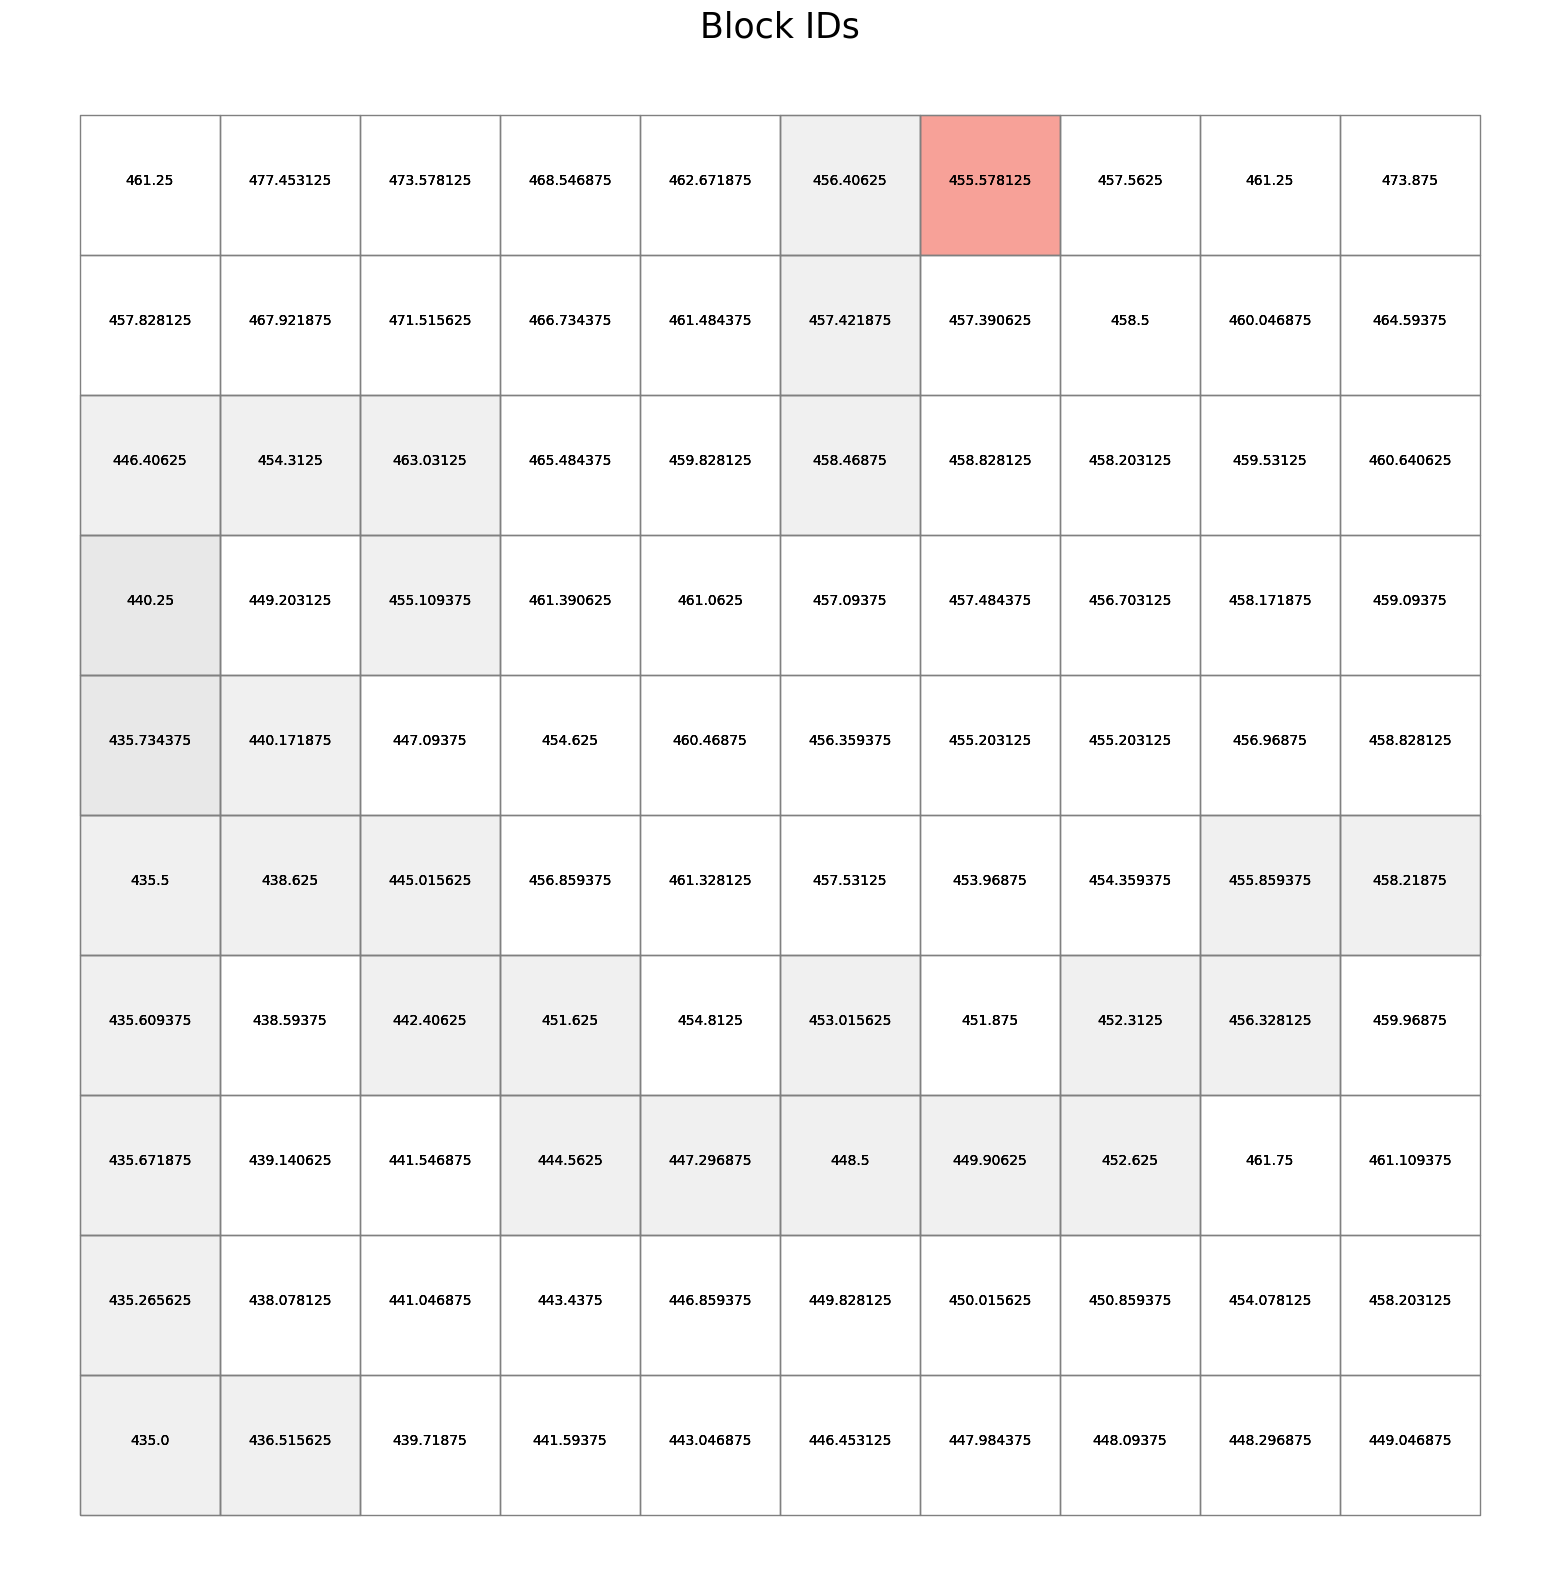

In [199]:
if bool_run_test_data:
    test_blocks_dict, test_pipes_dict = run_topology(
                path = input_path,
                output_path=output_path,
                connectivity=connectivity,
                module=module,
                case_study= case_study, 
                name_blocks=name_blocks,
                name_pipes=name_pipes,               
                year_i = year_i, 
                year_f = year_f, 
                year_step = year_step,
                existing_treatment_id=existing_treatment_id,
                peak_factor=peak_factor,
                return_factor=return_factor,
                L_person_day=L_person_day,  
                scale_factor_PE = scale_factor_PE,
                growth_rate_PE = growth_rate_PE,
                drop=drop,
                verbose=True,
                notify = notify,
                plot = plot)

In [ ]:
if bool_run_test_data:
    display(test_blocks_dict[2018].loc[:,"PE_D"])

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
95    0.0
96    0.0
97    0.0
98    0.0
99    0.0
Name: PE_D, Length: 100, dtype: float64

 Writing file: C:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\Data\data\Case_10_grid\output\figures\topology\centralised\centralised_Case_10_grid_(blocks_['edge', 'HasLake', 'HasRiver', 'has_outlet']__pipes_['type_sewer'])_(2018)


C:\Users\duquevna\AppData\Local\Temp\ipykernel_28152\3402671740.py:97: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


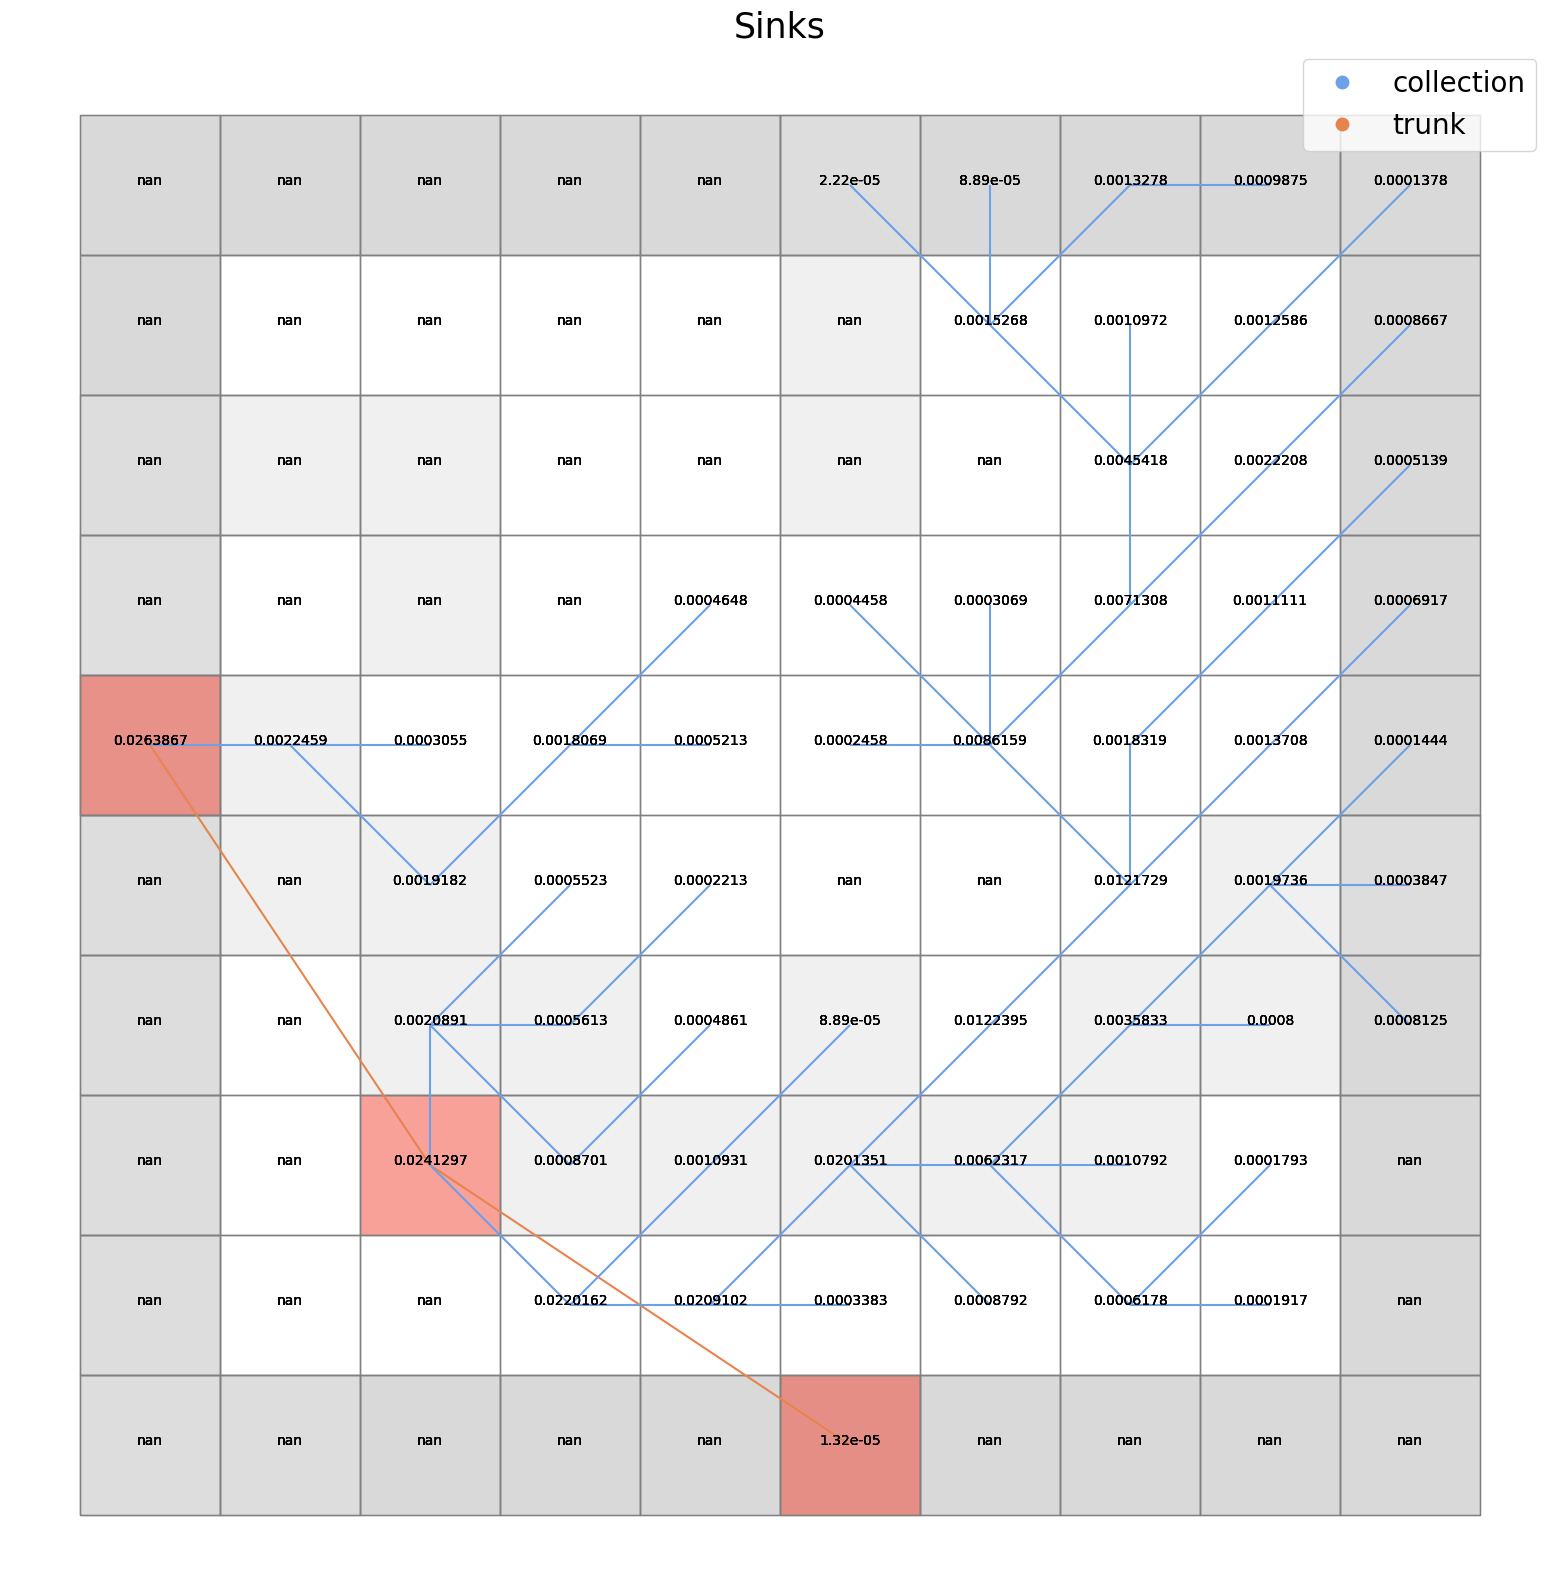

In [ ]:
if bool_run_test_data:
    year=2018
    blocks= test_blocks_dict[year]
    pipes= test_pipes_dict[year]
    plot_blocks_and_pipes_features(blocks, pipes,
                            columns=[ "edge", "HasLake", "HasRiver", "has_outlet"], 
                            columns_p=["type_sewer"], 
                            label="desg_flow",
                            cmaps=[cmap_grey, cmap_lake, cmap_river, cmap_sink],
                            cmap_p=[cmap_blue_orange],
                            title="Sinks", 
                            module=module, connectivity=connectivity, case_study=case_study, year=year, 
                            plot=True, verbose=False)


--------2018 ---------- 
Plotting polygons feature: 'Population' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE873C4F10>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD90>, <matplotlib.collections.PathCollection object at 0x000001AE874F9460>, <matplotlib.collections.PathCollection object at 0x000001AE874DB3A0>, <matplotlib.collections.PathCollection object at 0x000001AE8752B580>, <matplotlib.collections.PathCollection object at 0x000001AE874A48B0>, <matplotlib.collections.PathCollection object at 0x000001AE875372E0>, <matplotlib.collections.PathCollection object at 0x000001AE87537A30>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD00>] ['\nPopulation', '< 0.0', '< 10.7143', '< 50.1429', '< 106.4286', '< 157.2857', '< 204.0', '< 298.8571', '< 486.0']
----------EN OF HANDLES-----------

--------2023 ---------- 
Plotting polygons feature: 'Population' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE873C4F10>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD90>, <matplotlib.collections.PathCollection object at 0x000001AE874F9460>, <matplotlib.collections.PathCollection object at 0x000001AE874DB3A0>, <matplotlib.collections.PathCollection object at 0x000001AE8752B580>, <matplotlib.collections.PathCollection object at 0x000001AE874A48B0>, <matplotlib.collections.PathCollection object at 0x000001AE875372E0>, <matplotlib.collections.PathCollection object at 0x000001AE87537A30>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD00>, <matplotlib.lines.Line2D object at 0x000001AE873C4F10>, <matplotlib.collections.PathCollection object at 0x000001AE87571610>, <matplotlib.collections.PathCollection object at 0x000001AE8759ABB0>, <matplotlib.collections.PathCollection object at 0x000001AE8759F160>, <matplotlib.collections.PathCollection object at 0x000001AE8758C7C0>, <matplotlib.collections.Path

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE873C4F10>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD90>, <matplotlib.collections.PathCollection object at 0x000001AE874F9460>, <matplotlib.collections.PathCollection object at 0x000001AE874DB3A0>, <matplotlib.collections.PathCollection object at 0x000001AE8752B580>, <matplotlib.collections.PathCollection object at 0x000001AE874A48B0>, <matplotlib.collections.PathCollection object at 0x000001AE875372E0>, <matplotlib.collections.PathCollection object at 0x000001AE87537A30>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD00>, <matplotlib.lines.Line2D object at 0x000001AE873C4F10>, <matplotlib.collections.PathCollection object at 0x000001AE87571610>, <matplotlib.collections.PathCollection object at 0x000001AE8759ABB0>, <matplotlib.collections.PathCollection object at 0x000001AE8759F160>, <matplotlib.collections.PathCollection object at 0x000001AE8758C7C0>, <matplotlib.collections.Path

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE873C4F10>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD90>, <matplotlib.collections.PathCollection object at 0x000001AE874F9460>, <matplotlib.collections.PathCollection object at 0x000001AE874DB3A0>, <matplotlib.collections.PathCollection object at 0x000001AE8752B580>, <matplotlib.collections.PathCollection object at 0x000001AE874A48B0>, <matplotlib.collections.PathCollection object at 0x000001AE875372E0>, <matplotlib.collections.PathCollection object at 0x000001AE87537A30>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD00>, <matplotlib.lines.Line2D object at 0x000001AE873C4F10>, <matplotlib.collections.PathCollection object at 0x000001AE87571610>, <matplotlib.collections.PathCollection object at 0x000001AE8759ABB0>, <matplotlib.collections.PathCollection object at 0x000001AE8759F160>, <matplotlib.collections.PathCollection object at 0x000001AE8758C7C0>, <matplotlib.collections.Path

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE873C4F10>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD90>, <matplotlib.collections.PathCollection object at 0x000001AE874F9460>, <matplotlib.collections.PathCollection object at 0x000001AE874DB3A0>, <matplotlib.collections.PathCollection object at 0x000001AE8752B580>, <matplotlib.collections.PathCollection object at 0x000001AE874A48B0>, <matplotlib.collections.PathCollection object at 0x000001AE875372E0>, <matplotlib.collections.PathCollection object at 0x000001AE87537A30>, <matplotlib.collections.PathCollection object at 0x000001AE874EBD00>, <matplotlib.lines.Line2D object at 0x000001AE873C4F10>, <matplotlib.collections.PathCollection object at 0x000001AE87571610>, <matplotlib.collections.PathCollection object at 0x000001AE8759ABB0>, <matplotlib.collections.PathCollection object at 0x000001AE8759F160>, <matplotlib.collections.PathCollection object at 0x000001AE8758C7C0>, <matplotlib.collections.Path

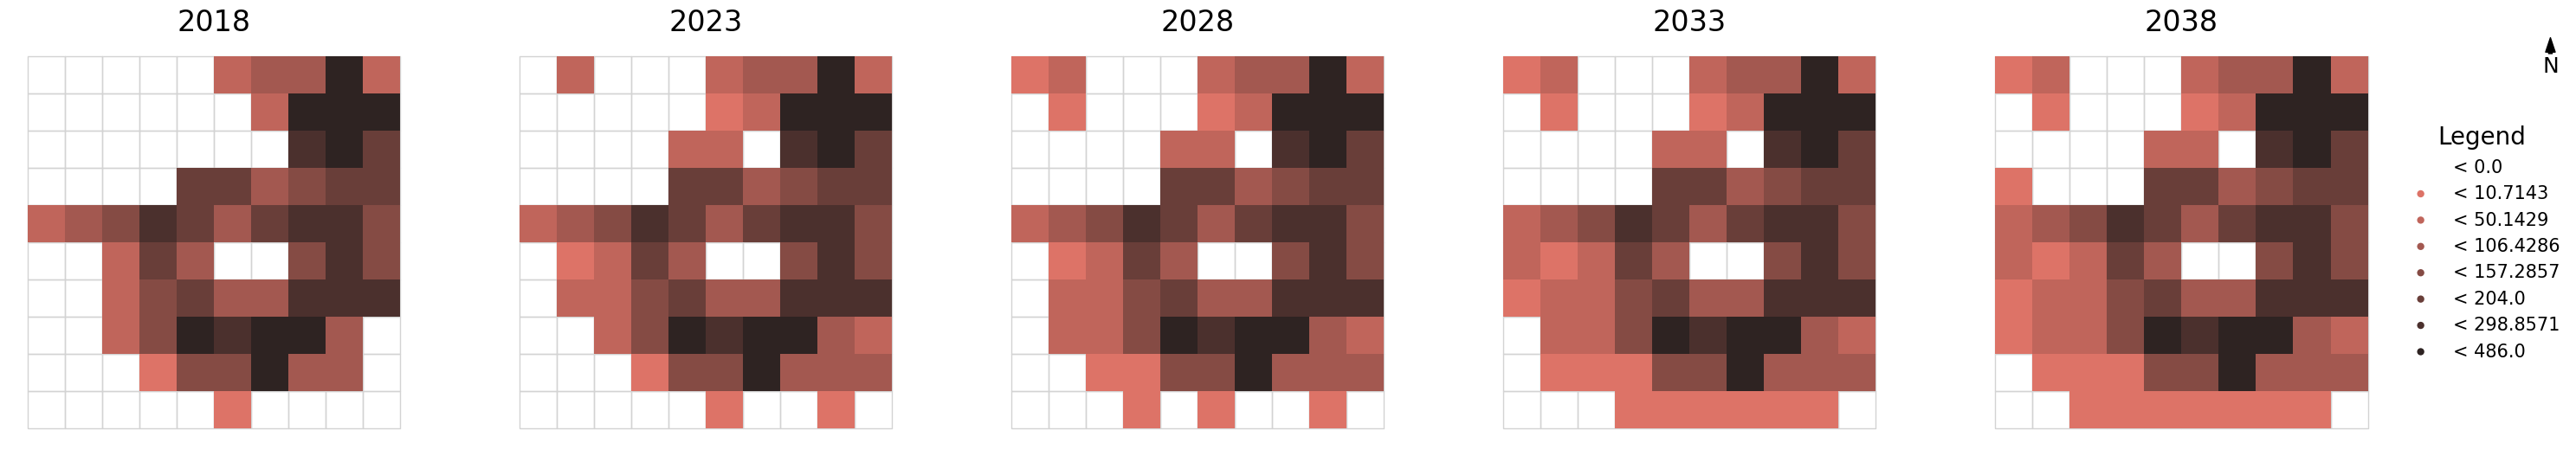

In [ ]:
if bool_run_test_data:
    
    plot_development(poly_dict=test_blocks_dict, 
                    feature_poly="Population", units_poly= '', cmap_poly=cmap_pop,
                    module=module, connectivity=connectivity, case_study=case_study, 
                    backgroud_layers=["Population"], cmap_background_layers=[pl.cm.Greys],
                    path= output_path,
                    plot=plot, verbose=verbose)

In [ ]:
pd_test = pd.DataFrame(test_blocks_dict[2023])
pd_test

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
0       466    None   2900.0   2300.0            [467, 507, 508]     1.0   
1       467    None   3100.0   2300.0  [466, 468, 507, 508, 509]     1.0   
2       468    None   3300.0   2300.0  [467, 469, 508, 509, 510]     1.0   
3       469    None   3500.0   2300.0  [468, 470, 509, 510, 511]     1.0   
4       470    None   3700.0   2300.0  [469, 471, 510, 511, 512]     1.0   
..      ...     ...      ...      ...                        ...     ...   
95      840    None   3900.0   4100.0  [798, 799, 800, 839, 841]     1.0   
96      841    None   4100.0   4100.0  [799, 800, 801, 840, 842]     1.0   
97      842    None   4300.0   4100.0  [800, 801, 802, 841, 843]     1.0   
98      843    None   4500.0   4100.0  [801, 802, 803, 842, 844]     1.0   
99      844    None   4700.0   4100.0            [802, 803, 843]     1.0   

    pLU_RES  pLU_COM  pLU_ORC  pLU_LI  ...     PE_proj    PE_total  pop_D  \
0      0.00      0.0      0.0    0.00  ...    0.000000    0.000000    0.0   
1      0.00      0.0      0.0    0.00  ...    0.000000    0.000000    0.0   
2      0.00      0.0      0.0    0.00  ...    0.000000    0.000000    0.0   
3      0.00      0.0      0.0    0.00  ...    0.000000    0.000000    0.0   
4      0.00      0.0      0.0    0.00  ...    0.000000    0.000000    0.0   
..      ...      ...      ...     ...  ...         ...         ...    ...   
95     0.00      0.0      0.0    0.25  ...   61.113426   61.113426    0.0   
96     0.00      0.0      0.0    1.00  ...  244.453704  244.453704    0.0   
97     0.25      0.5      0.0    0.25  ...  206.867364  662.130722    0.0   
98     1.00      0.0      0.0    0.00  ...  455.263358  455.263358    0.0   
99     0.25      0.0      0.0    0.00  ...   61.556736   61.556736    0.0   

    ww_D  infra_D  wwtp_D  outlet_D  pk_flow_D  PE_D  des_flow_D  
0    0.0      0.0     0.0       0.0        0.0   0.0         0.0  
1    0.0      0.0     0.0       0.0        0.0   0.0         0.0  
2    0.0      0.0     0.0       0.0        0.0   0.0         0.0  
3    0.0      0.0     0.0       0.0        0.0   0.0         0.0  
4    0.0      0.0     0.0       0.0        0.0   0.0         0.0  
..   ...      ...     ...       ...        ...   ...         ...  
95   0.0      0.0     0.0       0.0        0.0   0.0         0.0  
96   0.0      0.0     0.0       0.0        0.0   0.0         0.0  
97   0.0      0.0     0.0       0.0        0.0   0.0         0.0  
98   0.0      0.0     0.0       0.0        0.0   0.0         0.0  
99   0.0      0.0     0.0       0.0        0.0   0.0         0.0  

[100 rows x 219 columns]

[<matplotlib.lines.Line2D object at 0x000001AE873052B0>, <matplotlib.lines.Line2D object at 0x000001AE87305BB0>, <matplotlib.lines.Line2D object at 0x000001AE87305610>, <matplotlib.lines.Line2D object at 0x000001AE87305A90>, <matplotlib.lines.Line2D object at 0x000001AE8E3E6730>, <matplotlib.lines.Line2D object at 0x000001AE8E3E6190>, <matplotlib.lines.Line2D object at 0x000001AE8E3518B0>, <matplotlib.lines.Line2D object at 0x000001AE8E351E50>, <matplotlib.lines.Line2D object at 0x000001AE8E351CD0>, <matplotlib.lines.Line2D object at 0x000001AE8E351040>, <matplotlib.lines.Line2D object at 0x000001AE87305250>, <matplotlib.lines.Line2D object at 0x000001AE8E38CD30>, <matplotlib.lines.Line2D object at 0x000001AE8E38C220>, <matplotlib.lines.Line2D object at 0x000001AE8E38C820>, <matplotlib.lines.Line2D object at 0x000001AE8E3497F0>, <matplotlib.lines.Line2D object at 0x000001AE8E349A60>, <matplotlib.lines.Line2D object at 0x000001AE8E349B20>, <matplotlib.lines.Line2D object at 0x000001AE8E

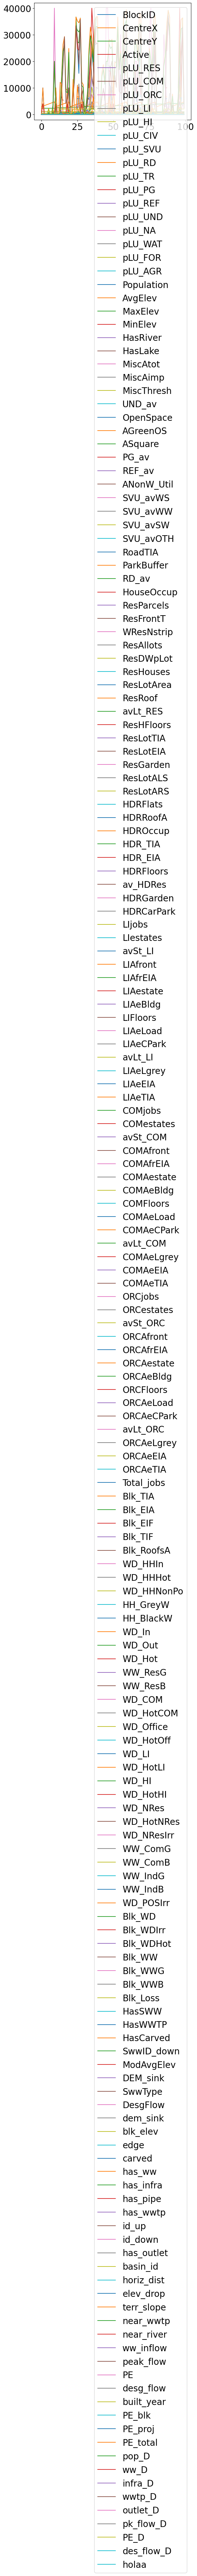

In [ ]:
fig , axs = plt.subplots()
# a = pd_test.loc[:,"Population"].plot(ax=axs, legend=True)
a = pd_test.plot(ax=axs, column="Population", legend=True)

handles, labels = axs.get_legend_handles_labels()
print (handles)
handles.append(handles[-1])
labels.append("holaa")
print (labels)

axs.legend(handles=handles, labels=labels)


In [ ]:
# Find test data by year
if bool_run_test_data:
    path = output_path
    # data_dir = os.listdir(path_out)
    # print(data_dir)
    year=2018
    # for idx, dd in enumerate(data_dir):
    for x in path.iterdir():
        if x.is_dir():
            
            bb = "blocks" in x.name
            yy = f"{year}" in x.name
            
            # print(bb, yy)
            if bb and yy:
                print(x.name)
                for y in x.iterdir():
                    if y.is_file() and "shp" in y.name:
                        print(y)


--------2018 ---------- 
Plotting polygons feature: 'has_ww' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8E3BB700>, <matplotlib.collections.PathCollection object at 0x000001AE8745FF10>] ['\nhas_ww', '0.0', 'has_ww']
----------EN OF HANDLES-----------

--------2023 ---------- 
Plotting polygons feature: 'has_ww' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8E3BB700>, <matplotlib.collections.PathCollection object at 0x000001AE8745FF10>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8736A550>, <matplotlib.collections.PathCollection object at 0x000001AE87450400>] ['\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww']
----------EN OF HANDLES-----------

--------2028 ---------- 
Plotting polygons feature: 'has_ww' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8E3BB700>, <matplotlib.collections.PathCollection object at 0x000001AE8745FF10>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8736A550>, <matplotlib.collections.PathCollection object at 0x000001AE87450400>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE87362880>, <matplotlib.collections.PathCollection object at 0x000001AE87358070>] ['\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww']
----------EN OF HANDLES-----------

--------2033 ---------- 
Plotting polygons feature: 'has_ww' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8E3BB700>, <matplotlib.collections.PathCollection object at 0x000001AE8745FF10>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8736A550>, <matplotlib.collections.PathCollection object at 0x000001AE87450400>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE87362880>, <matplotlib.collections.PathCollection object at 0x000001AE87358070>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8745A760>, <matplotlib.collections.PathCollection object at 0x000001AE8755C1C0>] ['\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww']
----------EN OF HANDLES-----------

--------2038 ---------- 
Plotting polygons 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8E3BB700>, <matplotlib.collections.PathCollection object at 0x000001AE8745FF10>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8736A550>, <matplotlib.collections.PathCollection object at 0x000001AE87450400>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE87362880>, <matplotlib.collections.PathCollection object at 0x000001AE87358070>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE8745A760>, <matplotlib.collections.PathCollection object at 0x000001AE8755C1C0>, <matplotlib.lines.Line2D object at 0x000001AE8E39AD30>, <matplotlib.collections.PathCollection object at 0x000001AE875E49D0>, <matplotlib.collections.PathCollection object at 0x000001AE875DAA30>] 

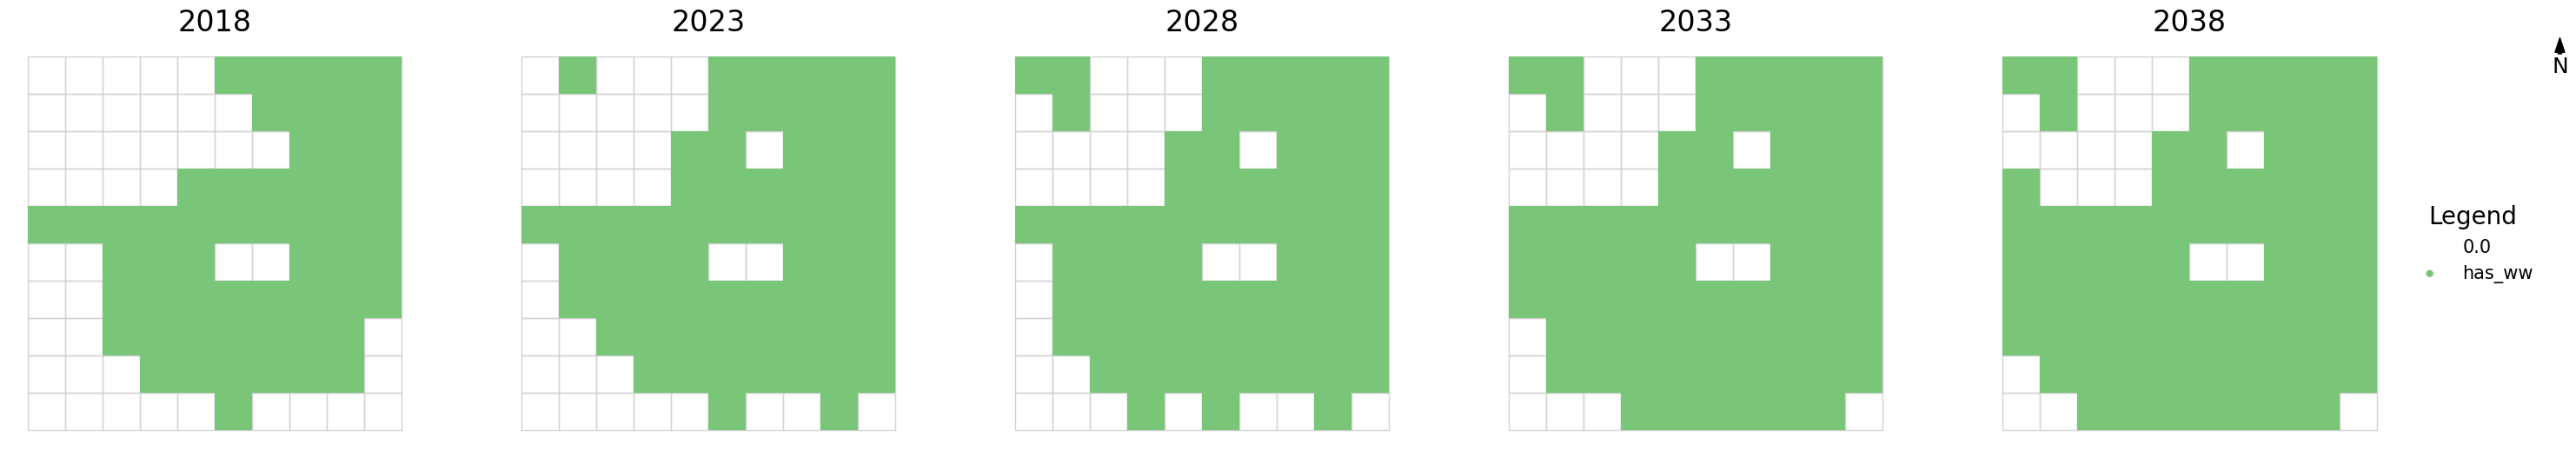

In [ ]:
if bool_run_test_data:
    plot_development(test_blocks_dict, 
                        #   poly_label="BlockID", 
                        feature_poly = "has_ww", units_poly = "", cmap_poly= pl.cm.YlGn_r,
                        module=module, connectivity=connectivity, case_study=case_study,
                        path=output_path, 
                        plot=plot, verbose=verbose)

In [ ]:
if bool_run_test_data:
    blocks=test_blocks_dict[2023]
    display(blocks.loc[:,["type_sewer", "has_ww", "has_infra", "has_wwtp", "has_pipe", "built_year"]])

type_sewer  has_ww  has_infra  has_wwtp  has_pipe  built_year
0          0.0     0.0        0.0       0.0       0.0         0.0
1          0.0     0.0        0.0       0.0       0.0         0.0
2          0.0     0.0        0.0       0.0       0.0         0.0
3          0.0     0.0        0.0       0.0       0.0         0.0
4          0.0     0.0        0.0       0.0       0.0         0.0
..         ...     ...        ...       ...       ...         ...
95  collection     1.0        1.0       0.0       1.0      2018.0
96  collection     1.0        1.0       0.0       1.0      2018.0
97  collection     1.0        1.0       0.0       1.0      2018.0
98  collection     1.0        1.0       0.0       1.0      2018.0
99  collection     1.0        1.0       0.0       1.0      2018.0

[100 rows x 6 columns]

In [ ]:
# check type of variable
if bool_run_test_data:
    clases = pd.unique(blocks["type_sewer"].values.ravel('K'))[1:]
    bool_int_variable = type(clases[0]) is str
    print(bool_int_variable)

True



--------2018 ---------- 
Plotting polygons feature: 'has_ww' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE85185400>, <matplotlib.collections.PathCollection object at 0x000001AE85185A30>] ['\nhas_ww', '0.0', 'has_ww']
----------EN OF HANDLES-----------

Plotting pipes 'built_year' ...

--------2023 ---------- 
Plotting polygons feature: 'has_ww' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE85185400>, <matplotlib.collections.PathCollection object at 0x000001AE85185A30>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE85119DC0>, <matplotlib.collections.PathCollection object at 0x000001AE851419A0>] ['\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww']
----------EN OF HANDLES-----------

Plotting pipes 'built_year' ...

--------2028 ---------- 
Plotting polygons feature: 'has_ww' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE85185400>, <matplotlib.collections.PathCollection object at 0x000001AE85185A30>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE85119DC0>, <matplotlib.collections.PathCollection object at 0x000001AE851419A0>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE873D7220>, <matplotlib.collections.PathCollection object at 0x000001AE873D7D60>] ['\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww']
----------EN OF HANDLES-----------

Plotting pipes 'built_year' ...

--------2033 ---------- 
Plotting polygons feature: 'has_ww' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE85185400>, <matplotlib.collections.PathCollection object at 0x000001AE85185A30>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE85119DC0>, <matplotlib.collections.PathCollection object at 0x000001AE851419A0>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE873D7220>, <matplotlib.collections.PathCollection object at 0x000001AE873D7D60>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE8518DAC0>, <matplotlib.collections.PathCollection object at 0x000001AE850D9D00>] ['\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww', '\nhas_ww', '0.0', 'has_ww']
----------EN OF HANDLES-----------

Plotting pipes 'built_year' ...

--------20

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE85185400>, <matplotlib.collections.PathCollection object at 0x000001AE85185A30>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE85119DC0>, <matplotlib.collections.PathCollection object at 0x000001AE851419A0>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE873D7220>, <matplotlib.collections.PathCollection object at 0x000001AE873D7D60>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE8518DAC0>, <matplotlib.collections.PathCollection object at 0x000001AE850D9D00>, <matplotlib.lines.Line2D object at 0x000001AE87617C40>, <matplotlib.collections.PathCollection object at 0x000001AE87391B80>, <matplotlib.collections.PathCollection object at 0x000001AE85497B20>] 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


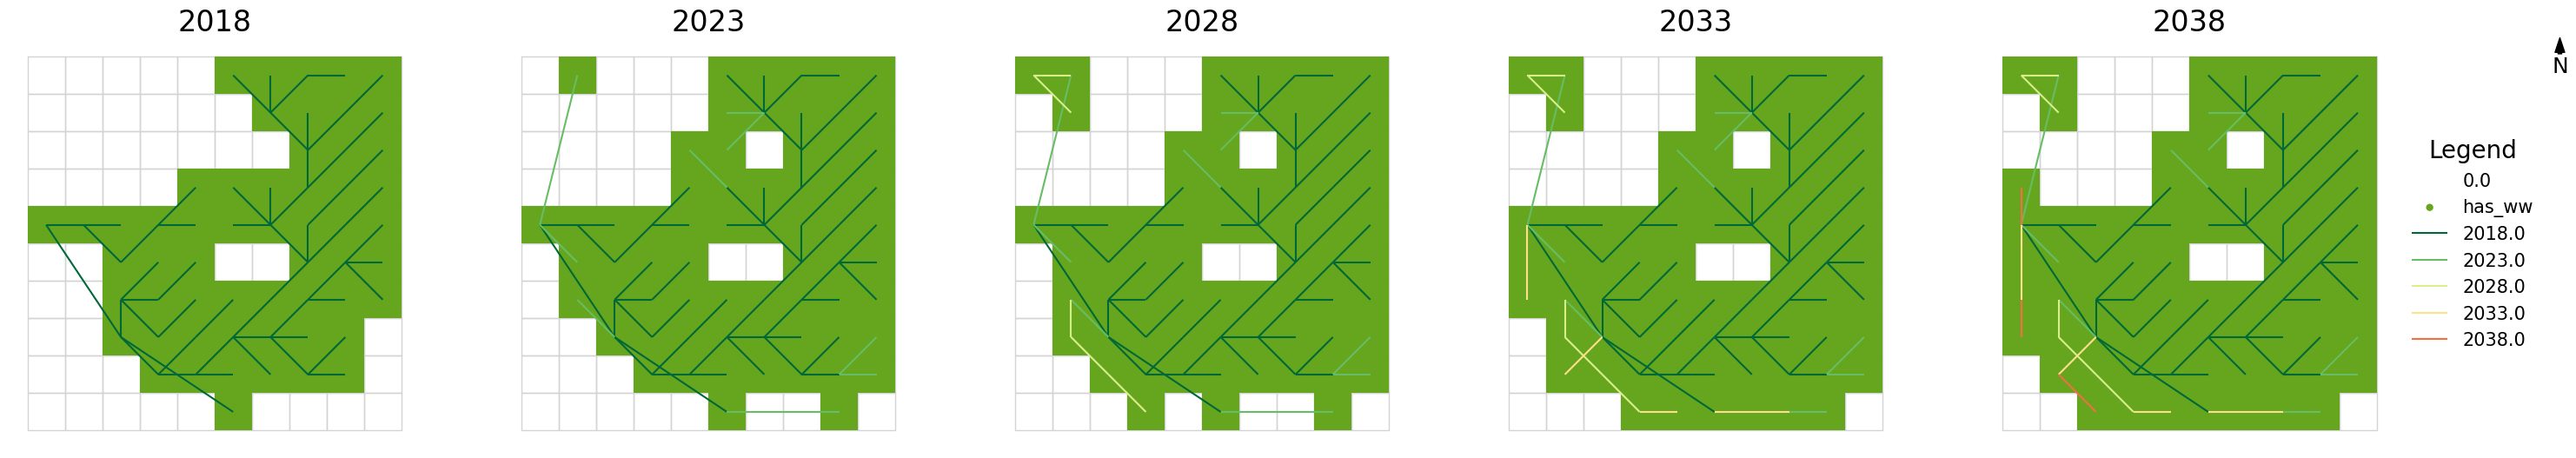

In [ ]:
if bool_run_test_data:
    plot_development(poly_dict=test_blocks_dict, lineStr_dict=test_pipes_dict, 
                feature_poly="has_ww", units_poly = "[type]", cmap_poly= pl.cm.Dark2,
                feature_lineStr='built_year', units_lineStr = "[year]", cmap_lineStr=pl.cm.RdYlGn_r,
                module=module, connectivity=connectivity, case_study=case_study, 
                path=output_path, 
                plot=plot, verbose=verbose,
                )

In [ ]:
new_columns = ["pop_D",         # float: population delta
                "ww_D",         # int: 1: new blocks with wastewater coverage
                "infra_D",      # int: 1: new blocks with infrastructure (pipes, wwtp) 
                # "wwtp_D",       # int: 1: new blocks with (small or large) wwtp 
                "outlet_D",     # int: 1: new blocks with outlets of subcachments
                "pk_flow_D",    # float: new flow coming from the peak flow in the block
                "PE_D",         # float: new PE coming from the peak flow in the block
                "des_flow_D",   # float: new flow coming from the (cumulative) design flow for the block
                ]

In [ ]:
test_blocks_dict[2018].loc[:, new_columns]

pop_D  ww_D  infra_D  outlet_D  pk_flow_D  PE_D  des_flow_D
0     0.0   0.0      0.0       0.0        0.0   0.0         0.0
1     0.0   0.0      0.0       0.0        0.0   0.0         0.0
2     0.0   0.0      0.0       0.0        0.0   0.0         0.0
3     0.0   0.0      0.0       0.0        0.0   0.0         0.0
4     0.0   0.0      0.0       0.0        0.0   0.0         0.0
..    ...   ...      ...       ...        ...   ...         ...
95    0.0   0.0      0.0       0.0        0.0   0.0         0.0
96    0.0   0.0      0.0       0.0        0.0   0.0         0.0
97    0.0   0.0      0.0       0.0        0.0   0.0         0.0
98    0.0   0.0      0.0       0.0        0.0   0.0         0.0
99    0.0   0.0      0.0       0.0        0.0   0.0         0.0

[100 rows x 7 columns]

pop_D

--------2018 ---------- 
Plotting polygons feature: 'pop_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE855AAFD0>] ['\npop_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2023 ---------- 
Plotting polygons feature: 'pop_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.collections.PathCollection object at 0x000001AE8581C0A0>, <matplotlib.collections.PathCollection object at 0x000001AE85735E20>, <matplotlib.collections.PathCollection object at 0x000001AE857DDBE0>, <matplotlib.collections.PathCollection object at 0x000001AE857B7820>, <matplotlib.collections.PathCollection object at 0x000001AE85819970>, <matplotlib.collections.PathCollection object at 0x000001AE8585F0D0>] ['\npop_D', '\npop_D', '< 0.0', '< 8.0', '< 10.0', '< 12.0', '< 42.0', '< 53.0']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2028 ---------- 
Plotting polygons feature: 'pop_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.collections.PathCollection object at 0x000001AE8581C0A0>, <matplotlib.collections.PathCollection object at 0x000001AE85735E20>, <matplotlib.collections.PathCollection object at 0x000001AE857DDBE0>, <matplotlib.collections.PathCollection object at 0x000001AE857B7820>, <matplotlib.collections.PathCollection object at 0x000001AE85819970>, <matplotlib.collections.PathCollection object at 0x000001AE8585F0D0>, <matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.collections.PathCollection object at 0x000001AE858CCC10>, <matplotlib.collections.PathCollection object at 0x000001AE86D09A00>, <matplotlib.collections.PathCollection object at 0x000001AE86D17790>, <matplotlib.collections.PathCollection object at 0x000001AE858A13D0>, <matplotlib.collections.PathCollection object at 0x000001AE857EA820>] ['\npop_D', '\npop_D', '< 0.0', '< 8.0', '

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.collections.PathCollection object at 0x000001AE8581C0A0>, <matplotlib.collections.PathCollection object at 0x000001AE85735E20>, <matplotlib.collections.PathCollection object at 0x000001AE857DDBE0>, <matplotlib.collections.PathCollection object at 0x000001AE857B7820>, <matplotlib.collections.PathCollection object at 0x000001AE85819970>, <matplotlib.collections.PathCollection object at 0x000001AE8585F0D0>, <matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.collections.PathCollection object at 0x000001AE858CCC10>, <matplotlib.collections.PathCollection object at 0x000001AE86D09A00>, <matplotlib.collections.PathCollection object at 0x000001AE86D17790>, <matplotlib.collections.PathCollection object at 0x000001AE858A13D0>, <matplotlib.collections.PathCollection object at 0x000001AE857EA820>, <matplotlib.lines.Line2D object at 0x00000

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.collections.PathCollection object at 0x000001AE8581C0A0>, <matplotlib.collections.PathCollection object at 0x000001AE85735E20>, <matplotlib.collections.PathCollection object at 0x000001AE857DDBE0>, <matplotlib.collections.PathCollection object at 0x000001AE857B7820>, <matplotlib.collections.PathCollection object at 0x000001AE85819970>, <matplotlib.collections.PathCollection object at 0x000001AE8585F0D0>, <matplotlib.lines.Line2D object at 0x000001AE855AAFD0>, <matplotlib.collections.PathCollection object at 0x000001AE858CCC10>, <matplotlib.collections.PathCollection object at 0x000001AE86D09A00>, <matplotlib.collections.PathCollection object at 0x000001AE86D17790>, <matplotlib.collections.PathCollection object at 0x000001AE858A13D0>, <matplotlib.collections.PathCollection object at 0x000001AE857EA820>, <matplotlib.lines.Line2D object at 0x00000

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE854B9C40>] ['\nww_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2023 ---------- 
Plotting polygons feature: 'ww_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE8759FD30>, <matplotlib.collections.PathCollection object at 0x000001AE87556A00>] ['\nww_D', '\nww_D', '0.0', 'ww_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2028 ---------- 
Plotting polygons feature: 'ww_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE8759FD30>, <matplotlib.collections.PathCollection object at 0x000001AE87556A00>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE8758C760>, <matplotlib.collections.PathCollection object at 0x000001AE872D6490>] ['\nww_D', '\nww_D', '0.0', 'ww_D', '\nww_D', '0.0', 'ww_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2033 ---------- 
Plotting polygons feature: 'ww_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE8759FD30>, <matplotlib.collections.PathCollection object at 0x000001AE87556A00>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE8758C760>, <matplotlib.collections.PathCollection object at 0x000001AE872D6490>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE874F9B80>, <matplotlib.collections.PathCollection object at 0x000001AE87408850>] ['\nww_D', '\nww_D', '0.0', 'ww_D', '\nww_D', '0.0', 'ww_D', '\nww_D', '0.0', 'ww_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2038 ---------- 
Plotting polygons feature: 'ww_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE8759FD30>, <matplotlib.collections.PathCollection object at 0x000001AE87556A00>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE8758C760>, <matplotlib.collections.PathCollection object at 0x000001AE872D6490>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE874F9B80>, <matplotlib.collections.PathCollection object at 0x000001AE87408850>, <matplotlib.lines.Line2D object at 0x000001AE854B9C40>, <matplotlib.collections.PathCollection object at 0x000001AE87606B50>, <matplotlib.collections.PathCollection object at 0x000001AE87632BE0>] ['\nww_D', '\nww_D', '0.0', 'ww_D', '\nww_D', '0.0', 'ww_D', '\nww_D', '0.0', 'ww_D', '\nww_D', '0.0', 'ww_D']
----------EN OF HANDLES------

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87470760>] ['\ninfra_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2023 ---------- 
Plotting polygons feature: 'infra_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE8761EE80>, <matplotlib.collections.PathCollection object at 0x000001AE876220A0>] ['\ninfra_D', '\ninfra_D', '0.0', 'infra_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2028 ---------- 
Plotting polygons feature: 'infra_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE8761EE80>, <matplotlib.collections.PathCollection object at 0x000001AE876220A0>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE86DA3E20>, <matplotlib.collections.PathCollection object at 0x000001AE86DB3FA0>] ['\ninfra_D', '\ninfra_D', '0.0', 'infra_D', '\ninfra_D', '0.0', 'infra_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2033 ---------- 
Plotting polygons feature: 'infra_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE8761EE80>, <matplotlib.collections.PathCollection object at 0x000001AE876220A0>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE86DA3E20>, <matplotlib.collections.PathCollection object at 0x000001AE86DB3FA0>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE849C0520>, <matplotlib.collections.PathCollection object at 0x000001AE849C9940>] ['\ninfra_D', '\ninfra_D', '0.0', 'infra_D', '\ninfra_D', '0.0', 'infra_D', '\ninfra_D', '0.0', 'infra_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2038 ---------- 
Plotting polygons feature: 'infra_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE8761EE80>, <matplotlib.collections.PathCollection object at 0x000001AE876220A0>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE86DA3E20>, <matplotlib.collections.PathCollection object at 0x000001AE86DB3FA0>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE849C0520>, <matplotlib.collections.PathCollection object at 0x000001AE849C9940>, <matplotlib.lines.Line2D object at 0x000001AE87470760>, <matplotlib.collections.PathCollection object at 0x000001AE849D42E0>, <matplotlib.collections.PathCollection object at 0x000001AE86DBBB20>] ['\ninfra_D', '\ninfra_D', '0.0', 'infra_D', '\ninfra_D', '0.0', 'infra_D', '\ninfra_D', '0.0', 'infra_D', '\ninfra_D', '0.0', 'infra_D']
--

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


outlet_D

--------2018 ---------- 
Plotting polygons feature: 'outlet_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84B21E80>] ['\noutlet_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2023 ---------- 
Plotting polygons feature: 'outlet_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.collections.PathCollection object at 0x000001AE84C5ED90>, <matplotlib.collections.PathCollection object at 0x000001AE84C904C0>] ['\noutlet_D', '\noutlet_D', '0.0', 'outlet_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2028 ---------- 
Plotting polygons feature: 'outlet_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.collections.PathCollection object at 0x000001AE84C5ED90>, <matplotlib.collections.PathCollection object at 0x000001AE84C904C0>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.collections.PathCollection object at 0x000001AE84CF8CA0>, <matplotlib.collections.PathCollection object at 0x000001AE84D09C40>] ['\noutlet_D', '\noutlet_D', '0.0', 'outlet_D', '\noutlet_D', '0.0', 'outlet_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2033 ---------- 
Plotting polygons feature: 'outlet_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.collections.PathCollection object at 0x000001AE84C5ED90>, <matplotlib.collections.PathCollection object at 0x000001AE84C904C0>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.collections.PathCollection object at 0x000001AE84CF8CA0>, <matplotlib.collections.PathCollection object at 0x000001AE84D09C40>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.collections.PathCollection object at 0x000001AE84D4C640>, <matplotlib.collections.PathCollection object at 0x000001AE84D58310>] ['\noutlet_D', '\noutlet_D', '0.0', 'outlet_D', '\noutlet_D', '0.0', 'outlet_D', '\noutlet_D', '0.0', 'outlet_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2038 ---------- 
Plotting polygons feature: 'outlet_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.collections.PathCollection object at 0x000001AE84C5ED90>, <matplotlib.collections.PathCollection object at 0x000001AE84C904C0>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.collections.PathCollection object at 0x000001AE84CF8CA0>, <matplotlib.collections.PathCollection object at 0x000001AE84D09C40>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>, <matplotlib.collections.PathCollection object at 0x000001AE84D4C640>, <matplotlib.collections.PathCollection object at 0x000001AE84D58310>, <matplotlib.lines.Line2D object at 0x000001AE84B21E80>] ['\noutlet_D', '\noutlet_D', '0.0', 'outlet_D', '\noutlet_D', '0.0', 'outlet_D', '\noutlet_D', '0.0', 'outlet_D', '\noutlet_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes
[1, 2, 3, 4, 5]
['a', 'b', 'c', 'd', 'e']
[<matplotlib.c

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE872CE9A0>] ['\npk_flow_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2023 ---------- 
Plotting polygons feature: 'pk_flow_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.collections.PathCollection object at 0x000001AE84F374C0>, <matplotlib.collections.PathCollection object at 0x000001AE84F41B50>, <matplotlib.collections.PathCollection object at 0x000001AE84F47730>, <matplotlib.collections.PathCollection object at 0x000001AE84F52670>, <matplotlib.collections.PathCollection object at 0x000001AE84F09FD0>, <matplotlib.collections.PathCollection object at 0x000001AE84F5F0A0>] ['\npk_flow_D', '\npk_flow_D', '< 0.0', '< 0.0', '< 0.0', '< 0.0', '< 0.0', '< 0.0002']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2028 ---------- 
Plotting polygons feature: 'pk_flow_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.collections.PathCollection object at 0x000001AE84F374C0>, <matplotlib.collections.PathCollection object at 0x000001AE84F41B50>, <matplotlib.collections.PathCollection object at 0x000001AE84F47730>, <matplotlib.collections.PathCollection object at 0x000001AE84F52670>, <matplotlib.collections.PathCollection object at 0x000001AE84F09FD0>, <matplotlib.collections.PathCollection object at 0x000001AE84F5F0A0>, <matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.collections.PathCollection object at 0x000001AE86DE7490>, <matplotlib.collections.PathCollection object at 0x000001AE86E07340>, <matplotlib.collections.PathCollection object at 0x000001AE84E8E790>, <matplotlib.collections.PathCollection object at 0x000001AE86E29310>, <matplotlib.collections.PathCollection object at 0x000001AE86E31040>] ['\npk_flow_D', '\npk_flow_D', '< 0.0', '<

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.collections.PathCollection object at 0x000001AE84F374C0>, <matplotlib.collections.PathCollection object at 0x000001AE84F41B50>, <matplotlib.collections.PathCollection object at 0x000001AE84F47730>, <matplotlib.collections.PathCollection object at 0x000001AE84F52670>, <matplotlib.collections.PathCollection object at 0x000001AE84F09FD0>, <matplotlib.collections.PathCollection object at 0x000001AE84F5F0A0>, <matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.collections.PathCollection object at 0x000001AE86DE7490>, <matplotlib.collections.PathCollection object at 0x000001AE86E07340>, <matplotlib.collections.PathCollection object at 0x000001AE84E8E790>, <matplotlib.collections.PathCollection object at 0x000001AE86E29310>, <matplotlib.collections.PathCollection object at 0x000001AE86E31040>, <matplotlib.lines.Line2D object at 0x00000

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.collections.PathCollection object at 0x000001AE84F374C0>, <matplotlib.collections.PathCollection object at 0x000001AE84F41B50>, <matplotlib.collections.PathCollection object at 0x000001AE84F47730>, <matplotlib.collections.PathCollection object at 0x000001AE84F52670>, <matplotlib.collections.PathCollection object at 0x000001AE84F09FD0>, <matplotlib.collections.PathCollection object at 0x000001AE84F5F0A0>, <matplotlib.lines.Line2D object at 0x000001AE872CE9A0>, <matplotlib.collections.PathCollection object at 0x000001AE86DE7490>, <matplotlib.collections.PathCollection object at 0x000001AE86E07340>, <matplotlib.collections.PathCollection object at 0x000001AE84E8E790>, <matplotlib.collections.PathCollection object at 0x000001AE86E29310>, <matplotlib.collections.PathCollection object at 0x000001AE86E31040>, <matplotlib.lines.Line2D object at 0x00000

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


PE_D

--------2018 ---------- 
Plotting polygons feature: 'PE_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE870017C0>] ['\nPE_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2023 ---------- 
Plotting polygons feature: 'PE_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.collections.PathCollection object at 0x000001AE87174340>, <matplotlib.collections.PathCollection object at 0x000001AE87174D60>, <matplotlib.collections.PathCollection object at 0x000001AE87180E80>, <matplotlib.collections.PathCollection object at 0x000001AE87167610>, <matplotlib.collections.PathCollection object at 0x000001AE8718F700>, <matplotlib.collections.PathCollection object at 0x000001AE8718F460>, <matplotlib.collections.PathCollection object at 0x000001AE8719A6D0>, <matplotlib.collections.PathCollection object at 0x000001AE870E1AC0>] ['\nPE_D', '\nPE_D', '< 0.0', '< 0.0238', '< 0.0365', '< 0.3972', '< 1.9123', '< 5.7298', '< 17.2212', '< 138.8985']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2028 ---------- 
Plotting polygons feature: 'PE_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.collections.PathCollection object at 0x000001AE87174340>, <matplotlib.collections.PathCollection object at 0x000001AE87174D60>, <matplotlib.collections.PathCollection object at 0x000001AE87180E80>, <matplotlib.collections.PathCollection object at 0x000001AE87167610>, <matplotlib.collections.PathCollection object at 0x000001AE8718F700>, <matplotlib.collections.PathCollection object at 0x000001AE8718F460>, <matplotlib.collections.PathCollection object at 0x000001AE8719A6D0>, <matplotlib.collections.PathCollection object at 0x000001AE870E1AC0>, <matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.collections.PathCollection object at 0x000001AE8719A070>, <matplotlib.collections.PathCollection object at 0x000001AE871EB580>, <matplotlib.collections.PathCollection object at 0x000001AE87209430>, <matplotlib.collections.PathCollection obj

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.collections.PathCollection object at 0x000001AE87174340>, <matplotlib.collections.PathCollection object at 0x000001AE87174D60>, <matplotlib.collections.PathCollection object at 0x000001AE87180E80>, <matplotlib.collections.PathCollection object at 0x000001AE87167610>, <matplotlib.collections.PathCollection object at 0x000001AE8718F700>, <matplotlib.collections.PathCollection object at 0x000001AE8718F460>, <matplotlib.collections.PathCollection object at 0x000001AE8719A6D0>, <matplotlib.collections.PathCollection object at 0x000001AE870E1AC0>, <matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.collections.PathCollection object at 0x000001AE8719A070>, <matplotlib.collections.PathCollection object at 0x000001AE871EB580>, <matplotlib.collections.PathCollection object at 0x000001AE87209430>, <matplotlib.collections.PathCollection obj

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.collections.PathCollection object at 0x000001AE87174340>, <matplotlib.collections.PathCollection object at 0x000001AE87174D60>, <matplotlib.collections.PathCollection object at 0x000001AE87180E80>, <matplotlib.collections.PathCollection object at 0x000001AE87167610>, <matplotlib.collections.PathCollection object at 0x000001AE8718F700>, <matplotlib.collections.PathCollection object at 0x000001AE8718F460>, <matplotlib.collections.PathCollection object at 0x000001AE8719A6D0>, <matplotlib.collections.PathCollection object at 0x000001AE870E1AC0>, <matplotlib.lines.Line2D object at 0x000001AE870017C0>, <matplotlib.collections.PathCollection object at 0x000001AE8719A070>, <matplotlib.collections.PathCollection object at 0x000001AE871EB580>, <matplotlib.collections.PathCollection object at 0x000001AE87209430>, <matplotlib.collections.PathCollection obj

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


des_flow_D

--------2018 ---------- 
Plotting polygons feature: 'des_flow_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE877FAD30>] ['\ndes_flow_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2023 ---------- 
Plotting polygons feature: 'des_flow_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.collections.PathCollection object at 0x000001AE87967520>, <matplotlib.collections.PathCollection object at 0x000001AE87975EE0>, <matplotlib.collections.PathCollection object at 0x000001AE8797D4F0>, <matplotlib.collections.PathCollection object at 0x000001AE87959CA0>, <matplotlib.collections.PathCollection object at 0x000001AE8797DEE0>, <matplotlib.collections.PathCollection object at 0x000001AE87990670>, <matplotlib.collections.PathCollection object at 0x000001AE8799B100>, <matplotlib.collections.PathCollection object at 0x000001AE878AEFA0>] ['\ndes_flow_D', '\ndes_flow_D', '< 0.0', '< 0.0', '< 0.0', '< 0.0012', '< 0.0117', '< 0.0463', '< 0.694', '< 2.7872']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2028 ---------- 
Plotting polygons feature: 'des_flow_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.collections.PathCollection object at 0x000001AE87967520>, <matplotlib.collections.PathCollection object at 0x000001AE87975EE0>, <matplotlib.collections.PathCollection object at 0x000001AE8797D4F0>, <matplotlib.collections.PathCollection object at 0x000001AE87959CA0>, <matplotlib.collections.PathCollection object at 0x000001AE8797DEE0>, <matplotlib.collections.PathCollection object at 0x000001AE87990670>, <matplotlib.collections.PathCollection object at 0x000001AE8799B100>, <matplotlib.collections.PathCollection object at 0x000001AE878AEFA0>, <matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.collections.PathCollection object at 0x000001AE878A55B0>, <matplotlib.collections.PathCollection object at 0x000001AE879599A0>, <matplotlib.collections.PathCollection object at 0x000001AE879FAD00>, <matplotlib.collections.PathCollection obj

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.collections.PathCollection object at 0x000001AE87967520>, <matplotlib.collections.PathCollection object at 0x000001AE87975EE0>, <matplotlib.collections.PathCollection object at 0x000001AE8797D4F0>, <matplotlib.collections.PathCollection object at 0x000001AE87959CA0>, <matplotlib.collections.PathCollection object at 0x000001AE8797DEE0>, <matplotlib.collections.PathCollection object at 0x000001AE87990670>, <matplotlib.collections.PathCollection object at 0x000001AE8799B100>, <matplotlib.collections.PathCollection object at 0x000001AE878AEFA0>, <matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.collections.PathCollection object at 0x000001AE878A55B0>, <matplotlib.collections.PathCollection object at 0x000001AE879599A0>, <matplotlib.collections.PathCollection object at 0x000001AE879FAD00>, <matplotlib.collections.PathCollection obj

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.collections.PathCollection object at 0x000001AE87967520>, <matplotlib.collections.PathCollection object at 0x000001AE87975EE0>, <matplotlib.collections.PathCollection object at 0x000001AE8797D4F0>, <matplotlib.collections.PathCollection object at 0x000001AE87959CA0>, <matplotlib.collections.PathCollection object at 0x000001AE8797DEE0>, <matplotlib.collections.PathCollection object at 0x000001AE87990670>, <matplotlib.collections.PathCollection object at 0x000001AE8799B100>, <matplotlib.collections.PathCollection object at 0x000001AE878AEFA0>, <matplotlib.lines.Line2D object at 0x000001AE877FAD30>, <matplotlib.collections.PathCollection object at 0x000001AE878A55B0>, <matplotlib.collections.PathCollection object at 0x000001AE879599A0>, <matplotlib.collections.PathCollection object at 0x000001AE879FAD00>, <matplotlib.collections.PathCollection obj

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


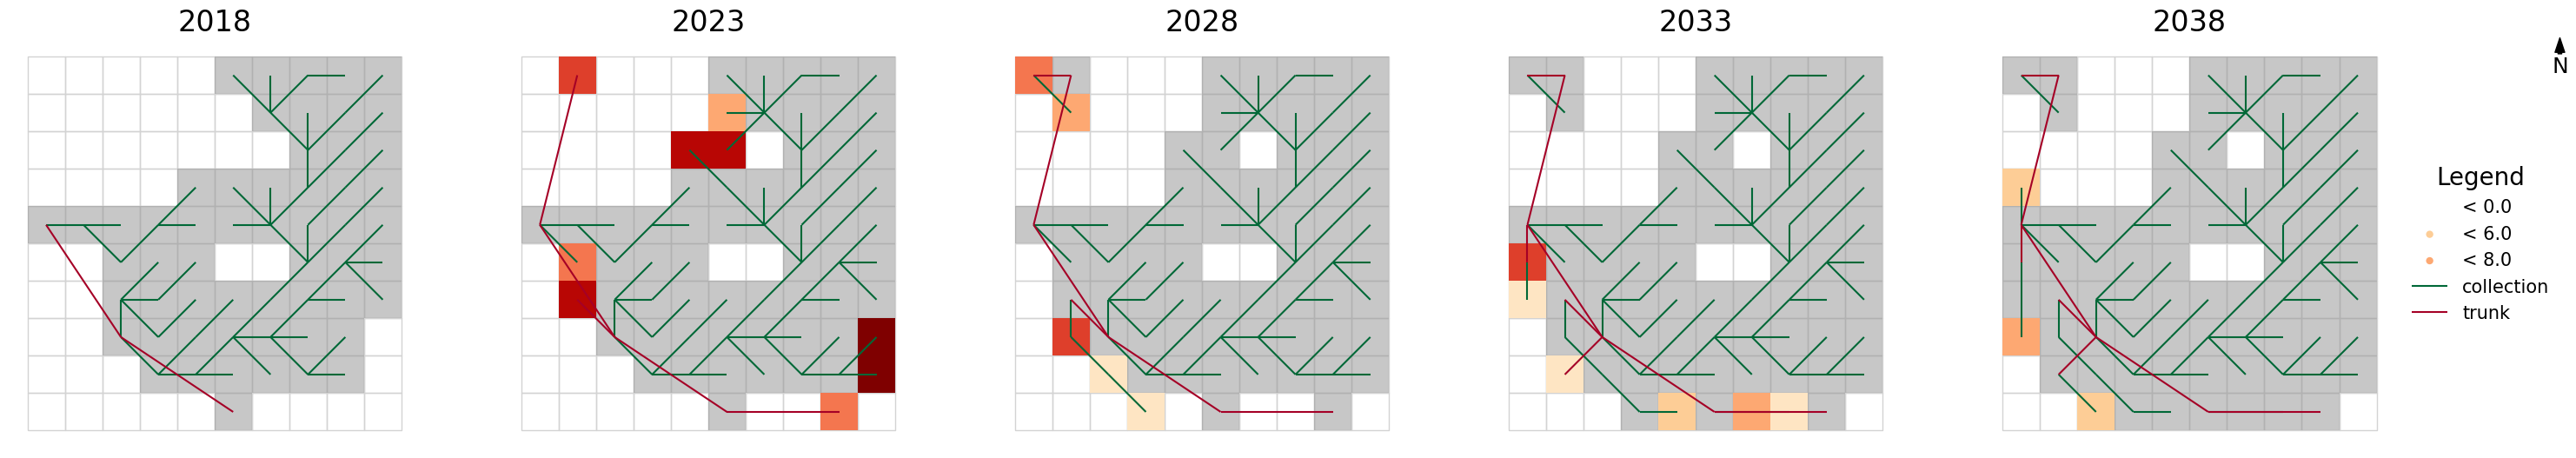

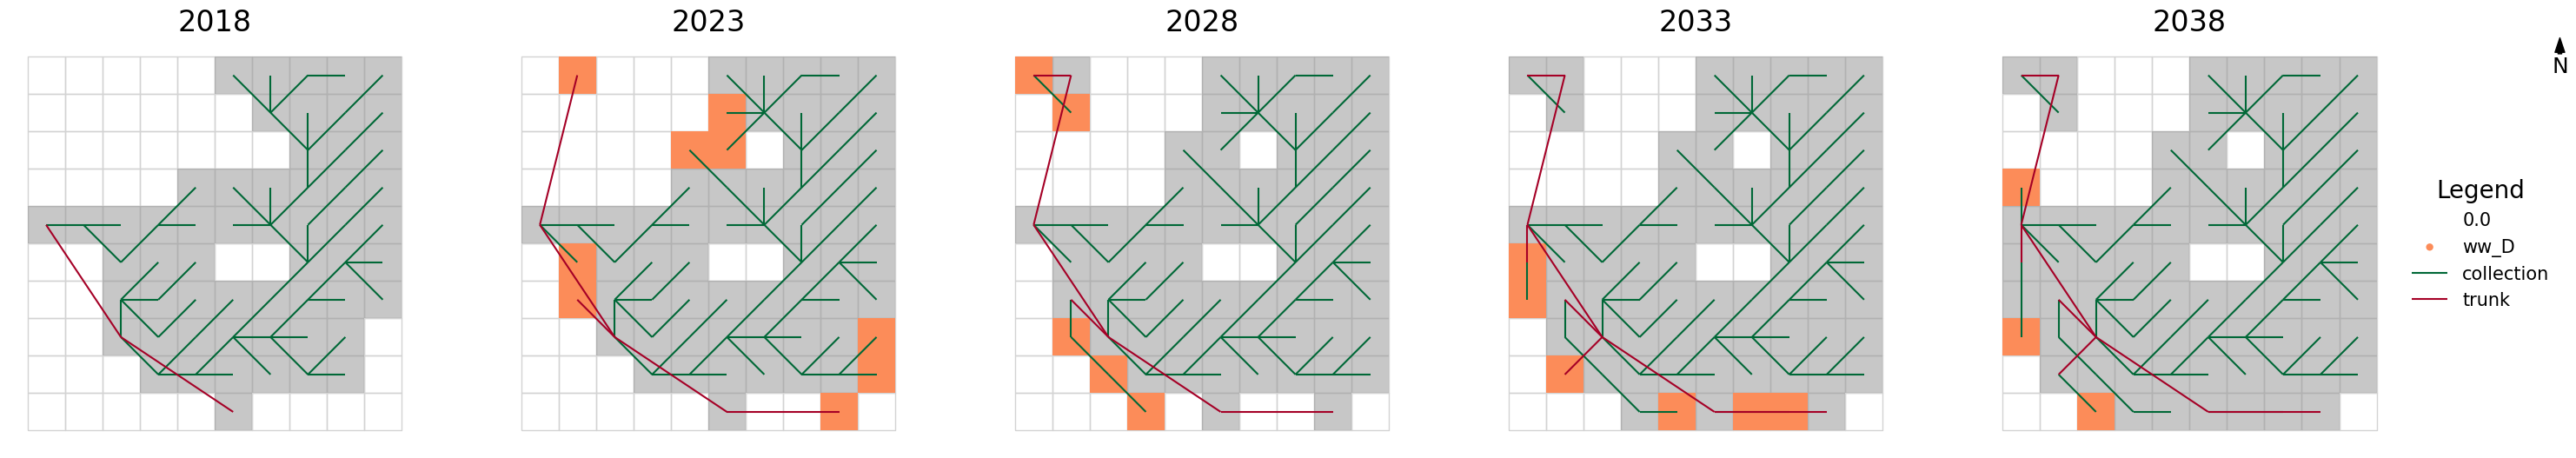

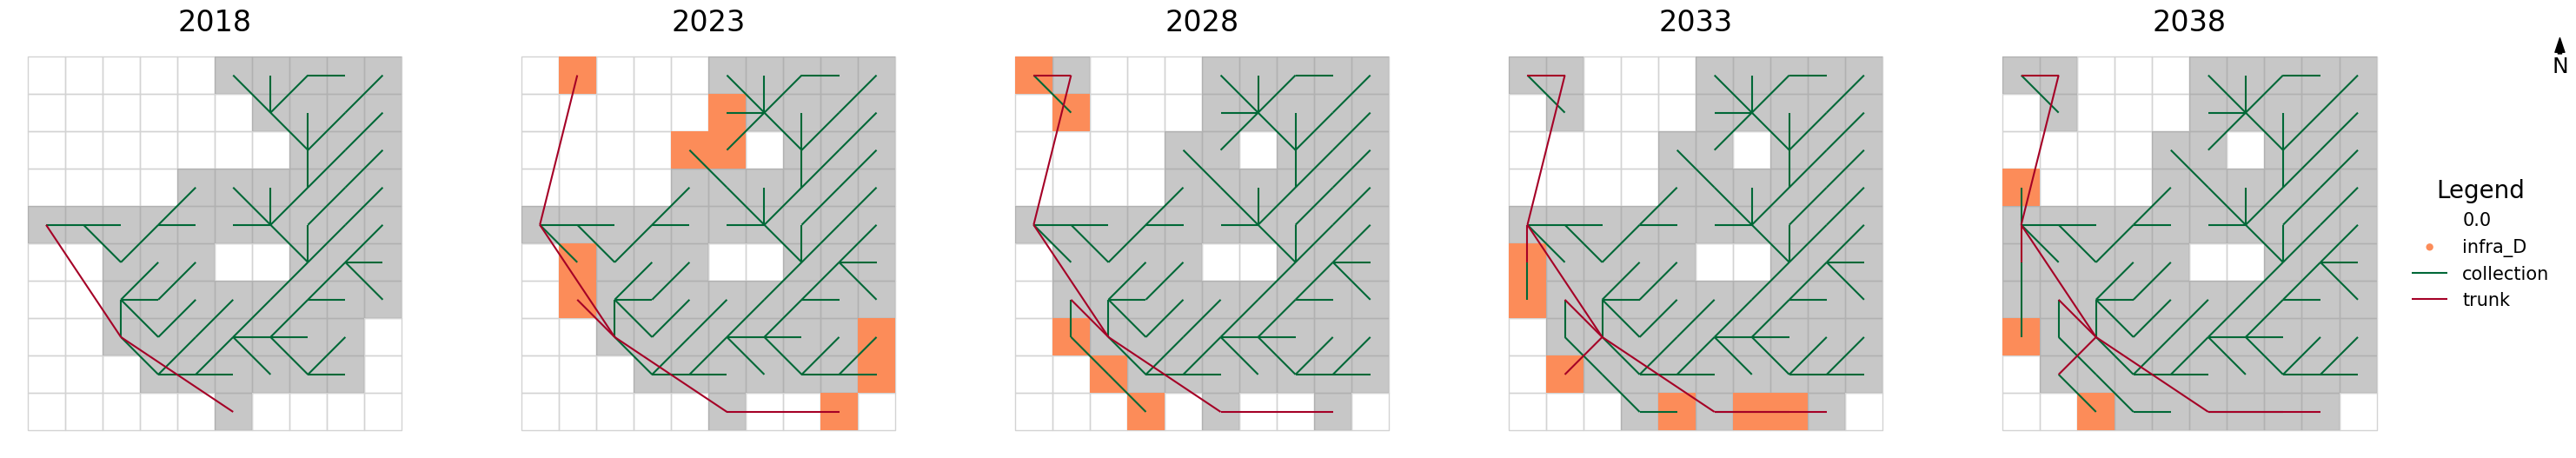

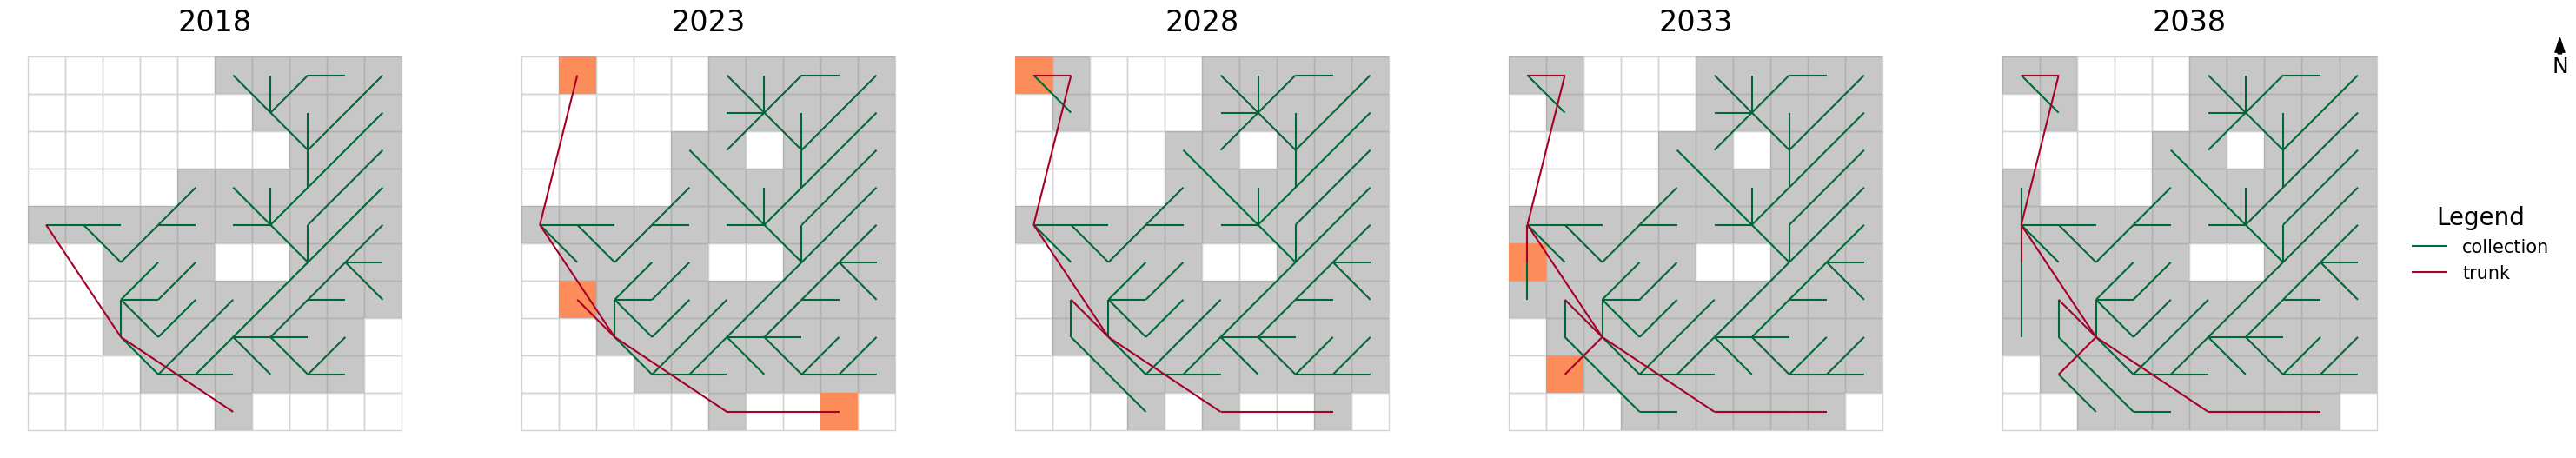

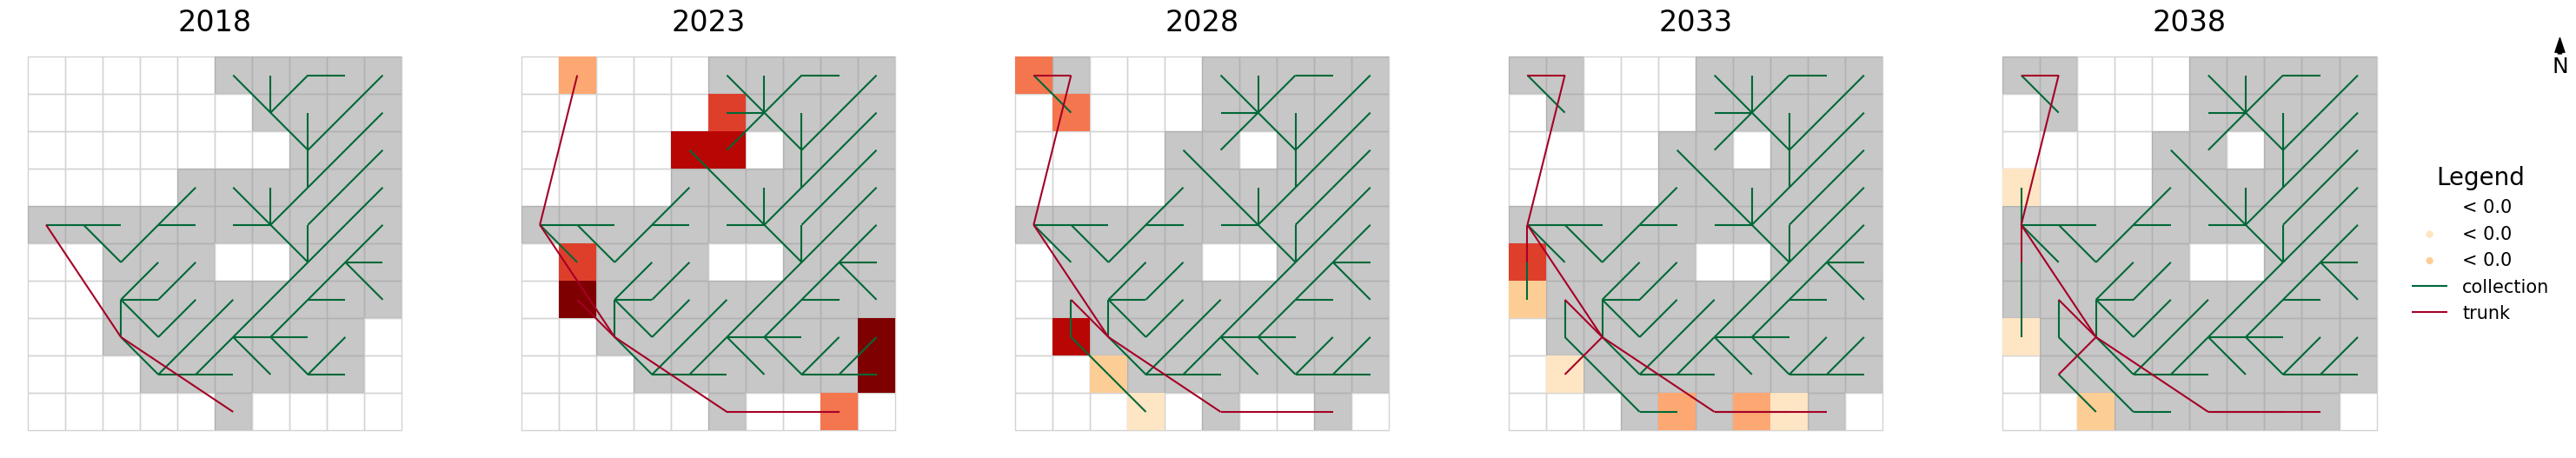

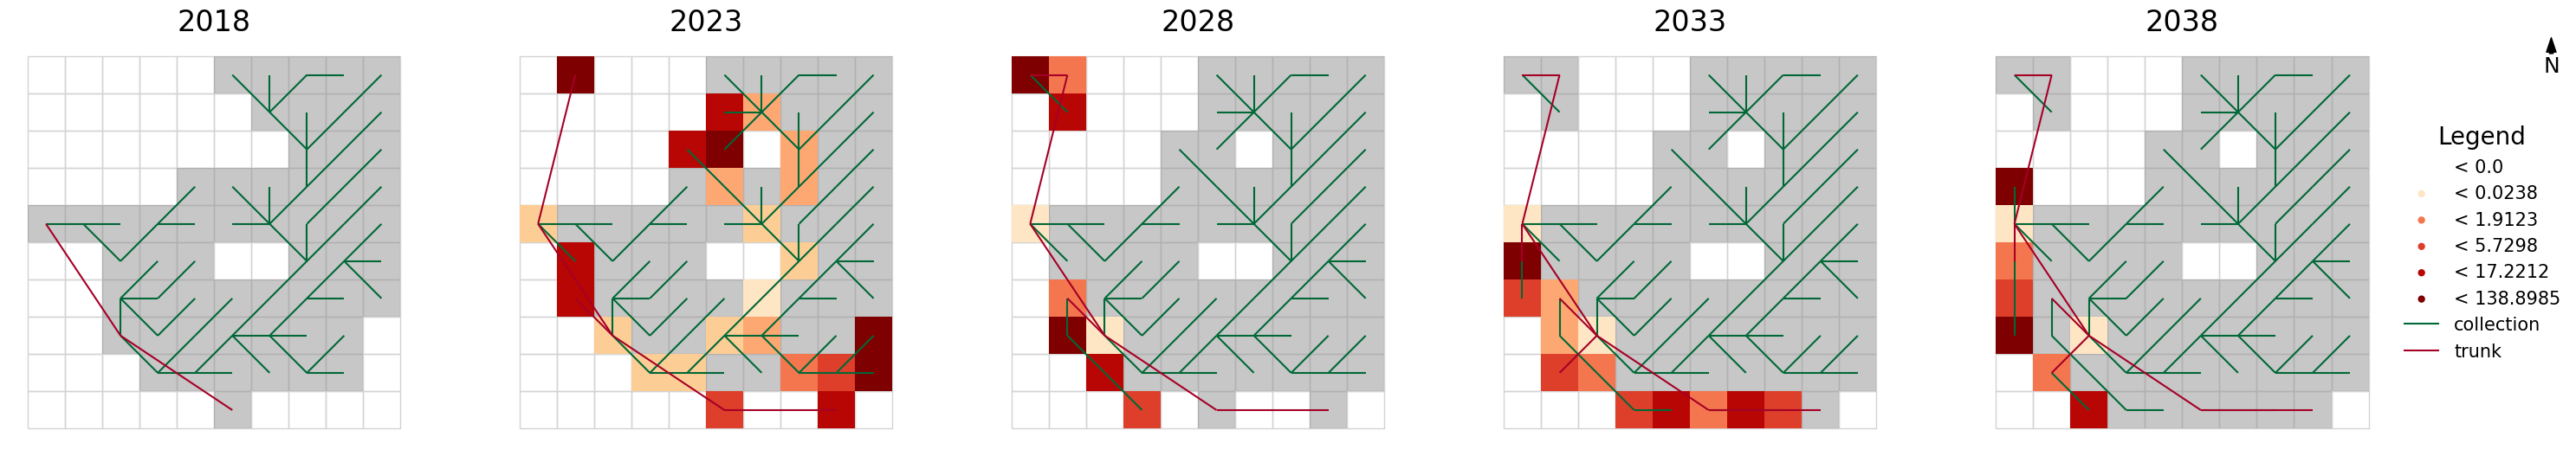

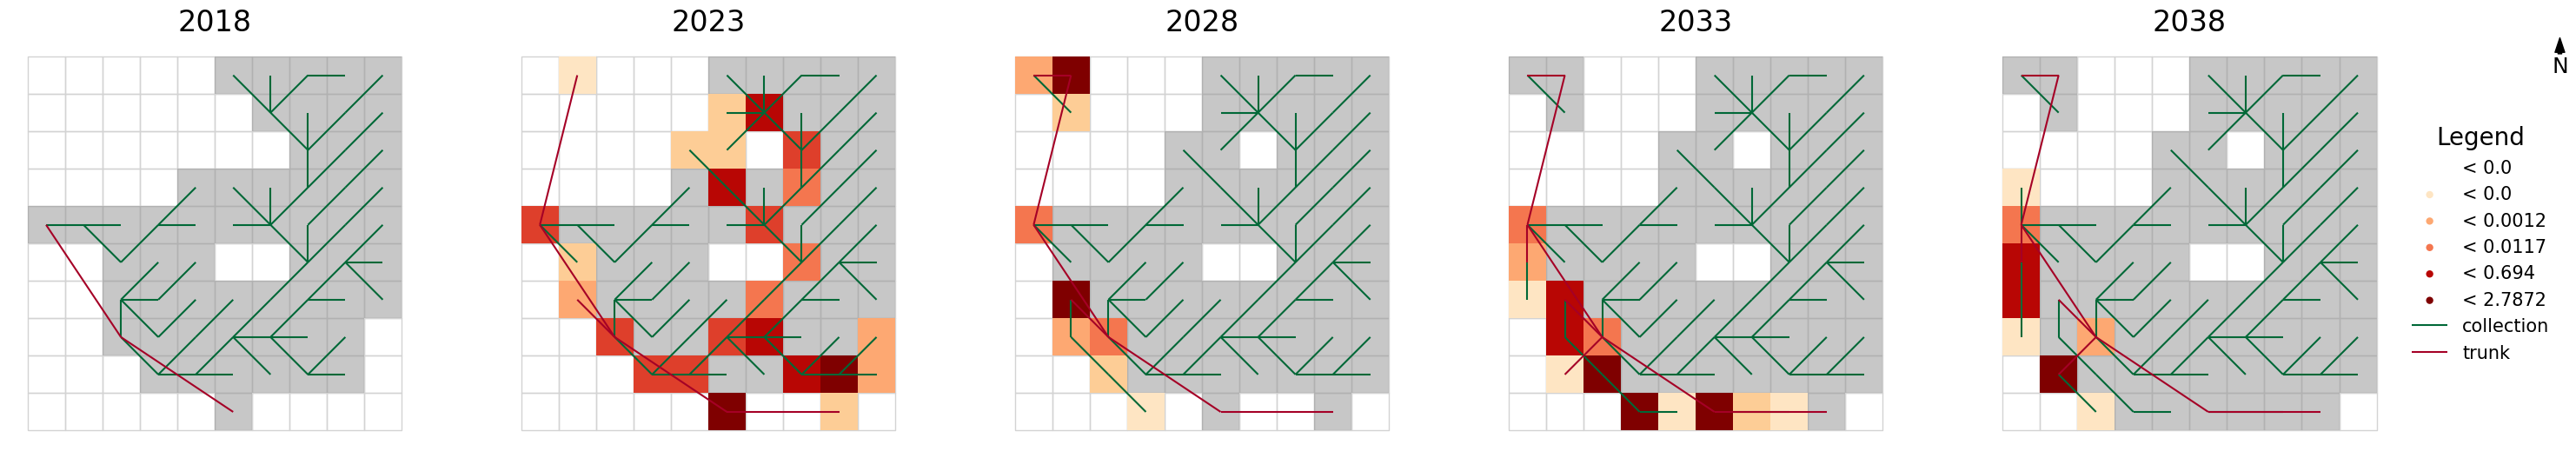

In [ ]:
if bool_run_test_data:
    for c in new_columns:
        #[TODO] can not plot because all the differences for the fisrt year is cero??? check
        print(c)
        plot_development(poly_dict=test_blocks_dict, 
                    lineStr_dict=test_pipes_dict, 
                    feature_poly=c, units_poly = "[delta]", cmap_poly= pl.cm.OrRd,
                    feature_lineStr="type_sewer", units_lineStr = "[type]", cmap_lineStr=pl.cm.RdYlGn_r,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                    backgroud_layers=["has_ww"], cmap_background_layers=[cmap_grey],
                    path=output_path,
                    verbose=False,
                    )


--------2018 ---------- 
Plotting polygons feature: 'pop_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87B30160>] ['\npop_D']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2023 ---------- 
Plotting polygons feature: 'pop_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.collections.PathCollection object at 0x000001AE87733D60>, <matplotlib.collections.PathCollection object at 0x000001AE8723D5E0>, <matplotlib.collections.PathCollection object at 0x000001AE8723DDC0>, <matplotlib.collections.PathCollection object at 0x000001AE87180070>, <matplotlib.collections.PathCollection object at 0x000001AE8718F430>, <matplotlib.collections.PathCollection object at 0x000001AE8769D3D0>] ['\npop_D', '\npop_D', '< 0.0', '< 8.0', '< 10.0', '< 12.0', '< 42.0', '< 53.0']
----------EN OF HANDLES-----------

Plotting pipes 'type_sewer' ...
Categorical variable: Pipes

--------2028 ---------- 
Plotting polygons feature: 'pop_D' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.collections.PathCollection object at 0x000001AE87733D60>, <matplotlib.collections.PathCollection object at 0x000001AE8723D5E0>, <matplotlib.collections.PathCollection object at 0x000001AE8723DDC0>, <matplotlib.collections.PathCollection object at 0x000001AE87180070>, <matplotlib.collections.PathCollection object at 0x000001AE8718F430>, <matplotlib.collections.PathCollection object at 0x000001AE8769D3D0>, <matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.collections.PathCollection object at 0x000001AE876FC700>, <matplotlib.collections.PathCollection object at 0x000001AE879755E0>, <matplotlib.collections.PathCollection object at 0x000001AE87710F70>, <matplotlib.collections.PathCollection object at 0x000001AE87B22520>, <matplotlib.collections.PathCollection object at 0x000001AE870FD700>] ['\npop_D', '\npop_D', '< 0.0', '< 8.0', '

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.collections.PathCollection object at 0x000001AE87733D60>, <matplotlib.collections.PathCollection object at 0x000001AE8723D5E0>, <matplotlib.collections.PathCollection object at 0x000001AE8723DDC0>, <matplotlib.collections.PathCollection object at 0x000001AE87180070>, <matplotlib.collections.PathCollection object at 0x000001AE8718F430>, <matplotlib.collections.PathCollection object at 0x000001AE8769D3D0>, <matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.collections.PathCollection object at 0x000001AE876FC700>, <matplotlib.collections.PathCollection object at 0x000001AE879755E0>, <matplotlib.collections.PathCollection object at 0x000001AE87710F70>, <matplotlib.collections.PathCollection object at 0x000001AE87B22520>, <matplotlib.collections.PathCollection object at 0x000001AE870FD700>, <matplotlib.lines.Line2D object at 0x00000

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.collections.PathCollection object at 0x000001AE87733D60>, <matplotlib.collections.PathCollection object at 0x000001AE8723D5E0>, <matplotlib.collections.PathCollection object at 0x000001AE8723DDC0>, <matplotlib.collections.PathCollection object at 0x000001AE87180070>, <matplotlib.collections.PathCollection object at 0x000001AE8718F430>, <matplotlib.collections.PathCollection object at 0x000001AE8769D3D0>, <matplotlib.lines.Line2D object at 0x000001AE87B30160>, <matplotlib.collections.PathCollection object at 0x000001AE876FC700>, <matplotlib.collections.PathCollection object at 0x000001AE879755E0>, <matplotlib.collections.PathCollection object at 0x000001AE87710F70>, <matplotlib.collections.PathCollection object at 0x000001AE87B22520>, <matplotlib.collections.PathCollection object at 0x000001AE870FD700>, <matplotlib.lines.Line2D object at 0x00000

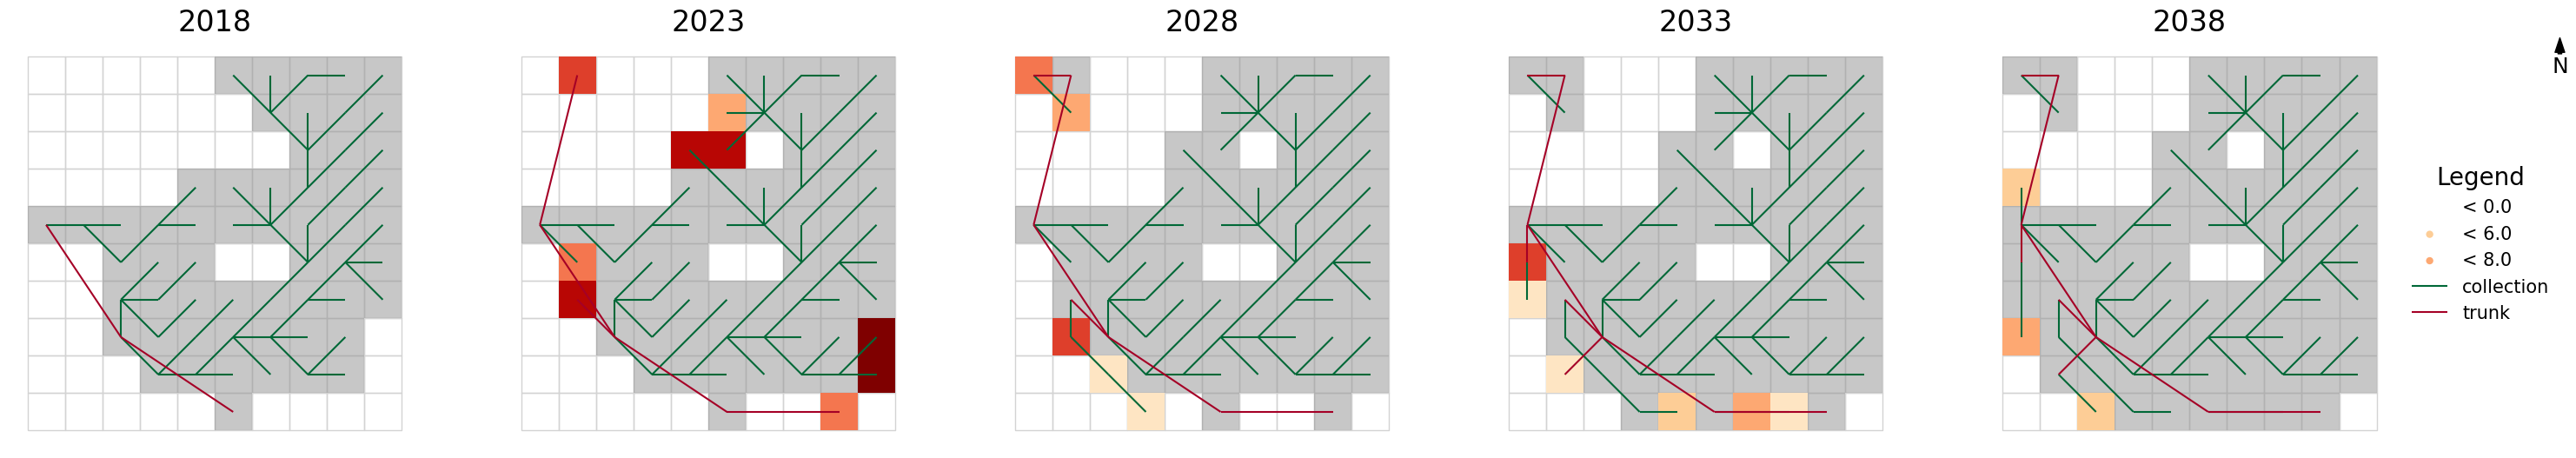

In [ ]:
#Population delta
if bool_run_test_data:
    
    plot_development(poly_dict=test_blocks_dict, 
                lineStr_dict=test_pipes_dict, 
                feature_poly="pop_D", units_poly = "[persons]", cmap_poly= pl.cm.OrRd,
                feature_lineStr="type_sewer", units_lineStr = "[type]", cmap_lineStr=pl.cm.RdYlGn_r,
                module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                backgroud_layers=["has_ww"], cmap_background_layers=[cmap_grey],
                path=output_path,
                verbose=False,
                )


--------2018 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE882D4520>, <matplotlib.collections.PathCollection object at 0x000001AE874125B0>] ['\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'desg_flow' ...

--------2023 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE882D4520>, <matplotlib.collections.PathCollection object at 0x000001AE874125B0>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE874CD0D0>, <matplotlib.collections.PathCollection object at 0x000001AE873C4B20>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'desg_flow' ...

--------2028 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE882D4520>, <matplotlib.collections.PathCollection object at 0x000001AE874125B0>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE874CD0D0>, <matplotlib.collections.PathCollection object at 0x000001AE873C4B20>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE876062B0>, <matplotlib.collections.PathCollection object at 0x000001AE873DC8B0>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'desg_flow' ...

--------2033 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE882D4520>, <matplotlib.collections.PathCollection object at 0x000001AE874125B0>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE874CD0D0>, <matplotlib.collections.PathCollection object at 0x000001AE873C4B20>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE876062B0>, <matplotlib.collections.PathCollection object at 0x000001AE873DC8B0>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE876137C0>, <matplotlib.collections.PathCollection object at 0x000001AE8527F160>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'desg_flow' 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE882D4520>, <matplotlib.collections.PathCollection object at 0x000001AE874125B0>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE874CD0D0>, <matplotlib.collections.PathCollection object at 0x000001AE873C4B20>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE876062B0>, <matplotlib.collections.PathCollection object at 0x000001AE873DC8B0>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE876137C0>, <matplotlib.collections.PathCollection object at 0x000001AE8527F160>, <matplotlib.lines.Line2D object at 0x000001AE84D38340>, <matplotlib.collections.PathCollection object at 0x000001AE8E32D2B0>, <matplotlib.collections.PathCollection object at 0x000001AE87450070>] 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


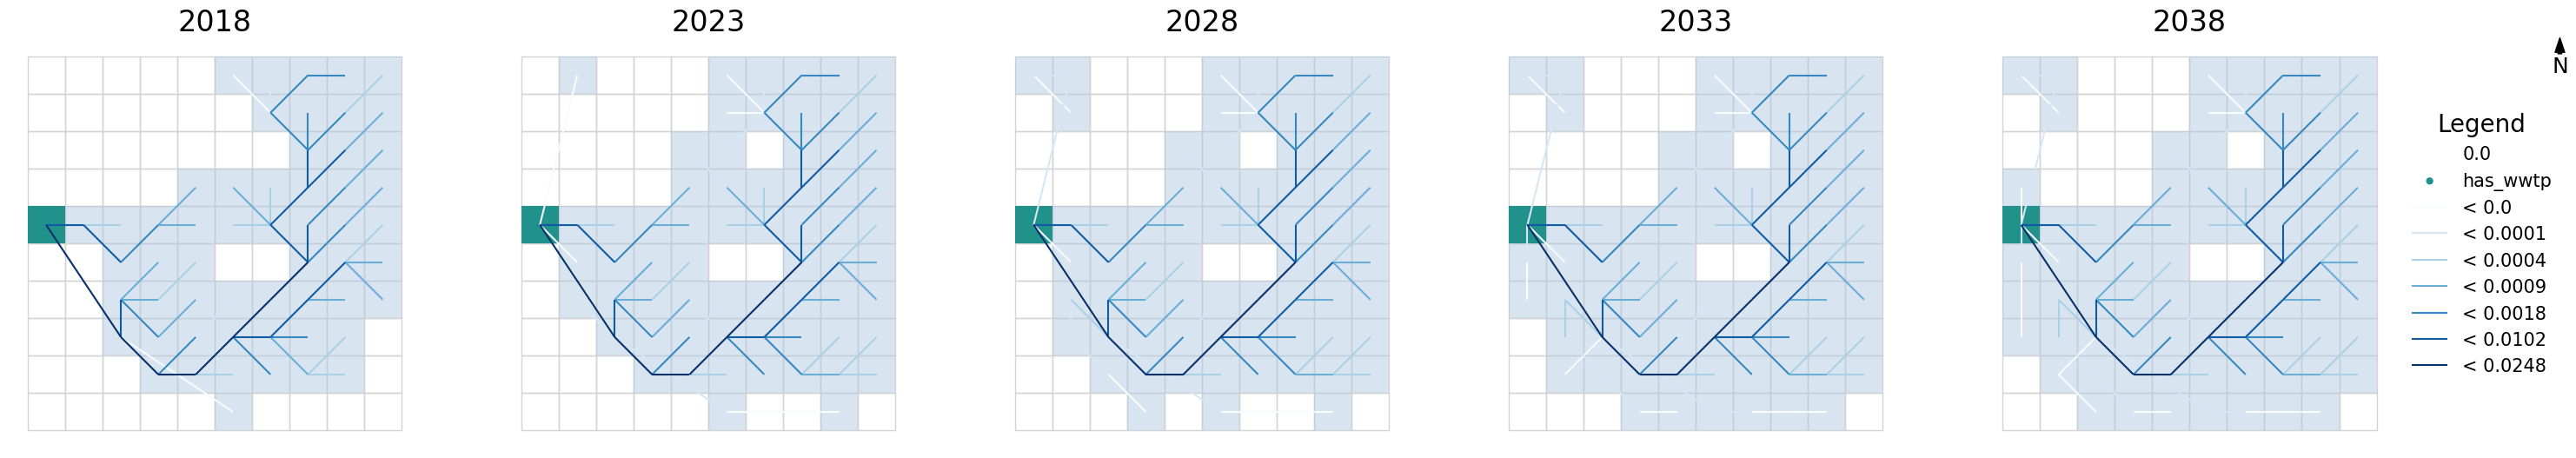

In [ ]:
# New WWTP 
if bool_run_test_data:
    
    plot_development(poly_dict=test_blocks_dict, 
                lineStr_dict=test_pipes_dict, 
                feature_poly="has_wwtp", units_poly = "[persons]", cmap_poly= pl.cm.viridis,
                feature_lineStr="desg_flow", units_lineStr = "[m3/s]", cmap_lineStr=pl.cm.Blues,
                module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                backgroud_layers=["has_ww"], cmap_background_layers=[pl.cm.Pastel1],
                path=output_path,
                verbose=False,
                )

In [200]:
sum(test_pipes_dict[2018].loc[test_pipes_dict[2018]["Population"]>0, "Population"])


1897400.0

In [201]:
b_df=test_pipes_dict[2018]

In [202]:
b_df.loc[b_df["has_wwtp"]>0, ["BlockID", "PE"]]

Empty DataFrame
Columns: [BlockID, PE]
Index: []

check all columns between Blocks and Pipes

In [203]:
pp_df = test_pipes_dict[2018]
blks_df = test_blocks_dict[2018]
ids_blocks = blks_df["BlockID"].values
ids_pipes = pp_df["BlockID"].values
print(len(ids_blocks))
print(len(ids_pipes))


for idx, pp in pp_df.iterrows():
    id_pipe = pp["BlockID"]

    corresponding_block = blks_df[blks_df["BlockID"]==id_pipe]
    
    if not corresponding_block.empty  :
        pd.set_option("display.max_columns", pp_df.shape[0])  # None or 1000
        display(pp==corresponding_block)
        display(pp_df.loc[[idx]])
        display(corresponding_block)
        break

        


100
55


BlockID  BasinID  CentreX  CentreY  Neighbours  Active  pLU_RES  pLU_COM  \
5     True    False     True     True        True    True     True     True   

   pLU_ORC  pLU_LI  pLU_HI  pLU_CIV  pLU_SVU  pLU_RD  pLU_TR  pLU_PG  pLU_REF  \
5     True    True    True     True     True    True    True    True     True   

   pLU_UND  pLU_NA  pLU_WAT  pLU_FOR  pLU_AGR  Population  AvgElev  MaxElev  \
5     True    True     True     True     True        True     True     True   

   MinElev  Slope_PCT  ...  has_outlet  pipe_loc  type_sewer  basin_id  \
5     True      False  ...        True      True        True      True   

   horiz_dist  elev_drop  terr_slope  near_wwtp  near_river  ww_inflow  \
5        True       True        True       True        True       True   

   peak_flow    PE  desg_flow  up_ids  down_ids  built_year  PE_blk  PE_proj  \
5       True  True       True    True      True        True    True     True   

   PE_total  pop_D  ww_D  infra_D  wwtp_D  outlet_D  pk_flow_D  PE_D  \
5      True   True  True     True    True      True       True  True   

   des_flow_D  
5        True  

[1 rows x 219 columns]

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
5      471    None   3900.0   2300.0  [470, 472, 511, 512, 513]     1.0   

   pLU_RES  pLU_COM  pLU_ORC  pLU_LI  pLU_HI  pLU_CIV  pLU_SVU  pLU_RD  \
5     0.25      0.0      0.0     0.0     0.0      0.0      0.0     0.0   

   pLU_TR  pLU_PG  pLU_REF  pLU_UND  pLU_NA  pLU_WAT  pLU_FOR  pLU_AGR  \
5     0.0     0.0      0.0      0.0     0.0      0.0      0.0     0.75   

   Population     AvgElev  MaxElev  MinElev Slope_PCT  ... has_outlet  \
5       800.0  446.453125    450.0    442.0      None  ...        1.0   

   pipe_loc  type_sewer basin_id  horiz_dist elev_drop  terr_slope  near_wwtp  \
5  external       trunk      3.0  721.110255   4.90625    0.006804      671.0   

   near_river ww_inflow  peak_flow   PE  desg_flow  up_ids    down_ids  \
5         0.0       0.0   0.002648  0.0   0.002648      []  [550, 671]   

   built_year  PE_blk      PE_proj     PE_total  pop_D  ww_D  infra_D  wwtp_D  \
5      2018.0   800.0  1025.945596  1025.945596    0.0   0.0      0.0     0.0   

   outlet_D  pk_flow_D  PE_D  des_flow_D  
5       0.0        0.0   0.0         0.0  

[1 rows x 219 columns]

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
5      471    None   3900.0   2300.0  [470, 472, 511, 512, 513]     1.0   

   pLU_RES  pLU_COM  pLU_ORC  pLU_LI  pLU_HI  pLU_CIV  pLU_SVU  pLU_RD  \
5     0.25      0.0      0.0     0.0     0.0      0.0      0.0     0.0   

   pLU_TR  pLU_PG  pLU_REF  pLU_UND  pLU_NA  pLU_WAT  pLU_FOR  pLU_AGR  \
5     0.0     0.0      0.0      0.0     0.0      0.0      0.0     0.75   

   Population     AvgElev  MaxElev  MinElev Slope_PCT  ... has_outlet  \
5       800.0  446.453125    450.0    442.0      None  ...        1.0   

   pipe_loc  type_sewer basin_id  horiz_dist elev_drop  terr_slope  near_wwtp  \
5  external       trunk      3.0  721.110255   4.90625    0.006804      671.0   

   near_river ww_inflow  peak_flow   PE  desg_flow  up_ids    down_ids  \
5         0.0       0.0   0.002648  0.0   0.002648      []  [550, 671]   

   built_year  PE_blk      PE_proj     PE_total  pop_D  ww_D  infra_D  wwtp_D  \
5      2018.0   800.0  1025.945596  1025.945596    0.0   0.0      0.0     0.0   

   outlet_D  pk_flow_D  PE_D  des_flow_D  
5       0.0        0.0   0.0         0.0  

[1 rows x 219 columns]

In [204]:
display(blks_df[blks_df["BlockID"]==671])
display(pp_df[pp_df["BlockID"]==671])

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
50      671    None   2900.0   3300.0  [630, 631, 672, 712, 713]     1.0   

    pLU_RES  pLU_COM  pLU_ORC  pLU_LI  pLU_HI  pLU_CIV  pLU_SVU  pLU_RD  \
50      0.0     0.25      0.0     0.0     0.0      0.0      0.0     0.0   

    pLU_TR  pLU_PG  pLU_REF  pLU_UND  pLU_NA  pLU_WAT  pLU_FOR  pLU_AGR  \
50     0.0    0.25      0.0      0.0     0.0      0.0     0.25     0.25   

    Population     AvgElev  MaxElev  MinElev Slope_PCT  ... has_outlet  \
50      6000.0  435.734375    438.0    435.0      None  ...        1.0   

   pipe_loc  type_sewer basin_id  horiz_dist elev_drop  terr_slope  near_wwtp  \
50      0.0      wwtp_c      3.0         0.0       0.0         0.0      671.0   

    near_river ww_inflow  peak_flow   PE  desg_flow  \
50         0.0  5.275124   0.002222  0.0   5.277346   

                                               up_ids  down_ids  built_year  \
50  [550, 672, 471, 510, 591, 632, 673, 511, 552, ...     [671]         0.0   

        PE_blk      PE_proj      PE_total  pop_D  ww_D  infra_D  wwtp_D  \
50  6013.82716  7712.324363  2.442807e+06    0.0   0.0      0.0     0.0   

    outlet_D  pk_flow_D  PE_D  des_flow_D  
50       0.0        0.0   0.0         0.0  

[1 rows x 219 columns]

Empty GeoDataFrame
Columns: [BlockID, BasinID, CentreX, CentreY, Neighbours, Active, pLU_RES, pLU_COM, pLU_ORC, pLU_LI, pLU_HI, pLU_CIV, pLU_SVU, pLU_RD, pLU_TR, pLU_PG, pLU_REF, pLU_UND, pLU_NA, pLU_WAT, pLU_FOR, pLU_AGR, Population, AvgElev, MaxElev, MinElev, Slope_PCT, Slope_DEG, Aspect_DEG, HasRiver, RiverNames, HasLake, LakeNames, MiscAtot, MiscAimp, MiscThresh, UND_Type, UND_av, OpenSpace, AGreenOS, ASquare, PG_av, REF_av, ANonW_Util, SVU_avWS, SVU_avWW, SVU_avSW, SVU_avOTH, RoadTIA, ParkBuffer, RD_av, HouseOccup, ResParcels, ResFrontT, avSt_RES, WResNstrip, ResAllots, ResDWpLot, ResHouses, ResLotArea, ResRoof, avLt_RES, ResHFloors, ResLotTIA, ResLotEIA, ResGarden, ResRoofCon, ResLotALS, ResLotARS, HDRFlats, HDRRoofA, HDROccup, HDR_TIA, HDR_EIA, HDRFloors, av_HDRes, HDRGarden, HDRCarPark, LIjobs, LIestates, avSt_LI, LIAfront, LIAfrEIA, LIAestate, LIAeBldg, LIFloors, LIAeLoad, LIAeCPark, avLt_LI, LIAeLgrey, LIAeEIA, LIAeTIA, HIjobs, HIestates, avSt_HI, HIAfront, HIAfrEIA, HIAestate, HIAeBldg, HIFloors, ...]
Index: []

[0 rows x 219 columns]